# Neural network for h->aa->bbtautau signal/background separation

# Model definition and training

## Packages

In [1]:
import ROOT
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Activation, Dense, Dropout
from keras.initializers import glorot_uniform
from keras.utils import plot_model

import kerastuner
from kerastuner import Hyperband

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

import joblib

Welcome to JupyROOT 6.22/06


Using TensorFlow backend.


## Load root files

In [2]:
file_obs18 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt18_raw/data_obs.root')
file_sig18 = ROOT.RDataFrame('mutau_tree', {'root_raw/mt18_raw/ggH_bbtt*.root', 'root_raw/mt18_raw/vbf_bbtt*.root'})
file_ZTT18 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt18_raw/embedded.root')
file_TT18 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt18_raw/TT*.root')

file_obs17 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt17_raw/data_obs.root')
file_sig17 = ROOT.RDataFrame('mutau_tree', {'root_raw/mt17_raw/ggH_bbtt*.root', 'root_raw/mt17_raw/vbf_bbtt*.root'})
file_ZTT17 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt17_raw/embedded.root')
file_TT17 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt17_raw/TT*.root')

file_obs16 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt16_raw/data_obs.root')
file_sig16 = ROOT.RDataFrame('mutau_tree', {'root_raw/mt16_raw/ggH_bbtt*.root', 'root_raw/mt16_raw/vbf_bbtt*.root'})
file_ZTT16 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt16_raw/embedded.root')
file_TT16 = ROOT.RDataFrame('mutau_tree', 'root_raw/mt16_raw/TT*.root')

files18 = [file_obs18, file_sig18, file_ZTT18, file_TT18]
files17 = [file_obs17, file_sig17, file_ZTT17, file_TT17]
files16 = [file_obs16, file_sig16, file_ZTT16, file_TT16]

In [3]:
# 1b events
for i in range(len(files18)):
    files18[i] = files18[i].Filter('bpt_deepcsv_1>20 && bscore_deepcsv_1>0.4184 && bpt_deepcsv_2<0')
    files17[i] = files17[i].Filter('bpt_deepcsv_1>20 && bscore_deepcsv_1>0.4941 && bpt_deepcsv_2<0')
    files16[i] = files16[i].Filter('bpt_deepcsv_1>20 && bscore_deepcsv_1>0.6321 && bpt_deepcsv_2<0')

## Define some input features

In [4]:
# define 4-vectors, invariant masses and etc.
mymu = 'ROOT::Math::PtEtaPhiMVector(pt_1,eta_1,phi_1,m_1)'
mytau = 'ROOT::Math::PtEtaPhiMVector(pt_2,eta_2,phi_2,m_2)'
mymet = 'ROOT::Math::PtEtaPhiMVector(met,0,metphi,0)'
mytt = 'ROOT::Math::PtEtaPhiMVector((mymu+mytau+mymet).Pt(),(mymu+mytau+mymet).Eta(),(mymu+mytau+mymet).Phi(),m_sv)'
myb1 = 'ROOT::Math::PtEtaPhiMVector(bpt_deepcsv_1,beta_deepcsv_1,bphi_deepcsv_1,bm_deepcsv_1)'
m_btt = '(mytt+myb1).M()'
m_b1mu = '(mymu+myb1).M()'
m_b1tau = '(mytau+myb1).M()'
dR_tt = 'ROOT::Math::VectorUtil::DeltaR(mymu,mytau)'
dR_b1mu = 'ROOT::Math::VectorUtil::DeltaR(mymu,myb1)'
dR_b1tau = 'ROOT::Math::VectorUtil::DeltaR(mytau,myb1)'
dR_b1tt = 'ROOT::Math::VectorUtil::DeltaR(myb1,mytt)'
tt_pt = 'mytt.Pt()'
tt_eta = 'mytt.Eta()'

# define transverse masses mT and D_zeta
mT_mu = 'sqrt(pow(mymu.Pt()+mymet.Pt(),2)-pow(mymu.Px()+mymet.Px(),2)-pow(mymu.Py()+mymet.Py(),2))'
mT_tau = 'sqrt(pow(mytau.Pt()+mymet.Pt(),2)-pow(mytau.Px()+mymet.Px(),2)-pow(mytau.Py()+mymet.Py(),2))'
mT_b1 = 'sqrt(pow(myb1.Pt()+mymet.Pt(),2)-pow(myb1.Px()+mymet.Px(),2)-pow(myb1.Py()+mymet.Py(),2))'
norm_zeta = 'sqrt(pow(mymu.Px()/mymu.Pt()+mytau.Px()/mytau.Pt(),2)+pow(mymu.Py()/mymu.Pt()+mytau.Py()/mytau.Pt(),2))'
x_zeta = '(mymu.Px()/mymu.Pt()+mytau.Px()/mytau.Pt())/norm_zeta'
y_zeta = '(mymu.Py()/mymu.Pt()+mytau.Py()/mytau.Pt())/norm_zeta'
p_zeta_mis = 'mymet.Px()*x_zeta+mymet.Py()*y_zeta'
pzeta_vis = '(mymu.Px()+mytau.Px())*x_zeta+(mymu.Py()+mytau.Py())*y_zeta'
Dzeta = 'p_zeta_mis-0.85*pzeta_vis'

# add defined variables to dataframe
for i in range(len(files18)):
    files18[i] = files18[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b1tau', m_b1tau)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)
    
    files17[i] = files17[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b1tau', m_b1tau)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)
    
    files16[i] = files16[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b1tau', m_b1tau)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

## Apply baseline selection cuts

In [5]:
######################## 2 0 1 8 ##########################
# 2018 mu+tau trigger requirements
trigger24OR27_18 = '((passMu24 && matchMu24_1 && filterMu24_1 && pt_1>25) or (passMu27 && matchMu27_1 && filterMu27_1 && pt_1>25))'#keep 25 not 28
trigger2027_18 = '(passMu20Tau27 && matchMu20Tau27_1 && filterMu20Tau27_1 && matchMu20Tau27_2 && filterMu20Tau27_2 && pt_1>21 && pt_1<25 && pt_2>32 && fabs(eta_2)<2.1)'
trigger2027HPS_18 = '(passMu20HPSTau27 && matchMu20HPSTau27_1 && filterMu20HPSTau27_1 && matchMu20HPSTau27_2 && filterMu20HPSTau27_2 && pt_1>21 && pt_1<25 && pt_2>32 && fabs(eta_2)<2.1)'
trigger24OR27_emb_18 = '((passMu24 && matchMu24_1 && pt_1>25) or (passMu27 && matchMu27_1 && pt_1>25))'#keep 25 not 28
trigger2027HPS_emb_18 = '(matchEmbFilter_Mu20Tau27_1 && matchEmbFilter_Mu20HPSTau27_2 && pt_1>21 && pt_1<25 && pt_2>32 && fabs(eta_2)<2.1)'

trigger_mc_18 = trigger24OR27_18 + str(' or ') + trigger2027HPS_18
trigger_obs_1_18 = trigger2027_18 + str(' or ') + trigger24OR27_18
trigger_obs_2_18 = trigger2027HPS_18 + str(' or ') + trigger24OR27_18
trigger_emb_18 = trigger24OR27_emb_18 + str(' or ') + trigger2027HPS_emb_18

for i in range(len(files18)):
    files18[i] = files18[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('Flag_ecalBadCalibReducedMINIAODFilter==0')\
    .Filter('pt_2>20')\
    .Filter('fabs(eta_1)<2.1 && fabs(eta_2)<2.3')\
    .Filter('iso_1<0.15')\
    .Filter('byVLooseDeepVSe_2 && byTightDeepVSmu_2')\
    .Filter('dR_tt>0.4')

files18[0] = files18[0].Filter('Flag_eeBadScFilter==0')
files18[2] = files18[2].Filter('Flag_eeBadScFilter==0')

files18[3] = files18[3].Filter('gen_match_2!=6').Filter('((gen_match_1<3 or gen_match_1==6) or (gen_match_1==4 && gen_match_2<3))')

files18[1] = files18[1].Filter('gen_match_1==4 && gen_match_2==5')#recontructed taus are gen taus
files18[1] = files18[1].Filter('m_btt<200')#reject long tail (mostly wrongly reco b jet)

files18[2] = files18[2].Filter('gen_match_2!=6').Filter('genweight<=1.0')

# triggers
obs1_18 = files18[0].Filter('run<317509').Filter(trigger_obs_1_18)
obs2_18 = files18[0].Filter('run>=317509').Filter(trigger_obs_2_18)
files18[1] = files18[1].Filter(trigger_mc_18)
files18[2] = files18[2].Filter(trigger_emb_18)
files18[3] = files18[3].Filter(trigger_mc_18)

# QCD region
qcd1_18 = obs1_18.Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')
qcd2_18 = obs2_18.Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')

# signal region
for i in range(1,len(files18)):
    files18[i] = files18[i].Filter('q_1*q_2<0')\
    .Filter('byMediumDeepVSjet_2')

######################## 2 0 1 7 ##########################
# 2017 mu+tau trigger requirements
trigger24OR27_17 = '((passMu24 && matchMu24_1 && filterMu24_1 && pt_1>25) or (passMu27 && matchMu27_1 && filterMu27_1 && pt_1>25))'#keep 25 not 28
trigger2027_17 = '(passMu20Tau27 && matchMu20Tau27_1 && filterMu20Tau27_1 && matchMu20Tau27_2 && filterMu20Tau27_2 && pt_1>21 && pt_1<25 && pt_2>32 && fabs(eta_2)<2.1)'
trigger24OR27_emb_17 = '((passMu24 && matchMu24_1 && pt_1>25) or (passMu27 && matchMu27_1 && pt_1>25))'#keep 25 not 28
trigger2027_emb_17 = '(matchEmbFilter_Mu20Tau27_2017_1 && matchEmbFilter_Mu20Tau27_2 && pt_1>21 && pt_1<25 && pt_2>32 && fabs(eta_2)<2.1)'

trigger_mc_obs_17 = trigger24OR27_17 + str(' or ') + trigger2027_17
trigger_emb_17 = trigger24OR27_emb_17 + str(' or ') + trigger2027_emb_17

for i in range(len(files17)):
    files17[i] = files17[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('Flag_ecalBadCalibReducedMINIAODFilter==0')\
    .Filter('pt_2>20')\
    .Filter('fabs(eta_1)<2.1 && fabs(eta_2)<2.3')\
    .Filter('iso_1<0.15')\
    .Filter('byVLooseDeepVSe_2 && byTightDeepVSmu_2')\
    .Filter('dR_tt>0.4')

files17[0] = files17[0].Filter('Flag_eeBadScFilter==0')
files17[2] = files17[2].Filter('Flag_eeBadScFilter==0')

files17[3] = files17[3].Filter('gen_match_2!=6').Filter('((gen_match_1<3 or gen_match_1==6) or (gen_match_1==4 && gen_match_2<3))')

files17[1] = files17[1].Filter('gen_match_1==4 && gen_match_2==5')#recontructed taus are gen taus
files17[1] = files17[1].Filter('m_btt<200')#reject long tail (mostly wrongly reco b jet)

files17[2] = files17[2].Filter('gen_match_2!=6').Filter('genweight<=1.0')

# triggers
files17[0] = files17[0].Filter(trigger_mc_obs_17)
files17[1] = files17[1].Filter(trigger_mc_obs_17)
files17[2] = files17[2].Filter(trigger_emb_17)
files17[3] = files17[3].Filter(trigger_mc_obs_17)

# QCD region
qcd_17 = files17[0].Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')

# signal region
for i in range(1,len(files17)):
    files17[i] = files17[i].Filter('q_1*q_2<0')\
    .Filter('byMediumDeepVSjet_2')

######################## 2 0 1 6 ##########################
# 2016 mu+tau trigger requirements
trigger22_16 = '((passMu22eta2p1 && matchMu22eta2p1_1 && filterMu22eta2p1_1 && pt_1>23) or (passTkMu22eta2p1 && matchTkMu22eta2p1_1 && filterTkMu22eta2p1_1 && pt_1>23) or (passMu22 && matchMu22_1 && filterMu22_1 && pt_1>23) or (passTkMu22 && matchTkMu22_1 && filterTkMu22_1 && pt_1>23))'
trigger1920_16 = '((passMu19Tau20 && matchMu19Tau20_1 && matchMu19Tau20_2 && filterMu19Tau20_1 && filterMu19Tau20_2 && pt_1>20 && pt_1<23 && pt_2>25 && fabs(eta_2)<2.1) or (passMu19Tau20SingleL1 && matchMu19Tau20SingleL1_1 && matchMu19Tau20SingleL1_2 && filterMu19Tau20SingleL1_1 && filterMu19Tau20SingleL1_2 && pt_1>20 && pt_1<23 && pt_2>25 && fabs(eta_2)<2.1))'

trigger_all_16 = trigger22_16 + str(' or ') + trigger1920_16

for i in range(len(files16)):
    files16[i] = files16[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('pt_2>20')\
    .Filter('fabs(eta_1)<2.1 && fabs(eta_2)<2.3')\
    .Filter('iso_1<0.15')\
    .Filter('byVLooseDeepVSe_2 && byTightDeepVSmu_2')\
    .Filter('dR_tt>0.4')

files16[0] = files16[0].Filter('Flag_eeBadScFilter==0')
files16[2] = files16[2].Filter('Flag_eeBadScFilter==0')

files16[3] = files16[3].Filter('gen_match_2!=6').Filter('((gen_match_1<3 or gen_match_1==6) or (gen_match_1==4 && gen_match_2<3))')

files16[1] = files16[1].Filter('gen_match_1==4 && gen_match_2==5')#recontructed taus are gen taus
files16[1] = files16[1].Filter('m_btt<200')#reject long tail (mostly wrongly reco b jet)

files16[2] = files16[2].Filter('gen_match_2!=6').Filter('genweight<=1.0')

# triggers
files16[0] = files16[0].Filter(trigger_all_16)
files16[1] = files16[1].Filter(trigger_all_16)
files16[2] = files16[2].Filter(trigger_all_16)
files16[3] = files16[3].Filter(trigger_all_16)

# QCD region
qcd_16 = files16[0].Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')

# signal region
for i in range(1,len(files16)):
    files16[i] = files16[i].Filter('q_1*q_2<0')\
    .Filter('byMediumDeepVSjet_2')

# [0]=obs, [1]=sig, [2]=embedded, [3]=ttbar

## Select all input features and save into pandas DataFrame

In [6]:
# list of feature variables
###### for 1b events
feature_list = ['pt_1', 'm_btt', 'm_b1mu', 'm_b1tau',\
                'dR_tt', 'dR_b1mu', 'dR_b1tau', 'dR_b1tt',\
                'tt_pt', 'tt_eta', 'mT_mu', 'mT_tau', 'mT_b1', 'Dzeta',\
                'bpt_deepcsv_1', 'njets']

# convert root RDataFrame into pandas DataFrame, saving only the features as columns
for i in range(1,len(files18)):
    files18[i] = pd.DataFrame(files18[i].AsNumpy(feature_list))
    files17[i] = pd.DataFrame(files17[i].AsNumpy(feature_list))
    files16[i] = pd.DataFrame(files16[i].AsNumpy(feature_list))
qcd1_18 = pd.DataFrame(qcd1_18.AsNumpy(feature_list))
qcd2_18 = pd.DataFrame(qcd2_18.AsNumpy(feature_list))
qcd_17 = pd.DataFrame(qcd_17.AsNumpy(feature_list))
qcd_16 = pd.DataFrame(qcd_16.AsNumpy(feature_list))

print('sig18.shape  : ' + str(files18[1].shape))
print('ZTT18.shape  : ' + str(files18[2].shape))
print('TT18.shape   : ' + str(files18[3].shape))
print('qcd18_1.shape: ' + str(qcd1_18.shape))
print('qcd18_2.shape: ' + str(qcd2_18.shape))
print('\nsig17.shape  : ' + str(files17[1].shape))
print('ZTT17.shape  : ' + str(files17[2].shape))
print('TT17.shape   : ' + str(files17[3].shape))
print('qcd17.shape  : ' + str(qcd_17.shape))
print('\nsig16.shape  : ' + str(files16[1].shape))
print('ZTT16.shape  : ' + str(files16[2].shape))
print('TT16.shape   : ' + str(files16[3].shape))
print('qcd16.shape  : ' + str(qcd_16.shape))

sig_allyears = [files18[1], files17[1], files16[1]]
ZTT_allyears = [files18[2], files17[2], files16[2]]
TT_allyears = [files18[3], files17[3], files16[3]]
qcd_allyears = [qcd1_18, qcd2_18, qcd_17, qcd_16]

sig_allyears = pd.concat(sig_allyears)
ZTT_allyears = pd.concat(ZTT_allyears)
TT_allyears = pd.concat(TT_allyears)
qcd_allyears = pd.concat(qcd_allyears)

# tag MC signal events as class 1
sig_allyears['label'] = np.ones((sig_allyears.shape[0], 1))

# tag MC background events as class 0
ZTT_allyears['label'] = np.zeros((ZTT_allyears.shape[0], 1))
TT_allyears['label'] = np.zeros((TT_allyears.shape[0],1))
qcd_allyears['label'] = np.zeros((qcd_allyears.shape[0], 1))

print('\nsig_allyears.shape: ' + str(sig_allyears.shape))
print('ZTT_allyears.shape: ' + str(ZTT_allyears.shape))
print('TT_allyears.shape : ' + str(TT_allyears.shape))
print('qcd_allyears.shape: ' + str(qcd_allyears.shape))

sig18.shape  : (17561, 16)
ZTT18.shape  : (158696, 16)
TT18.shape   : (368052, 16)
qcd18_1.shape: (61945, 16)
qcd18_2.shape: (141933, 16)

sig17.shape  : (16929, 16)
ZTT17.shape  : (91481, 16)
TT17.shape   : (48147, 16)
qcd17.shape  : (123221, 16)

sig16.shape  : (23453, 16)
ZTT16.shape  : (73915, 16)
TT16.shape   : (32147, 16)
qcd16.shape  : (89263, 16)

sig_allyears.shape: (57943, 17)
ZTT_allyears.shape: (324092, 17)
TT_allyears.shape : (448346, 17)
qcd_allyears.shape: (416362, 17)


## Split into MC/data

In [7]:
# reduce class 0 sample size for balanced training
ZTT_allyears = ZTT_allyears.sample(n = 10082, random_state = 20)#15972->17.4%->10082
TT_allyears = TT_allyears.sample(n = 24568, random_state = 20)#38961->42.4%->24568
qcd_allyears = qcd_allyears.sample(n = 23293, random_state = 20)#37006->40.2%->23293

# collect all MC as one dataframe, separated from another datafream for observed data
df_bkg = [ZTT_allyears, TT_allyears, qcd_allyears]
df_bkg = pd.concat(df_bkg)

df_MC = [sig_allyears, ZTT_allyears, TT_allyears, qcd_allyears]
df_MC = pd.concat(df_MC)

#print('\nObserved dataframe: \n' + str(df_obs))
print('\nMC dataframe: \n' + str(df_MC))


MC dataframe: 
            pt_1       m_btt      m_b1mu     m_b1tau     dR_tt   dR_b1mu  \
0      27.640627  105.860710   86.127964   88.114555  0.402234  2.820982   
1      29.985403   86.127265   82.287163   67.355697  0.402287  3.155046   
2      28.194452   88.469771   75.350343   65.025970  0.426936  2.842973   
3      26.203440  170.696067   74.096257   70.580542  0.418958  2.979965   
4      25.275053   70.564612   57.562529   64.946026  0.404176  3.026494   
...          ...         ...         ...         ...       ...       ...   
29008  75.862213  275.330975  141.486026   53.000797  3.173876  2.719398   
83079  50.607399  174.225924   78.680503   63.732556  2.088644  1.267919   
31398  63.429859  313.843518  208.481207  163.781208  1.499348  3.193455   
83492  96.538521  543.375904  240.650547  222.404588  2.966819  3.470756   
23851  22.393051  484.311411  236.177325  397.739426  2.513732  4.073471   

       dR_b1tau   dR_b1tt       tt_pt    tt_eta      mT_mu      mT_tau 

## Compare input feature distributions between sig and bkg

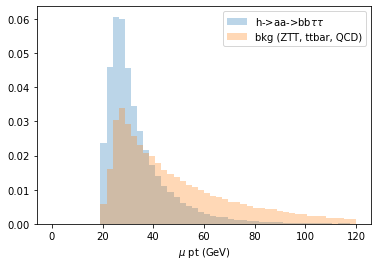

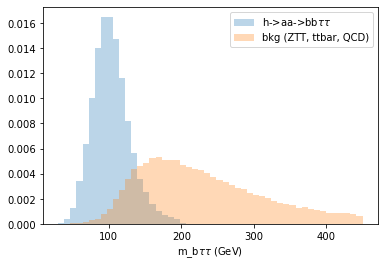

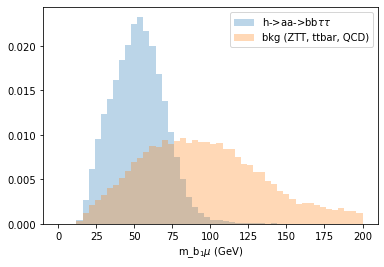

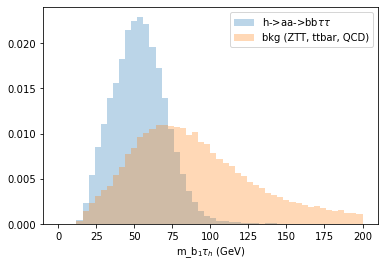

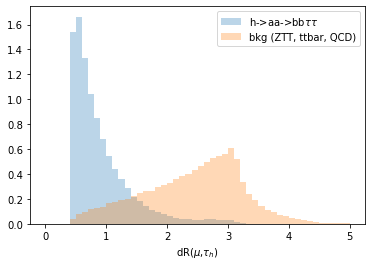

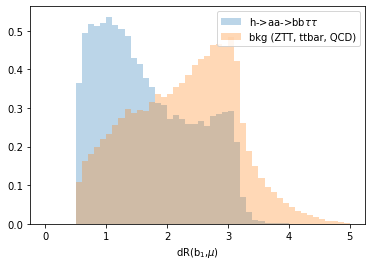

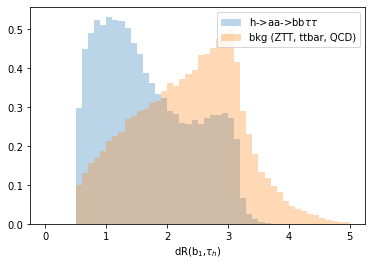

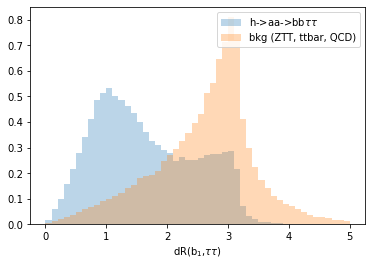

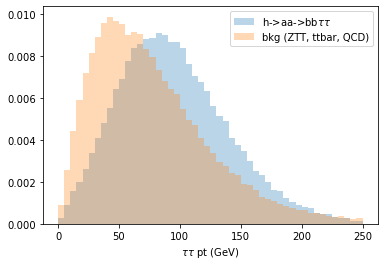

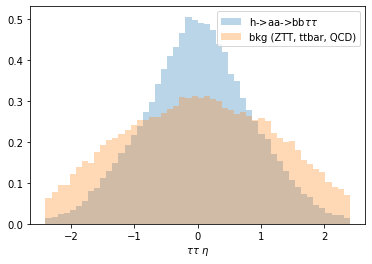

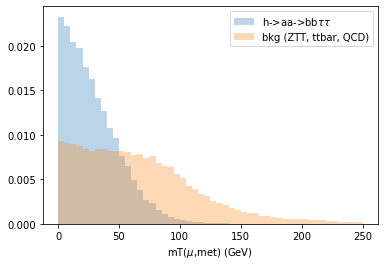

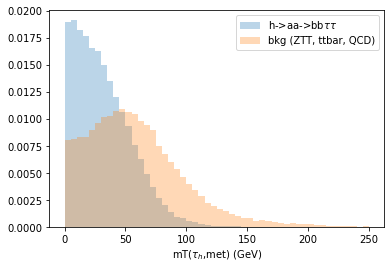

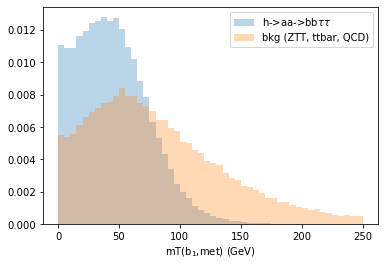

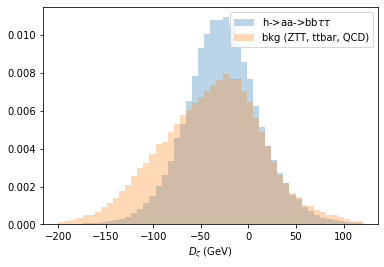

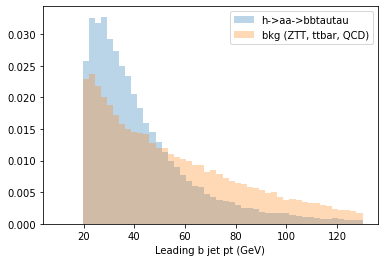

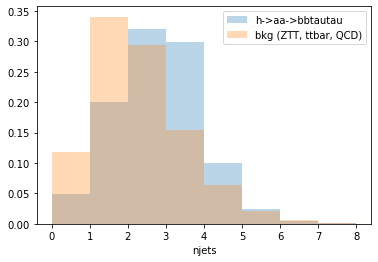

In [8]:
pyplot.hist(sig_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\mu$ pt (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$\\tau\\tau$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_1$$\mu$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_1$$\\tau_h$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR($\mu$,$\\tau_h$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\mu$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\\tau_h$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\\tau\\tau$)')
pyplot.show()

pyplot.hist(sig_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\\tau\\tau$ pt (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\\tau\\tau$ $\eta$')
pyplot.show()

pyplot.hist(sig_allyears['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT($\mu$,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT($\\tau_h$,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT(b$_1$,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$D_\zeta$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(df_bkg['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('Leading b jet pt (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['njets'], density = 1, range = (0,8), bins = 8, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(df_bkg['njets'], density = 1, range = (0,8), bins = 8, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['njets'], density = 1, range = (0,8), bins = 8, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['njets'], density = 1, range = (0,8), bins = 8, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['njets'], density = 1, range = (0,8), bins = 8, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('njets')
pyplot.show()

## Input data pre-processing

In [9]:
# convert to numpy arrays
dataset = df_MC.values
X = dataset[:,0:(dataset.shape[1]-1)]
Y = dataset[:,dataset.shape[1]-1]
Y = Y.reshape(Y.shape[0],1)

#dataset_obs = df_obs.values
#X_obs = dataset_obs[:,0:(dataset_obs.shape[1])]

# give train/val/test partition ratios
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 1 - train_ratio - val_ratio

# randomly partition data set into train/val/test sets with given ratios
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size = test_ratio, random_state=15)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = val_ratio/(val_ratio+train_ratio), random_state=15)

# standardize feature variables
# only based on means and stds in train_val set, should apply this only scaler to all other sets
# think of the transformation in phase space
scaler = StandardScaler().fit(X_train_val)
X_train_val = scaler.transform(X_train_val)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
#X_obs = scaler.transform(X_obs)

# print input data shapes
print("\nPartition the data set into train/val/test: %.2f/%.2f/%.2f" % (train_ratio, val_ratio, test_ratio))
print("X_train.shape: " + str(X_train.shape))
print("Y_train.shape: " + str(Y_train.shape))
print("X_val.shape: " + str(X_val.shape))
print("Y_val.shape: " + str(Y_val.shape))
print("X_test.shape: " + str(X_test.shape))
print("Y_test.shape: " + str(Y_test.shape))
#print("\nX_obs.shape: " + str(X_obs.shape))

# print ratio of signal/background examples in each set
train_sig = np.count_nonzero(Y_train)
train_bkg = np.count_nonzero(Y_train == 0)
train_sig_perc = 100*train_sig/(train_sig+train_bkg)
train_bkg_perc = 100*train_bkg/(train_sig+train_bkg)
val_sig = np.count_nonzero(Y_val)
val_bkg = np.count_nonzero(Y_val == 0)
val_sig_perc = 100*val_sig/(val_sig+val_bkg)
val_bkg_perc = 100*val_bkg/(val_sig+val_bkg)
test_sig = np.count_nonzero(Y_test)
test_bkg = np.count_nonzero(Y_test == 0)
test_sig_perc = 100*test_sig/(test_sig+test_bkg)
test_bkg_perc = 100*test_bkg/(test_sig+test_bkg)

total_sig = train_sig + val_sig + test_sig
total_bkg = train_bkg + val_bkg + test_bkg
total_sig_perc = 100*total_sig/(total_sig+total_bkg)
total_bkg_perc = 100*total_bkg/(total_sig+total_bkg)
print("\nTotal number of sig/bkg examples: %d/%d (%.2f%%/%.2f%%)" % (total_sig, total_bkg, total_sig_perc, total_bkg_perc))

print("\nNumber of sig/bkg examples in each set:")
print("train : %d/%d (%.1f%%/%.1f%%)" % (train_sig, train_bkg, train_sig_perc, train_bkg_perc))
print("val   : %d/%d (%.1f%%/%.1f%%)" % (val_sig, val_bkg, val_sig_perc, val_bkg_perc))
print("test  : %d/%d (%.1f%%/%.1f%%)" % (test_sig, test_bkg, test_sig_perc, test_bkg_perc))


Partition the data set into train/val/test: 0.60/0.20/0.20
X_train.shape: (69531, 16)
Y_train.shape: (69531, 1)
X_val.shape: (23177, 16)
Y_val.shape: (23177, 1)
X_test.shape: (23178, 16)
Y_test.shape: (23178, 1)

Total number of sig/bkg examples: 57943/57943 (50.00%/50.00%)

Number of sig/bkg examples in each set:
train : 34732/34799 (50.0%/50.0%)
val   : 11655/11522 (50.3%/49.7%)
test  : 11556/11622 (49.9%/50.1%)


## DNN Hyperparameters searching

In [10]:
# define model for the search
def hypermodel(hp):
    hp_model = keras.Sequential()
    hp_model.add(keras.layers.Input(shape = (X.shape[1],)))
    
    hp_model.add(keras.layers.Dense(units = hp.Int('units_1',
                                                   min_value = 20,
                                                   max_value = 60,
                                                   step = 2),
                                    activation = 'relu',
                                    kernel_initializer = glorot_uniform(seed=1)))
    
    hp_model.add(keras.layers.Dropout(rate = hp.Float('rate_1',
                                                      min_value = 0.2,
                                                      max_value = 0.5,
                                                      default = 0.2,
                                                      step = 0.1),
                                      seed = 10))
    
    hp_model.add(keras.layers.Dense(units = hp.Int('units_2',
                                                   min_value = 20,
                                                   max_value = 60,
                                                   step = 2),
                                    activation = 'relu',
                                    kernel_initializer = glorot_uniform(seed=1)))
    
    hp_model.add(keras.layers.Dropout(rate = hp.Float('rate_2',
                                                      min_value = 0.2,
                                                      max_value = 0.5,
                                                      default = 0.2,
                                                      step = 0.1),
                                      seed = 10))

    hp_model.add(keras.layers.Dense(units = 1, activation = 'sigmoid', kernel_initializer = glorot_uniform(seed=1)))
    hp_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return hp_model

In [11]:
# define tuner model
tuner = Hyperband(hypermodel,
                  objective = 'val_accuracy',
                  max_epochs = 20,
                  factor = 3, #number of models to train in a bracket = 1+log_factor(max_epochs)
                  hyperband_iterations = 2, #number of times to iterate over the full Hyperband algorithm
                  seed = 10,
                  directory = 'hypertuning',
                  project_name = 'tune',
                  overwrite = True)

2021-04-11 15:17:35.217108: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-04-11 15:17:35.218604: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [12]:
# run the search
tuner.search(X_train, Y_train, epochs = 20, validation_data = (X_val,Y_val), batch_size = 256)

Train on 69531 samples, validate on 23177 samples
Epoch 1/3
69531/69531 [==============================] - ETA: 3:17 - loss: 0.7334 - accuracy: 0.51 - ETA: 25s - loss: 0.6731 - accuracy: 0.5703 - ETA: 13s - loss: 0.6217 - accuracy: 0.639 - ETA: 8s - loss: 0.5705 - accuracy: 0.699 - ETA: 6s - loss: 0.5305 - accuracy: 0.73 - ETA: 5s - loss: 0.4976 - accuracy: 0.76 - ETA: 4s - loss: 0.4684 - accuracy: 0.78 - ETA: 4s - loss: 0.4415 - accuracy: 0.80 - ETA: 3s - loss: 0.4178 - accuracy: 0.81 - ETA: 3s - loss: 0.3980 - accuracy: 0.82 - ETA: 2s - loss: 0.3815 - accuracy: 0.83 - ETA: 2s - loss: 0.3663 - accuracy: 0.84 - ETA: 2s - loss: 0.3523 - accuracy: 0.85 - ETA: 2s - loss: 0.3406 - accuracy: 0.85 - ETA: 2s - loss: 0.3273 - accuracy: 0.86 - ETA: 1s - loss: 0.3168 - accuracy: 0.86 - ETA: 1s - loss: 0.3080 - accuracy: 0.87 - ETA: 1s - loss: 0.2992 - accuracy: 0.87 - ETA: 1s - loss: 0.2922 - accuracy: 0.88 - ETA: 1s - loss: 0.2850 - accuracy: 0.88 - ETA: 1s - loss: 0.2779 - accuracy: 0.88 - ETA

Train on 69531 samples, validate on 23177 samples
Epoch 1/3
69531/69531 [==============================] - ETA: 2:21 - loss: 0.6738 - accuracy: 0.54 - ETA: 14s - loss: 0.6498 - accuracy: 0.5734 - ETA: 8s - loss: 0.6247 - accuracy: 0.612 - ETA: 5s - loss: 0.5979 - accuracy: 0.65 - ETA: 4s - loss: 0.5752 - accuracy: 0.68 - ETA: 3s - loss: 0.5556 - accuracy: 0.70 - ETA: 3s - loss: 0.5355 - accuracy: 0.72 - ETA: 2s - loss: 0.5154 - accuracy: 0.74 - ETA: 2s - loss: 0.4982 - accuracy: 0.75 - ETA: 2s - loss: 0.4808 - accuracy: 0.76 - ETA: 2s - loss: 0.4648 - accuracy: 0.77 - ETA: 2s - loss: 0.4609 - accuracy: 0.77 - ETA: 1s - loss: 0.4495 - accuracy: 0.78 - ETA: 1s - loss: 0.4398 - accuracy: 0.79 - ETA: 1s - loss: 0.4259 - accuracy: 0.80 - ETA: 1s - loss: 0.4129 - accuracy: 0.80 - ETA: 1s - loss: 0.4011 - accuracy: 0.81 - ETA: 1s - loss: 0.3905 - accuracy: 0.82 - ETA: 1s - loss: 0.3808 - accuracy: 0.82 - ETA: 1s - loss: 0.3723 - accuracy: 0.83 - ETA: 0s - loss: 0.3642 - accuracy: 0.83 - ETA: 

Train on 69531 samples, validate on 23177 samples
Epoch 1/3
69531/69531 [==============================] - ETA: 2:17 - loss: 0.7395 - accuracy: 0.47 - ETA: 16s - loss: 0.6947 - accuracy: 0.4822 - ETA: 9s - loss: 0.6576 - accuracy: 0.532 - ETA: 6s - loss: 0.6228 - accuracy: 0.59 - ETA: 5s - loss: 0.6021 - accuracy: 0.62 - ETA: 5s - loss: 0.5738 - accuracy: 0.66 - ETA: 4s - loss: 0.5442 - accuracy: 0.70 - ETA: 3s - loss: 0.5178 - accuracy: 0.72 - ETA: 3s - loss: 0.4937 - accuracy: 0.74 - ETA: 3s - loss: 0.4753 - accuracy: 0.75 - ETA: 2s - loss: 0.4565 - accuracy: 0.77 - ETA: 2s - loss: 0.4375 - accuracy: 0.78 - ETA: 2s - loss: 0.4234 - accuracy: 0.79 - ETA: 2s - loss: 0.4077 - accuracy: 0.80 - ETA: 1s - loss: 0.3945 - accuracy: 0.81 - ETA: 1s - loss: 0.3846 - accuracy: 0.81 - ETA: 1s - loss: 0.3733 - accuracy: 0.82 - ETA: 1s - loss: 0.3621 - accuracy: 0.83 - ETA: 1s - loss: 0.3530 - accuracy: 0.83 - ETA: 1s - loss: 0.3433 - accuracy: 0.84 - ETA: 1s - loss: 0.3346 - accuracy: 0.84 - ETA: 

Train on 69531 samples, validate on 23177 samples
Epoch 1/3
69531/69531 [==============================] - ETA: 2:16 - loss: 0.7084 - accuracy: 0.52 - ETA: 16s - loss: 0.6415 - accuracy: 0.6029 - ETA: 9s - loss: 0.5877 - accuracy: 0.668 - ETA: 7s - loss: 0.5456 - accuracy: 0.70 - ETA: 5s - loss: 0.5076 - accuracy: 0.74 - ETA: 4s - loss: 0.4748 - accuracy: 0.76 - ETA: 4s - loss: 0.4506 - accuracy: 0.78 - ETA: 3s - loss: 0.4272 - accuracy: 0.80 - ETA: 3s - loss: 0.4078 - accuracy: 0.81 - ETA: 2s - loss: 0.3910 - accuracy: 0.82 - ETA: 2s - loss: 0.3753 - accuracy: 0.83 - ETA: 2s - loss: 0.3609 - accuracy: 0.84 - ETA: 2s - loss: 0.3485 - accuracy: 0.84 - ETA: 2s - loss: 0.3367 - accuracy: 0.85 - ETA: 2s - loss: 0.3273 - accuracy: 0.85 - ETA: 1s - loss: 0.3173 - accuracy: 0.86 - ETA: 1s - loss: 0.3100 - accuracy: 0.86 - ETA: 1s - loss: 0.3030 - accuracy: 0.87 - ETA: 1s - loss: 0.2968 - accuracy: 0.87 - ETA: 1s - loss: 0.2902 - accuracy: 0.87 - ETA: 1s - loss: 0.2842 - accuracy: 0.88 - ETA: 

Train on 69531 samples, validate on 23177 samples
Epoch 1/3
69531/69531 [==============================] - ETA: 2:17 - loss: 0.7658 - accuracy: 0.43 - ETA: 16s - loss: 0.7038 - accuracy: 0.5295 - ETA: 9s - loss: 0.6680 - accuracy: 0.577 - ETA: 6s - loss: 0.6240 - accuracy: 0.63 - ETA: 4s - loss: 0.5870 - accuracy: 0.68 - ETA: 3s - loss: 0.5512 - accuracy: 0.71 - ETA: 3s - loss: 0.5205 - accuracy: 0.73 - ETA: 3s - loss: 0.4947 - accuracy: 0.75 - ETA: 2s - loss: 0.4711 - accuracy: 0.77 - ETA: 2s - loss: 0.4493 - accuracy: 0.78 - ETA: 2s - loss: 0.4302 - accuracy: 0.80 - ETA: 2s - loss: 0.4155 - accuracy: 0.80 - ETA: 1s - loss: 0.4019 - accuracy: 0.81 - ETA: 1s - loss: 0.3877 - accuracy: 0.82 - ETA: 1s - loss: 0.3752 - accuracy: 0.83 - ETA: 1s - loss: 0.3640 - accuracy: 0.83 - ETA: 1s - loss: 0.3521 - accuracy: 0.84 - ETA: 1s - loss: 0.3428 - accuracy: 0.85 - ETA: 1s - loss: 0.3347 - accuracy: 0.85 - ETA: 0s - loss: 0.3258 - accuracy: 0.85 - ETA: 0s - loss: 0.3181 - accuracy: 0.86 - ETA: 

Train on 69531 samples, validate on 23177 samples
Epoch 1/3
69531/69531 [==============================] - ETA: 2:16 - loss: 0.8048 - accuracy: 0.51 - ETA: 14s - loss: 0.6980 - accuracy: 0.6016 - ETA: 8s - loss: 0.6473 - accuracy: 0.641 - ETA: 5s - loss: 0.5979 - accuracy: 0.68 - ETA: 4s - loss: 0.5558 - accuracy: 0.72 - ETA: 3s - loss: 0.5196 - accuracy: 0.75 - ETA: 3s - loss: 0.4873 - accuracy: 0.77 - ETA: 2s - loss: 0.4648 - accuracy: 0.78 - ETA: 2s - loss: 0.4489 - accuracy: 0.79 - ETA: 2s - loss: 0.4360 - accuracy: 0.80 - ETA: 2s - loss: 0.4203 - accuracy: 0.81 - ETA: 2s - loss: 0.4047 - accuracy: 0.82 - ETA: 2s - loss: 0.3890 - accuracy: 0.83 - ETA: 1s - loss: 0.3753 - accuracy: 0.83 - ETA: 1s - loss: 0.3609 - accuracy: 0.84 - ETA: 1s - loss: 0.3502 - accuracy: 0.85 - ETA: 1s - loss: 0.3394 - accuracy: 0.85 - ETA: 1s - loss: 0.3300 - accuracy: 0.86 - ETA: 1s - loss: 0.3204 - accuracy: 0.86 - ETA: 1s - loss: 0.3095 - accuracy: 0.87 - ETA: 0s - loss: 0.3019 - accuracy: 0.87 - ETA: 

Train on 69531 samples, validate on 23177 samples
Epoch 1/3
69531/69531 [==============================] - ETA: 2:24 - loss: 0.6808 - accuracy: 0.54 - ETA: 17s - loss: 0.6510 - accuracy: 0.6098 - ETA: 9s - loss: 0.6187 - accuracy: 0.649 - ETA: 6s - loss: 0.5848 - accuracy: 0.69 - ETA: 5s - loss: 0.5519 - accuracy: 0.72 - ETA: 4s - loss: 0.5252 - accuracy: 0.74 - ETA: 3s - loss: 0.4992 - accuracy: 0.76 - ETA: 3s - loss: 0.4726 - accuracy: 0.78 - ETA: 3s - loss: 0.4563 - accuracy: 0.79 - ETA: 2s - loss: 0.4391 - accuracy: 0.80 - ETA: 2s - loss: 0.4183 - accuracy: 0.81 - ETA: 2s - loss: 0.4026 - accuracy: 0.82 - ETA: 2s - loss: 0.3879 - accuracy: 0.83 - ETA: 1s - loss: 0.3742 - accuracy: 0.84 - ETA: 1s - loss: 0.3666 - accuracy: 0.84 - ETA: 1s - loss: 0.3545 - accuracy: 0.85 - ETA: 1s - loss: 0.3448 - accuracy: 0.85 - ETA: 1s - loss: 0.3345 - accuracy: 0.86 - ETA: 1s - loss: 0.3244 - accuracy: 0.86 - ETA: 1s - loss: 0.3162 - accuracy: 0.87 - ETA: 1s - loss: 0.3085 - accuracy: 0.87 - ETA: 

Train on 69531 samples, validate on 23177 samples
Epoch 1/3
69531/69531 [==============================] - ETA: 2:17 - loss: 0.6779 - accuracy: 0.56 - ETA: 14s - loss: 0.6345 - accuracy: 0.6500 - ETA: 8s - loss: 0.5783 - accuracy: 0.722 - ETA: 6s - loss: 0.5384 - accuracy: 0.76 - ETA: 4s - loss: 0.5044 - accuracy: 0.78 - ETA: 4s - loss: 0.4739 - accuracy: 0.80 - ETA: 3s - loss: 0.4450 - accuracy: 0.82 - ETA: 3s - loss: 0.4203 - accuracy: 0.83 - ETA: 2s - loss: 0.3973 - accuracy: 0.84 - ETA: 2s - loss: 0.3792 - accuracy: 0.85 - ETA: 2s - loss: 0.3638 - accuracy: 0.85 - ETA: 2s - loss: 0.3490 - accuracy: 0.86 - ETA: 1s - loss: 0.3361 - accuracy: 0.87 - ETA: 1s - loss: 0.3225 - accuracy: 0.87 - ETA: 1s - loss: 0.3121 - accuracy: 0.88 - ETA: 1s - loss: 0.3033 - accuracy: 0.88 - ETA: 1s - loss: 0.2962 - accuracy: 0.88 - ETA: 1s - loss: 0.2891 - accuracy: 0.88 - ETA: 1s - loss: 0.2831 - accuracy: 0.89 - ETA: 1s - loss: 0.2762 - accuracy: 0.89 - ETA: 0s - loss: 0.2711 - accuracy: 0.89 - ETA: 

Train on 69531 samples, validate on 23177 samples
Epoch 1/3
69531/69531 [==============================] - ETA: 2:16 - loss: 0.6885 - accuracy: 0.49 - ETA: 14s - loss: 0.6317 - accuracy: 0.5941 - ETA: 8s - loss: 0.5898 - accuracy: 0.655 - ETA: 6s - loss: 0.5565 - accuracy: 0.69 - ETA: 4s - loss: 0.5237 - accuracy: 0.73 - ETA: 4s - loss: 0.4933 - accuracy: 0.76 - ETA: 3s - loss: 0.4673 - accuracy: 0.78 - ETA: 3s - loss: 0.4424 - accuracy: 0.79 - ETA: 2s - loss: 0.4214 - accuracy: 0.80 - ETA: 2s - loss: 0.3994 - accuracy: 0.82 - ETA: 2s - loss: 0.3790 - accuracy: 0.83 - ETA: 2s - loss: 0.3603 - accuracy: 0.84 - ETA: 1s - loss: 0.3450 - accuracy: 0.85 - ETA: 1s - loss: 0.3323 - accuracy: 0.85 - ETA: 1s - loss: 0.3199 - accuracy: 0.86 - ETA: 1s - loss: 0.3108 - accuracy: 0.86 - ETA: 1s - loss: 0.3010 - accuracy: 0.87 - ETA: 1s - loss: 0.2933 - accuracy: 0.87 - ETA: 1s - loss: 0.2860 - accuracy: 0.87 - ETA: 1s - loss: 0.2805 - accuracy: 0.88 - ETA: 0s - loss: 0.2736 - accuracy: 0.88 - ETA: 

Train on 69531 samples, validate on 23177 samples
Epoch 1/3
69531/69531 [==============================] - ETA: 2:17 - loss: 0.6495 - accuracy: 0.57 - ETA: 16s - loss: 0.5891 - accuracy: 0.6589 - ETA: 9s - loss: 0.5452 - accuracy: 0.723 - ETA: 6s - loss: 0.5012 - accuracy: 0.77 - ETA: 5s - loss: 0.4659 - accuracy: 0.80 - ETA: 4s - loss: 0.4358 - accuracy: 0.82 - ETA: 3s - loss: 0.4085 - accuracy: 0.83 - ETA: 3s - loss: 0.3838 - accuracy: 0.84 - ETA: 3s - loss: 0.3632 - accuracy: 0.85 - ETA: 2s - loss: 0.3442 - accuracy: 0.86 - ETA: 2s - loss: 0.3267 - accuracy: 0.87 - ETA: 2s - loss: 0.3143 - accuracy: 0.87 - ETA: 2s - loss: 0.3015 - accuracy: 0.88 - ETA: 1s - loss: 0.2928 - accuracy: 0.88 - ETA: 1s - loss: 0.2828 - accuracy: 0.89 - ETA: 1s - loss: 0.2739 - accuracy: 0.89 - ETA: 1s - loss: 0.2664 - accuracy: 0.89 - ETA: 1s - loss: 0.2602 - accuracy: 0.90 - ETA: 1s - loss: 0.2538 - accuracy: 0.90 - ETA: 1s - loss: 0.2481 - accuracy: 0.90 - ETA: 1s - loss: 0.2432 - accuracy: 0.90 - ETA: 

Train on 69531 samples, validate on 23177 samples
Epoch 1/3
69531/69531 [==============================] - ETA: 2:17 - loss: 0.7029 - accuracy: 0.52 - ETA: 18s - loss: 0.6867 - accuracy: 0.5659 - ETA: 10s - loss: 0.6402 - accuracy: 0.634 - ETA: 7s - loss: 0.5992 - accuracy: 0.685 - ETA: 5s - loss: 0.5600 - accuracy: 0.72 - ETA: 4s - loss: 0.5235 - accuracy: 0.75 - ETA: 3s - loss: 0.4919 - accuracy: 0.77 - ETA: 3s - loss: 0.4623 - accuracy: 0.79 - ETA: 3s - loss: 0.4399 - accuracy: 0.80 - ETA: 2s - loss: 0.4171 - accuracy: 0.82 - ETA: 2s - loss: 0.3965 - accuracy: 0.83 - ETA: 2s - loss: 0.3810 - accuracy: 0.83 - ETA: 2s - loss: 0.3658 - accuracy: 0.84 - ETA: 2s - loss: 0.3516 - accuracy: 0.85 - ETA: 1s - loss: 0.3382 - accuracy: 0.85 - ETA: 1s - loss: 0.3269 - accuracy: 0.86 - ETA: 1s - loss: 0.3181 - accuracy: 0.86 - ETA: 1s - loss: 0.3100 - accuracy: 0.87 - ETA: 1s - loss: 0.3034 - accuracy: 0.87 - ETA: 1s - loss: 0.2964 - accuracy: 0.87 - ETA: 1s - loss: 0.2898 - accuracy: 0.88 - ETA

Train on 69531 samples, validate on 23177 samples
Epoch 1/3
69531/69531 [==============================] - ETA: 2:17 - loss: 0.7123 - accuracy: 0.54 - ETA: 16s - loss: 0.6479 - accuracy: 0.6445 - ETA: 9s - loss: 0.5847 - accuracy: 0.723 - ETA: 7s - loss: 0.5391 - accuracy: 0.76 - ETA: 5s - loss: 0.4956 - accuracy: 0.79 - ETA: 4s - loss: 0.4560 - accuracy: 0.81 - ETA: 4s - loss: 0.4265 - accuracy: 0.83 - ETA: 3s - loss: 0.4005 - accuracy: 0.84 - ETA: 3s - loss: 0.3797 - accuracy: 0.85 - ETA: 3s - loss: 0.3628 - accuracy: 0.86 - ETA: 2s - loss: 0.3470 - accuracy: 0.86 - ETA: 2s - loss: 0.3316 - accuracy: 0.87 - ETA: 2s - loss: 0.3171 - accuracy: 0.88 - ETA: 2s - loss: 0.3062 - accuracy: 0.88 - ETA: 2s - loss: 0.2958 - accuracy: 0.88 - ETA: 1s - loss: 0.2855 - accuracy: 0.89 - ETA: 1s - loss: 0.2776 - accuracy: 0.89 - ETA: 1s - loss: 0.2699 - accuracy: 0.89 - ETA: 1s - loss: 0.2635 - accuracy: 0.90 - ETA: 1s - loss: 0.2584 - accuracy: 0.90 - ETA: 1s - loss: 0.2526 - accuracy: 0.90 - ETA: 

Train on 69531 samples, validate on 23177 samples
Epoch 4/7
69531/69531 [==============================] - ETA: 2:18 - loss: 0.7631 - accuracy: 0.39 - ETA: 16s - loss: 0.6799 - accuracy: 0.5503 - ETA: 9s - loss: 0.6083 - accuracy: 0.666 - ETA: 6s - loss: 0.5427 - accuracy: 0.73 - ETA: 5s - loss: 0.4949 - accuracy: 0.77 - ETA: 4s - loss: 0.4548 - accuracy: 0.80 - ETA: 4s - loss: 0.4220 - accuracy: 0.82 - ETA: 3s - loss: 0.3954 - accuracy: 0.83 - ETA: 3s - loss: 0.3724 - accuracy: 0.84 - ETA: 3s - loss: 0.3529 - accuracy: 0.85 - ETA: 2s - loss: 0.3355 - accuracy: 0.86 - ETA: 2s - loss: 0.3211 - accuracy: 0.87 - ETA: 2s - loss: 0.3073 - accuracy: 0.87 - ETA: 2s - loss: 0.2947 - accuracy: 0.88 - ETA: 2s - loss: 0.2855 - accuracy: 0.88 - ETA: 1s - loss: 0.2782 - accuracy: 0.89 - ETA: 1s - loss: 0.2703 - accuracy: 0.89 - ETA: 1s - loss: 0.2621 - accuracy: 0.89 - ETA: 1s - loss: 0.2558 - accuracy: 0.89 - ETA: 1s - loss: 0.2495 - accuracy: 0.90 - ETA: 1s - loss: 0.2431 - accuracy: 0.90 - ETA: 

Train on 69531 samples, validate on 23177 samples
Epoch 4/7
69531/69531 [==============================] - ETA: 2:17 - loss: 0.7524 - accuracy: 0.50 - ETA: 13s - loss: 0.6972 - accuracy: 0.5494 - ETA: 7s - loss: 0.6578 - accuracy: 0.603 - ETA: 5s - loss: 0.6237 - accuracy: 0.65 - ETA: 4s - loss: 0.5927 - accuracy: 0.69 - ETA: 3s - loss: 0.5625 - accuracy: 0.72 - ETA: 3s - loss: 0.5319 - accuracy: 0.74 - ETA: 2s - loss: 0.5061 - accuracy: 0.76 - ETA: 2s - loss: 0.4809 - accuracy: 0.78 - ETA: 2s - loss: 0.4580 - accuracy: 0.79 - ETA: 2s - loss: 0.4367 - accuracy: 0.81 - ETA: 1s - loss: 0.4177 - accuracy: 0.82 - ETA: 1s - loss: 0.4002 - accuracy: 0.83 - ETA: 1s - loss: 0.3857 - accuracy: 0.83 - ETA: 1s - loss: 0.3721 - accuracy: 0.84 - ETA: 1s - loss: 0.3609 - accuracy: 0.84 - ETA: 1s - loss: 0.3495 - accuracy: 0.85 - ETA: 1s - loss: 0.3374 - accuracy: 0.86 - ETA: 0s - loss: 0.3292 - accuracy: 0.86 - ETA: 0s - loss: 0.3201 - accuracy: 0.86 - ETA: 0s - loss: 0.3128 - accuracy: 0.87 - ETA: 

Train on 69531 samples, validate on 23177 samples
Epoch 4/7
69531/69531 [==============================] - ETA: 2:17 - loss: 0.7422 - accuracy: 0.51 - ETA: 16s - loss: 0.6635 - accuracy: 0.6150 - ETA: 9s - loss: 0.6029 - accuracy: 0.683 - ETA: 6s - loss: 0.5475 - accuracy: 0.73 - ETA: 5s - loss: 0.5028 - accuracy: 0.76 - ETA: 4s - loss: 0.4659 - accuracy: 0.79 - ETA: 3s - loss: 0.4337 - accuracy: 0.81 - ETA: 3s - loss: 0.4098 - accuracy: 0.82 - ETA: 3s - loss: 0.3873 - accuracy: 0.83 - ETA: 2s - loss: 0.3665 - accuracy: 0.84 - ETA: 2s - loss: 0.3483 - accuracy: 0.85 - ETA: 2s - loss: 0.3326 - accuracy: 0.86 - ETA: 2s - loss: 0.3197 - accuracy: 0.86 - ETA: 1s - loss: 0.3086 - accuracy: 0.87 - ETA: 1s - loss: 0.2984 - accuracy: 0.87 - ETA: 1s - loss: 0.2895 - accuracy: 0.88 - ETA: 1s - loss: 0.2827 - accuracy: 0.88 - ETA: 1s - loss: 0.2748 - accuracy: 0.88 - ETA: 1s - loss: 0.2678 - accuracy: 0.89 - ETA: 1s - loss: 0.2616 - accuracy: 0.89 - ETA: 1s - loss: 0.2558 - accuracy: 0.89 - ETA: 

Train on 69531 samples, validate on 23177 samples
Epoch 4/7
69531/69531 [==============================] - ETA: 2:17 - loss: 0.6880 - accuracy: 0.53 - ETA: 16s - loss: 0.6120 - accuracy: 0.6567 - ETA: 9s - loss: 0.5687 - accuracy: 0.720 - ETA: 6s - loss: 0.5361 - accuracy: 0.75 - ETA: 5s - loss: 0.5005 - accuracy: 0.78 - ETA: 4s - loss: 0.4747 - accuracy: 0.80 - ETA: 4s - loss: 0.4513 - accuracy: 0.81 - ETA: 3s - loss: 0.4257 - accuracy: 0.83 - ETA: 3s - loss: 0.4062 - accuracy: 0.84 - ETA: 2s - loss: 0.3887 - accuracy: 0.84 - ETA: 2s - loss: 0.3694 - accuracy: 0.85 - ETA: 2s - loss: 0.3519 - accuracy: 0.86 - ETA: 2s - loss: 0.3371 - accuracy: 0.87 - ETA: 2s - loss: 0.3255 - accuracy: 0.87 - ETA: 1s - loss: 0.3164 - accuracy: 0.87 - ETA: 1s - loss: 0.3043 - accuracy: 0.88 - ETA: 1s - loss: 0.2955 - accuracy: 0.88 - ETA: 1s - loss: 0.2873 - accuracy: 0.89 - ETA: 1s - loss: 0.2795 - accuracy: 0.89 - ETA: 1s - loss: 0.2728 - accuracy: 0.89 - ETA: 1s - loss: 0.2667 - accuracy: 0.89 - ETA: 

Train on 69531 samples, validate on 23177 samples
Epoch 8/20
69531/69531 [==============================] - ETA: 2:18 - loss: 0.6811 - accuracy: 0.59 - ETA: 18s - loss: 0.6180 - accuracy: 0.7104 - ETA: 9s - loss: 0.5580 - accuracy: 0.791 - ETA: 7s - loss: 0.5086 - accuracy: 0.82 - ETA: 5s - loss: 0.4594 - accuracy: 0.85 - ETA: 4s - loss: 0.4257 - accuracy: 0.86 - ETA: 4s - loss: 0.3968 - accuracy: 0.87 - ETA: 3s - loss: 0.3717 - accuracy: 0.88 - ETA: 3s - loss: 0.3502 - accuracy: 0.88 - ETA: 3s - loss: 0.3317 - accuracy: 0.89 - ETA: 2s - loss: 0.3178 - accuracy: 0.89 - ETA: 2s - loss: 0.3101 - accuracy: 0.90 - ETA: 2s - loss: 0.2971 - accuracy: 0.90 - ETA: 2s - loss: 0.2865 - accuracy: 0.90 - ETA: 2s - loss: 0.2762 - accuracy: 0.91 - ETA: 2s - loss: 0.2669 - accuracy: 0.91 - ETA: 1s - loss: 0.2597 - accuracy: 0.91 - ETA: 1s - loss: 0.2533 - accuracy: 0.91 - ETA: 1s - loss: 0.2469 - accuracy: 0.91 - ETA: 1s - loss: 0.2411 - accuracy: 0.92 - ETA: 1s - loss: 0.2368 - accuracy: 0.92 - ETA:

69531/69531 [==============================] - ETA: 1s - loss: 0.1136 - accuracy: 0.96 - ETA: 1s - loss: 0.1102 - accuracy: 0.96 - ETA: 1s - loss: 0.1058 - accuracy: 0.96 - ETA: 1s - loss: 0.1066 - accuracy: 0.96 - ETA: 1s - loss: 0.1116 - accuracy: 0.96 - ETA: 1s - loss: 0.1117 - accuracy: 0.96 - ETA: 1s - loss: 0.1120 - accuracy: 0.96 - ETA: 1s - loss: 0.1125 - accuracy: 0.96 - ETA: 1s - loss: 0.1107 - accuracy: 0.96 - ETA: 1s - loss: 0.1107 - accuracy: 0.96 - ETA: 1s - loss: 0.1103 - accuracy: 0.96 - ETA: 1s - loss: 0.1110 - accuracy: 0.96 - ETA: 1s - loss: 0.1103 - accuracy: 0.96 - ETA: 1s - loss: 0.1105 - accuracy: 0.96 - ETA: 1s - loss: 0.1106 - accuracy: 0.96 - ETA: 1s - loss: 0.1108 - accuracy: 0.96 - ETA: 1s - loss: 0.1124 - accuracy: 0.95 - ETA: 1s - loss: 0.1121 - accuracy: 0.95 - ETA: 0s - loss: 0.1127 - accuracy: 0.95 - ETA: 0s - loss: 0.1129 - accuracy: 0.95 - ETA: 0s - loss: 0.1133 - accuracy: 0.95 - ETA: 0s - loss: 0.1129 - accuracy: 0.95 - ETA: 0s - loss: 0.1121 - accu

69531/69531 [==============================] - ETA: 2s - loss: 0.1324 - accuracy: 0.94 - ETA: 1s - loss: 0.1190 - accuracy: 0.95 - ETA: 1s - loss: 0.1100 - accuracy: 0.95 - ETA: 1s - loss: 0.1133 - accuracy: 0.95 - ETA: 1s - loss: 0.1152 - accuracy: 0.95 - ETA: 1s - loss: 0.1110 - accuracy: 0.95 - ETA: 1s - loss: 0.1108 - accuracy: 0.95 - ETA: 1s - loss: 0.1128 - accuracy: 0.95 - ETA: 1s - loss: 0.1127 - accuracy: 0.95 - ETA: 1s - loss: 0.1124 - accuracy: 0.95 - ETA: 1s - loss: 0.1119 - accuracy: 0.95 - ETA: 1s - loss: 0.1102 - accuracy: 0.95 - ETA: 1s - loss: 0.1103 - accuracy: 0.95 - ETA: 1s - loss: 0.1085 - accuracy: 0.96 - ETA: 1s - loss: 0.1098 - accuracy: 0.96 - ETA: 1s - loss: 0.1088 - accuracy: 0.96 - ETA: 1s - loss: 0.1081 - accuracy: 0.96 - ETA: 1s - loss: 0.1081 - accuracy: 0.96 - ETA: 0s - loss: 0.1082 - accuracy: 0.96 - ETA: 0s - loss: 0.1084 - accuracy: 0.96 - ETA: 0s - loss: 0.1086 - accuracy: 0.96 - ETA: 0s - loss: 0.1092 - accuracy: 0.95 - ETA: 0s - loss: 0.1093 - accu

69531/69531 [==============================] - ETA: 2s - loss: 0.1166 - accuracy: 0.94 - ETA: 1s - loss: 0.1086 - accuracy: 0.95 - ETA: 1s - loss: 0.1125 - accuracy: 0.95 - ETA: 1s - loss: 0.1068 - accuracy: 0.96 - ETA: 1s - loss: 0.1054 - accuracy: 0.96 - ETA: 1s - loss: 0.1047 - accuracy: 0.96 - ETA: 1s - loss: 0.1075 - accuracy: 0.96 - ETA: 1s - loss: 0.1060 - accuracy: 0.96 - ETA: 1s - loss: 0.1052 - accuracy: 0.96 - ETA: 1s - loss: 0.1039 - accuracy: 0.96 - ETA: 1s - loss: 0.1026 - accuracy: 0.96 - ETA: 1s - loss: 0.1025 - accuracy: 0.96 - ETA: 1s - loss: 0.1031 - accuracy: 0.96 - ETA: 1s - loss: 0.1034 - accuracy: 0.96 - ETA: 1s - loss: 0.1025 - accuracy: 0.96 - ETA: 1s - loss: 0.1029 - accuracy: 0.96 - ETA: 1s - loss: 0.1033 - accuracy: 0.96 - ETA: 1s - loss: 0.1034 - accuracy: 0.96 - ETA: 0s - loss: 0.1043 - accuracy: 0.96 - ETA: 0s - loss: 0.1029 - accuracy: 0.96 - ETA: 0s - loss: 0.1021 - accuracy: 0.96 - ETA: 0s - loss: 0.1019 - accuracy: 0.96 - ETA: 0s - loss: 0.1014 - accu

Train on 69531 samples, validate on 23177 samples
Epoch 8/20
69531/69531 [==============================] - ETA: 2:17 - loss: 0.6809 - accuracy: 0.51 - ETA: 16s - loss: 0.6197 - accuracy: 0.6037 - ETA: 9s - loss: 0.5726 - accuracy: 0.690 - ETA: 6s - loss: 0.5267 - accuracy: 0.74 - ETA: 5s - loss: 0.4889 - accuracy: 0.78 - ETA: 4s - loss: 0.4526 - accuracy: 0.81 - ETA: 3s - loss: 0.4214 - accuracy: 0.82 - ETA: 3s - loss: 0.3979 - accuracy: 0.83 - ETA: 3s - loss: 0.3738 - accuracy: 0.85 - ETA: 2s - loss: 0.3526 - accuracy: 0.85 - ETA: 2s - loss: 0.3368 - accuracy: 0.86 - ETA: 2s - loss: 0.3220 - accuracy: 0.87 - ETA: 2s - loss: 0.3093 - accuracy: 0.87 - ETA: 1s - loss: 0.2978 - accuracy: 0.88 - ETA: 1s - loss: 0.2887 - accuracy: 0.88 - ETA: 1s - loss: 0.2796 - accuracy: 0.89 - ETA: 1s - loss: 0.2723 - accuracy: 0.89 - ETA: 1s - loss: 0.2651 - accuracy: 0.89 - ETA: 1s - loss: 0.2591 - accuracy: 0.89 - ETA: 1s - loss: 0.2530 - accuracy: 0.90 - ETA: 1s - loss: 0.2482 - accuracy: 0.90 - ETA:

69531/69531 [==============================] - ETA: 1s - loss: 0.0978 - accuracy: 0.95 - ETA: 1s - loss: 0.1145 - accuracy: 0.95 - ETA: 1s - loss: 0.1138 - accuracy: 0.95 - ETA: 1s - loss: 0.1137 - accuracy: 0.95 - ETA: 1s - loss: 0.1114 - accuracy: 0.95 - ETA: 1s - loss: 0.1116 - accuracy: 0.95 - ETA: 1s - loss: 0.1095 - accuracy: 0.96 - ETA: 1s - loss: 0.1107 - accuracy: 0.96 - ETA: 1s - loss: 0.1103 - accuracy: 0.96 - ETA: 1s - loss: 0.1104 - accuracy: 0.96 - ETA: 1s - loss: 0.1113 - accuracy: 0.95 - ETA: 1s - loss: 0.1130 - accuracy: 0.95 - ETA: 1s - loss: 0.1120 - accuracy: 0.95 - ETA: 1s - loss: 0.1126 - accuracy: 0.95 - ETA: 1s - loss: 0.1130 - accuracy: 0.95 - ETA: 1s - loss: 0.1124 - accuracy: 0.95 - ETA: 0s - loss: 0.1134 - accuracy: 0.95 - ETA: 0s - loss: 0.1139 - accuracy: 0.95 - ETA: 0s - loss: 0.1154 - accuracy: 0.95 - ETA: 0s - loss: 0.1162 - accuracy: 0.95 - ETA: 0s - loss: 0.1158 - accuracy: 0.95 - ETA: 0s - loss: 0.1157 - accuracy: 0.95 - ETA: 0s - loss: 0.1155 - accu

69531/69531 [==============================] - ETA: 1s - loss: 0.0931 - accuracy: 0.96 - ETA: 1s - loss: 0.1009 - accuracy: 0.96 - ETA: 1s - loss: 0.0962 - accuracy: 0.96 - ETA: 1s - loss: 0.0969 - accuracy: 0.96 - ETA: 1s - loss: 0.0959 - accuracy: 0.96 - ETA: 1s - loss: 0.1002 - accuracy: 0.96 - ETA: 1s - loss: 0.1005 - accuracy: 0.96 - ETA: 1s - loss: 0.1018 - accuracy: 0.96 - ETA: 1s - loss: 0.1041 - accuracy: 0.96 - ETA: 1s - loss: 0.1030 - accuracy: 0.96 - ETA: 1s - loss: 0.1046 - accuracy: 0.96 - ETA: 1s - loss: 0.1051 - accuracy: 0.96 - ETA: 1s - loss: 0.1061 - accuracy: 0.96 - ETA: 1s - loss: 0.1060 - accuracy: 0.96 - ETA: 1s - loss: 0.1056 - accuracy: 0.96 - ETA: 1s - loss: 0.1072 - accuracy: 0.96 - ETA: 0s - loss: 0.1074 - accuracy: 0.96 - ETA: 0s - loss: 0.1089 - accuracy: 0.96 - ETA: 0s - loss: 0.1086 - accuracy: 0.96 - ETA: 0s - loss: 0.1088 - accuracy: 0.96 - ETA: 0s - loss: 0.1087 - accuracy: 0.96 - ETA: 0s - loss: 0.1091 - accuracy: 0.95 - ETA: 0s - loss: 0.1097 - accu

Train on 69531 samples, validate on 23177 samples
Epoch 1/7
69531/69531 [==============================] - ETA: 2:18 - loss: 0.6828 - accuracy: 0.52 - ETA: 14s - loss: 0.6648 - accuracy: 0.5508 - ETA: 8s - loss: 0.6178 - accuracy: 0.604 - ETA: 6s - loss: 0.5760 - accuracy: 0.66 - ETA: 4s - loss: 0.5327 - accuracy: 0.71 - ETA: 4s - loss: 0.4995 - accuracy: 0.74 - ETA: 3s - loss: 0.4706 - accuracy: 0.76 - ETA: 3s - loss: 0.4446 - accuracy: 0.78 - ETA: 2s - loss: 0.4200 - accuracy: 0.80 - ETA: 2s - loss: 0.3966 - accuracy: 0.81 - ETA: 2s - loss: 0.3772 - accuracy: 0.83 - ETA: 2s - loss: 0.3608 - accuracy: 0.83 - ETA: 1s - loss: 0.3474 - accuracy: 0.84 - ETA: 1s - loss: 0.3349 - accuracy: 0.85 - ETA: 1s - loss: 0.3228 - accuracy: 0.85 - ETA: 1s - loss: 0.3142 - accuracy: 0.86 - ETA: 1s - loss: 0.3064 - accuracy: 0.86 - ETA: 1s - loss: 0.2999 - accuracy: 0.87 - ETA: 1s - loss: 0.2926 - accuracy: 0.87 - ETA: 0s - loss: 0.2857 - accuracy: 0.87 - ETA: 0s - loss: 0.2792 - accuracy: 0.88 - ETA: 

69531/69531 [==============================] - ETA: 1s - loss: 0.1344 - accuracy: 0.95 - ETA: 1s - loss: 0.1131 - accuracy: 0.96 - ETA: 1s - loss: 0.1099 - accuracy: 0.96 - ETA: 1s - loss: 0.1093 - accuracy: 0.96 - ETA: 1s - loss: 0.1134 - accuracy: 0.95 - ETA: 1s - loss: 0.1185 - accuracy: 0.95 - ETA: 1s - loss: 0.1186 - accuracy: 0.95 - ETA: 1s - loss: 0.1195 - accuracy: 0.95 - ETA: 1s - loss: 0.1220 - accuracy: 0.95 - ETA: 1s - loss: 0.1234 - accuracy: 0.95 - ETA: 1s - loss: 0.1225 - accuracy: 0.95 - ETA: 1s - loss: 0.1229 - accuracy: 0.95 - ETA: 1s - loss: 0.1225 - accuracy: 0.95 - ETA: 0s - loss: 0.1227 - accuracy: 0.95 - ETA: 0s - loss: 0.1222 - accuracy: 0.95 - ETA: 0s - loss: 0.1227 - accuracy: 0.95 - ETA: 0s - loss: 0.1220 - accuracy: 0.95 - ETA: 0s - loss: 0.1216 - accuracy: 0.95 - ETA: 0s - loss: 0.1213 - accuracy: 0.95 - ETA: 0s - loss: 0.1205 - accuracy: 0.95 - ETA: 0s - loss: 0.1208 - accuracy: 0.95 - ETA: 0s - loss: 0.1207 - accuracy: 0.95 - ETA: 0s - loss: 0.1211 - accu

Train on 69531 samples, validate on 23177 samples
Epoch 1/7
69531/69531 [==============================] - ETA: 2:18 - loss: 0.6231 - accuracy: 0.67 - ETA: 16s - loss: 0.5843 - accuracy: 0.7083 - ETA: 9s - loss: 0.5234 - accuracy: 0.768 - ETA: 6s - loss: 0.4772 - accuracy: 0.80 - ETA: 5s - loss: 0.4385 - accuracy: 0.82 - ETA: 4s - loss: 0.4061 - accuracy: 0.84 - ETA: 3s - loss: 0.3818 - accuracy: 0.85 - ETA: 3s - loss: 0.3606 - accuracy: 0.86 - ETA: 3s - loss: 0.3418 - accuracy: 0.87 - ETA: 2s - loss: 0.3251 - accuracy: 0.87 - ETA: 2s - loss: 0.3115 - accuracy: 0.88 - ETA: 2s - loss: 0.3012 - accuracy: 0.88 - ETA: 2s - loss: 0.2896 - accuracy: 0.89 - ETA: 1s - loss: 0.2826 - accuracy: 0.89 - ETA: 1s - loss: 0.2732 - accuracy: 0.89 - ETA: 1s - loss: 0.2654 - accuracy: 0.90 - ETA: 1s - loss: 0.2597 - accuracy: 0.90 - ETA: 1s - loss: 0.2535 - accuracy: 0.90 - ETA: 1s - loss: 0.2480 - accuracy: 0.90 - ETA: 1s - loss: 0.2432 - accuracy: 0.90 - ETA: 1s - loss: 0.2388 - accuracy: 0.91 - ETA: 

69531/69531 [==============================] - ETA: 1s - loss: 0.1141 - accuracy: 0.96 - ETA: 1s - loss: 0.1105 - accuracy: 0.96 - ETA: 1s - loss: 0.1217 - accuracy: 0.95 - ETA: 1s - loss: 0.1254 - accuracy: 0.95 - ETA: 1s - loss: 0.1203 - accuracy: 0.95 - ETA: 1s - loss: 0.1180 - accuracy: 0.95 - ETA: 1s - loss: 0.1187 - accuracy: 0.95 - ETA: 1s - loss: 0.1186 - accuracy: 0.95 - ETA: 1s - loss: 0.1191 - accuracy: 0.95 - ETA: 1s - loss: 0.1197 - accuracy: 0.95 - ETA: 1s - loss: 0.1199 - accuracy: 0.95 - ETA: 1s - loss: 0.1206 - accuracy: 0.95 - ETA: 1s - loss: 0.1199 - accuracy: 0.95 - ETA: 1s - loss: 0.1187 - accuracy: 0.95 - ETA: 1s - loss: 0.1195 - accuracy: 0.95 - ETA: 1s - loss: 0.1182 - accuracy: 0.95 - ETA: 0s - loss: 0.1171 - accuracy: 0.95 - ETA: 0s - loss: 0.1156 - accuracy: 0.95 - ETA: 0s - loss: 0.1154 - accuracy: 0.95 - ETA: 0s - loss: 0.1158 - accuracy: 0.95 - ETA: 0s - loss: 0.1152 - accuracy: 0.95 - ETA: 0s - loss: 0.1146 - accuracy: 0.95 - ETA: 0s - loss: 0.1144 - accu

Train on 69531 samples, validate on 23177 samples
Epoch 1/7
69531/69531 [==============================] - ETA: 2:18 - loss: 0.7705 - accuracy: 0.47 - ETA: 14s - loss: 0.6752 - accuracy: 0.5836 - ETA: 8s - loss: 0.6214 - accuracy: 0.644 - ETA: 5s - loss: 0.5800 - accuracy: 0.68 - ETA: 4s - loss: 0.5455 - accuracy: 0.71 - ETA: 4s - loss: 0.5147 - accuracy: 0.74 - ETA: 3s - loss: 0.4903 - accuracy: 0.76 - ETA: 3s - loss: 0.4697 - accuracy: 0.77 - ETA: 2s - loss: 0.4496 - accuracy: 0.79 - ETA: 2s - loss: 0.4300 - accuracy: 0.80 - ETA: 2s - loss: 0.4132 - accuracy: 0.81 - ETA: 2s - loss: 0.3997 - accuracy: 0.82 - ETA: 1s - loss: 0.3850 - accuracy: 0.83 - ETA: 1s - loss: 0.3727 - accuracy: 0.83 - ETA: 1s - loss: 0.3594 - accuracy: 0.84 - ETA: 1s - loss: 0.3504 - accuracy: 0.84 - ETA: 1s - loss: 0.3401 - accuracy: 0.85 - ETA: 1s - loss: 0.3318 - accuracy: 0.85 - ETA: 1s - loss: 0.3244 - accuracy: 0.86 - ETA: 1s - loss: 0.3160 - accuracy: 0.86 - ETA: 0s - loss: 0.3086 - accuracy: 0.87 - ETA: 

69531/69531 [==============================] - ETA: 1s - loss: 0.1199 - accuracy: 0.95 - ETA: 1s - loss: 0.1237 - accuracy: 0.95 - ETA: 1s - loss: 0.1295 - accuracy: 0.95 - ETA: 1s - loss: 0.1225 - accuracy: 0.95 - ETA: 1s - loss: 0.1205 - accuracy: 0.95 - ETA: 1s - loss: 0.1203 - accuracy: 0.95 - ETA: 1s - loss: 0.1208 - accuracy: 0.95 - ETA: 1s - loss: 0.1225 - accuracy: 0.95 - ETA: 1s - loss: 0.1232 - accuracy: 0.95 - ETA: 1s - loss: 0.1251 - accuracy: 0.95 - ETA: 1s - loss: 0.1246 - accuracy: 0.95 - ETA: 1s - loss: 0.1241 - accuracy: 0.95 - ETA: 1s - loss: 0.1239 - accuracy: 0.95 - ETA: 0s - loss: 0.1231 - accuracy: 0.95 - ETA: 0s - loss: 0.1225 - accuracy: 0.95 - ETA: 0s - loss: 0.1214 - accuracy: 0.95 - ETA: 0s - loss: 0.1214 - accuracy: 0.95 - ETA: 0s - loss: 0.1215 - accuracy: 0.95 - ETA: 0s - loss: 0.1219 - accuracy: 0.95 - ETA: 0s - loss: 0.1217 - accuracy: 0.95 - ETA: 0s - loss: 0.1217 - accuracy: 0.95 - ETA: 0s - loss: 0.1211 - accuracy: 0.95 - ETA: 0s - loss: 0.1209 - accu

Train on 69531 samples, validate on 23177 samples
Epoch 1/7
69531/69531 [==============================] - ETA: 2:18 - loss: 1.0916 - accuracy: 0.39 - ETA: 14s - loss: 0.9821 - accuracy: 0.4543 - ETA: 8s - loss: 0.8854 - accuracy: 0.488 - ETA: 6s - loss: 0.7983 - accuracy: 0.54 - ETA: 4s - loss: 0.7320 - accuracy: 0.59 - ETA: 3s - loss: 0.6766 - accuracy: 0.64 - ETA: 3s - loss: 0.6299 - accuracy: 0.68 - ETA: 3s - loss: 0.5936 - accuracy: 0.70 - ETA: 2s - loss: 0.5604 - accuracy: 0.72 - ETA: 2s - loss: 0.5296 - accuracy: 0.74 - ETA: 2s - loss: 0.5036 - accuracy: 0.76 - ETA: 2s - loss: 0.4826 - accuracy: 0.77 - ETA: 1s - loss: 0.4640 - accuracy: 0.78 - ETA: 1s - loss: 0.4463 - accuracy: 0.79 - ETA: 1s - loss: 0.4308 - accuracy: 0.80 - ETA: 1s - loss: 0.4157 - accuracy: 0.81 - ETA: 1s - loss: 0.4026 - accuracy: 0.81 - ETA: 1s - loss: 0.3881 - accuracy: 0.82 - ETA: 1s - loss: 0.3765 - accuracy: 0.83 - ETA: 1s - loss: 0.3672 - accuracy: 0.83 - ETA: 0s - loss: 0.3581 - accuracy: 0.84 - ETA: 

69531/69531 [==============================] - ETA: 1s - loss: 0.0783 - accuracy: 0.96 - ETA: 1s - loss: 0.1158 - accuracy: 0.95 - ETA: 1s - loss: 0.1163 - accuracy: 0.95 - ETA: 1s - loss: 0.1176 - accuracy: 0.95 - ETA: 1s - loss: 0.1199 - accuracy: 0.95 - ETA: 1s - loss: 0.1172 - accuracy: 0.96 - ETA: 1s - loss: 0.1181 - accuracy: 0.95 - ETA: 1s - loss: 0.1189 - accuracy: 0.95 - ETA: 1s - loss: 0.1223 - accuracy: 0.95 - ETA: 1s - loss: 0.1220 - accuracy: 0.95 - ETA: 1s - loss: 0.1214 - accuracy: 0.95 - ETA: 1s - loss: 0.1209 - accuracy: 0.95 - ETA: 0s - loss: 0.1210 - accuracy: 0.95 - ETA: 0s - loss: 0.1205 - accuracy: 0.95 - ETA: 0s - loss: 0.1202 - accuracy: 0.95 - ETA: 0s - loss: 0.1202 - accuracy: 0.95 - ETA: 0s - loss: 0.1204 - accuracy: 0.95 - ETA: 0s - loss: 0.1213 - accuracy: 0.95 - ETA: 0s - loss: 0.1201 - accuracy: 0.95 - ETA: 0s - loss: 0.1208 - accuracy: 0.95 - ETA: 0s - loss: 0.1209 - accuracy: 0.95 - ETA: 0s - loss: 0.1204 - accuracy: 0.95 - ETA: 0s - loss: 0.1203 - accu

Train on 69531 samples, validate on 23177 samples
Epoch 1/7
69531/69531 [==============================] - ETA: 2:18 - loss: 0.7955 - accuracy: 0.45 - ETA: 16s - loss: 0.6995 - accuracy: 0.5686 - ETA: 9s - loss: 0.6355 - accuracy: 0.635 - ETA: 6s - loss: 0.5828 - accuracy: 0.69 - ETA: 5s - loss: 0.5359 - accuracy: 0.73 - ETA: 4s - loss: 0.5028 - accuracy: 0.76 - ETA: 3s - loss: 0.4714 - accuracy: 0.78 - ETA: 3s - loss: 0.4444 - accuracy: 0.79 - ETA: 2s - loss: 0.4203 - accuracy: 0.81 - ETA: 2s - loss: 0.3983 - accuracy: 0.82 - ETA: 2s - loss: 0.3781 - accuracy: 0.83 - ETA: 2s - loss: 0.3626 - accuracy: 0.84 - ETA: 2s - loss: 0.3497 - accuracy: 0.85 - ETA: 1s - loss: 0.3364 - accuracy: 0.85 - ETA: 1s - loss: 0.3258 - accuracy: 0.86 - ETA: 1s - loss: 0.3155 - accuracy: 0.86 - ETA: 1s - loss: 0.3055 - accuracy: 0.87 - ETA: 1s - loss: 0.2968 - accuracy: 0.87 - ETA: 1s - loss: 0.2901 - accuracy: 0.88 - ETA: 1s - loss: 0.2838 - accuracy: 0.88 - ETA: 1s - loss: 0.2782 - accuracy: 0.88 - ETA: 

69531/69531 [==============================] - ETA: 1s - loss: 0.1143 - accuracy: 0.96 - ETA: 1s - loss: 0.1302 - accuracy: 0.95 - ETA: 1s - loss: 0.1255 - accuracy: 0.95 - ETA: 1s - loss: 0.1217 - accuracy: 0.95 - ETA: 1s - loss: 0.1222 - accuracy: 0.95 - ETA: 1s - loss: 0.1196 - accuracy: 0.95 - ETA: 1s - loss: 0.1181 - accuracy: 0.95 - ETA: 1s - loss: 0.1186 - accuracy: 0.95 - ETA: 1s - loss: 0.1194 - accuracy: 0.95 - ETA: 1s - loss: 0.1189 - accuracy: 0.95 - ETA: 1s - loss: 0.1192 - accuracy: 0.95 - ETA: 1s - loss: 0.1198 - accuracy: 0.95 - ETA: 1s - loss: 0.1192 - accuracy: 0.95 - ETA: 1s - loss: 0.1190 - accuracy: 0.95 - ETA: 0s - loss: 0.1189 - accuracy: 0.95 - ETA: 0s - loss: 0.1177 - accuracy: 0.95 - ETA: 0s - loss: 0.1179 - accuracy: 0.95 - ETA: 0s - loss: 0.1188 - accuracy: 0.95 - ETA: 0s - loss: 0.1189 - accuracy: 0.95 - ETA: 0s - loss: 0.1182 - accuracy: 0.95 - ETA: 0s - loss: 0.1183 - accuracy: 0.95 - ETA: 0s - loss: 0.1188 - accuracy: 0.95 - ETA: 0s - loss: 0.1189 - accu

Train on 69531 samples, validate on 23177 samples
Epoch 1/7
69531/69531 [==============================] - ETA: 2:18 - loss: 0.7441 - accuracy: 0.49 - ETA: 16s - loss: 0.6967 - accuracy: 0.5456 - ETA: 9s - loss: 0.6365 - accuracy: 0.613 - ETA: 6s - loss: 0.5905 - accuracy: 0.67 - ETA: 5s - loss: 0.5507 - accuracy: 0.72 - ETA: 4s - loss: 0.5153 - accuracy: 0.75 - ETA: 3s - loss: 0.4822 - accuracy: 0.77 - ETA: 3s - loss: 0.4548 - accuracy: 0.79 - ETA: 2s - loss: 0.4301 - accuracy: 0.81 - ETA: 2s - loss: 0.4085 - accuracy: 0.82 - ETA: 2s - loss: 0.3901 - accuracy: 0.83 - ETA: 2s - loss: 0.3712 - accuracy: 0.84 - ETA: 2s - loss: 0.3565 - accuracy: 0.85 - ETA: 1s - loss: 0.3443 - accuracy: 0.85 - ETA: 1s - loss: 0.3302 - accuracy: 0.86 - ETA: 1s - loss: 0.3180 - accuracy: 0.87 - ETA: 1s - loss: 0.3074 - accuracy: 0.87 - ETA: 1s - loss: 0.2980 - accuracy: 0.87 - ETA: 1s - loss: 0.2886 - accuracy: 0.88 - ETA: 1s - loss: 0.2811 - accuracy: 0.88 - ETA: 0s - loss: 0.2730 - accuracy: 0.89 - ETA: 

69531/69531 [==============================] - ETA: 1s - loss: 0.1143 - accuracy: 0.96 - ETA: 1s - loss: 0.1345 - accuracy: 0.95 - ETA: 1s - loss: 0.1156 - accuracy: 0.96 - ETA: 1s - loss: 0.1150 - accuracy: 0.96 - ETA: 1s - loss: 0.1119 - accuracy: 0.96 - ETA: 1s - loss: 0.1126 - accuracy: 0.96 - ETA: 1s - loss: 0.1134 - accuracy: 0.96 - ETA: 1s - loss: 0.1121 - accuracy: 0.96 - ETA: 1s - loss: 0.1130 - accuracy: 0.96 - ETA: 1s - loss: 0.1124 - accuracy: 0.96 - ETA: 1s - loss: 0.1119 - accuracy: 0.96 - ETA: 1s - loss: 0.1122 - accuracy: 0.96 - ETA: 1s - loss: 0.1125 - accuracy: 0.96 - ETA: 0s - loss: 0.1128 - accuracy: 0.96 - ETA: 0s - loss: 0.1129 - accuracy: 0.96 - ETA: 0s - loss: 0.1142 - accuracy: 0.96 - ETA: 0s - loss: 0.1140 - accuracy: 0.96 - ETA: 0s - loss: 0.1136 - accuracy: 0.96 - ETA: 0s - loss: 0.1134 - accuracy: 0.96 - ETA: 0s - loss: 0.1132 - accuracy: 0.96 - ETA: 0s - loss: 0.1144 - accuracy: 0.95 - ETA: 0s - loss: 0.1144 - accuracy: 0.95 - ETA: 0s - loss: 0.1151 - accu

Train on 69531 samples, validate on 23177 samples
Epoch 8/20
69531/69531 [==============================] - ETA: 2:18 - loss: 0.7482 - accuracy: 0.51 - ETA: 16s - loss: 0.6650 - accuracy: 0.5877 - ETA: 9s - loss: 0.6233 - accuracy: 0.641 - ETA: 6s - loss: 0.5807 - accuracy: 0.69 - ETA: 5s - loss: 0.5445 - accuracy: 0.72 - ETA: 4s - loss: 0.5136 - accuracy: 0.75 - ETA: 3s - loss: 0.4854 - accuracy: 0.77 - ETA: 3s - loss: 0.4603 - accuracy: 0.79 - ETA: 2s - loss: 0.4359 - accuracy: 0.80 - ETA: 2s - loss: 0.4160 - accuracy: 0.82 - ETA: 2s - loss: 0.3981 - accuracy: 0.83 - ETA: 2s - loss: 0.3818 - accuracy: 0.83 - ETA: 2s - loss: 0.3672 - accuracy: 0.84 - ETA: 1s - loss: 0.3543 - accuracy: 0.85 - ETA: 1s - loss: 0.3419 - accuracy: 0.85 - ETA: 1s - loss: 0.3304 - accuracy: 0.86 - ETA: 1s - loss: 0.3199 - accuracy: 0.86 - ETA: 1s - loss: 0.3116 - accuracy: 0.87 - ETA: 1s - loss: 0.3040 - accuracy: 0.87 - ETA: 1s - loss: 0.2968 - accuracy: 0.87 - ETA: 1s - loss: 0.2899 - accuracy: 0.88 - ETA:

69531/69531 [==============================] - ETA: 1s - loss: 0.1612 - accuracy: 0.94 - ETA: 1s - loss: 0.1257 - accuracy: 0.95 - ETA: 1s - loss: 0.1157 - accuracy: 0.96 - ETA: 1s - loss: 0.1167 - accuracy: 0.96 - ETA: 1s - loss: 0.1174 - accuracy: 0.95 - ETA: 1s - loss: 0.1184 - accuracy: 0.95 - ETA: 1s - loss: 0.1181 - accuracy: 0.95 - ETA: 1s - loss: 0.1172 - accuracy: 0.95 - ETA: 1s - loss: 0.1181 - accuracy: 0.95 - ETA: 1s - loss: 0.1178 - accuracy: 0.95 - ETA: 1s - loss: 0.1177 - accuracy: 0.95 - ETA: 1s - loss: 0.1171 - accuracy: 0.95 - ETA: 1s - loss: 0.1152 - accuracy: 0.95 - ETA: 1s - loss: 0.1154 - accuracy: 0.95 - ETA: 1s - loss: 0.1163 - accuracy: 0.95 - ETA: 0s - loss: 0.1163 - accuracy: 0.95 - ETA: 0s - loss: 0.1166 - accuracy: 0.95 - ETA: 0s - loss: 0.1168 - accuracy: 0.95 - ETA: 0s - loss: 0.1176 - accuracy: 0.95 - ETA: 0s - loss: 0.1180 - accuracy: 0.95 - ETA: 0s - loss: 0.1179 - accuracy: 0.95 - ETA: 0s - loss: 0.1171 - accuracy: 0.95 - ETA: 0s - loss: 0.1162 - accu

69531/69531 [==============================] - ETA: 1s - loss: 0.1399 - accuracy: 0.94 - ETA: 1s - loss: 0.1120 - accuracy: 0.96 - ETA: 1s - loss: 0.1152 - accuracy: 0.96 - ETA: 1s - loss: 0.1140 - accuracy: 0.96 - ETA: 1s - loss: 0.1153 - accuracy: 0.96 - ETA: 1s - loss: 0.1147 - accuracy: 0.96 - ETA: 1s - loss: 0.1148 - accuracy: 0.96 - ETA: 1s - loss: 0.1151 - accuracy: 0.95 - ETA: 1s - loss: 0.1148 - accuracy: 0.96 - ETA: 1s - loss: 0.1155 - accuracy: 0.95 - ETA: 1s - loss: 0.1134 - accuracy: 0.96 - ETA: 1s - loss: 0.1135 - accuracy: 0.96 - ETA: 1s - loss: 0.1126 - accuracy: 0.96 - ETA: 1s - loss: 0.1132 - accuracy: 0.95 - ETA: 0s - loss: 0.1134 - accuracy: 0.95 - ETA: 0s - loss: 0.1126 - accuracy: 0.96 - ETA: 0s - loss: 0.1119 - accuracy: 0.96 - ETA: 0s - loss: 0.1113 - accuracy: 0.96 - ETA: 0s - loss: 0.1123 - accuracy: 0.96 - ETA: 0s - loss: 0.1119 - accuracy: 0.96 - ETA: 0s - loss: 0.1116 - accuracy: 0.96 - ETA: 0s - loss: 0.1116 - accuracy: 0.96 - ETA: 0s - loss: 0.1120 - accu

Train on 69531 samples, validate on 23177 samples
Epoch 8/20
69531/69531 [==============================] - ETA: 2:21 - loss: 0.6709 - accuracy: 0.52 - ETA: 16s - loss: 0.6174 - accuracy: 0.5911 - ETA: 10s - loss: 0.5725 - accuracy: 0.658 - ETA: 7s - loss: 0.5372 - accuracy: 0.711 - ETA: 5s - loss: 0.5020 - accuracy: 0.75 - ETA: 4s - loss: 0.4688 - accuracy: 0.78 - ETA: 4s - loss: 0.4395 - accuracy: 0.80 - ETA: 3s - loss: 0.4150 - accuracy: 0.81 - ETA: 3s - loss: 0.3890 - accuracy: 0.83 - ETA: 2s - loss: 0.3689 - accuracy: 0.84 - ETA: 2s - loss: 0.3505 - accuracy: 0.85 - ETA: 2s - loss: 0.3373 - accuracy: 0.86 - ETA: 2s - loss: 0.3238 - accuracy: 0.86 - ETA: 2s - loss: 0.3128 - accuracy: 0.87 - ETA: 1s - loss: 0.3013 - accuracy: 0.87 - ETA: 1s - loss: 0.2933 - accuracy: 0.88 - ETA: 1s - loss: 0.2847 - accuracy: 0.88 - ETA: 1s - loss: 0.2759 - accuracy: 0.88 - ETA: 1s - loss: 0.2694 - accuracy: 0.89 - ETA: 1s - loss: 0.2628 - accuracy: 0.89 - ETA: 1s - loss: 0.2574 - accuracy: 0.89 - ET

Epoch 13/20
69531/69531 [==============================] - ETA: 2s - loss: 0.1034 - accuracy: 0.96 - ETA: 1s - loss: 0.1144 - accuracy: 0.96 - ETA: 1s - loss: 0.1114 - accuracy: 0.96 - ETA: 1s - loss: 0.1142 - accuracy: 0.95 - ETA: 1s - loss: 0.1141 - accuracy: 0.95 - ETA: 1s - loss: 0.1109 - accuracy: 0.96 - ETA: 1s - loss: 0.1128 - accuracy: 0.96 - ETA: 1s - loss: 0.1131 - accuracy: 0.95 - ETA: 1s - loss: 0.1139 - accuracy: 0.95 - ETA: 1s - loss: 0.1139 - accuracy: 0.95 - ETA: 1s - loss: 0.1139 - accuracy: 0.95 - ETA: 1s - loss: 0.1136 - accuracy: 0.95 - ETA: 1s - loss: 0.1131 - accuracy: 0.95 - ETA: 1s - loss: 0.1131 - accuracy: 0.95 - ETA: 1s - loss: 0.1142 - accuracy: 0.95 - ETA: 1s - loss: 0.1137 - accuracy: 0.95 - ETA: 0s - loss: 0.1143 - accuracy: 0.95 - ETA: 0s - loss: 0.1144 - accuracy: 0.95 - ETA: 0s - loss: 0.1140 - accuracy: 0.95 - ETA: 0s - loss: 0.1144 - accuracy: 0.95 - ETA: 0s - loss: 0.1140 - accuracy: 0.95 - ETA: 0s - loss: 0.1141 - accuracy: 0.95 - ETA: 0s - loss: 0

69531/69531 [==============================] - ETA: 2s - loss: 0.0676 - accuracy: 0.97 - ETA: 1s - loss: 0.1045 - accuracy: 0.96 - ETA: 1s - loss: 0.1082 - accuracy: 0.96 - ETA: 1s - loss: 0.1111 - accuracy: 0.96 - ETA: 1s - loss: 0.1122 - accuracy: 0.96 - ETA: 1s - loss: 0.1147 - accuracy: 0.95 - ETA: 1s - loss: 0.1147 - accuracy: 0.95 - ETA: 1s - loss: 0.1155 - accuracy: 0.95 - ETA: 1s - loss: 0.1145 - accuracy: 0.95 - ETA: 1s - loss: 0.1132 - accuracy: 0.95 - ETA: 1s - loss: 0.1117 - accuracy: 0.95 - ETA: 1s - loss: 0.1101 - accuracy: 0.96 - ETA: 1s - loss: 0.1105 - accuracy: 0.96 - ETA: 1s - loss: 0.1104 - accuracy: 0.96 - ETA: 1s - loss: 0.1103 - accuracy: 0.96 - ETA: 1s - loss: 0.1105 - accuracy: 0.96 - ETA: 0s - loss: 0.1107 - accuracy: 0.95 - ETA: 0s - loss: 0.1107 - accuracy: 0.95 - ETA: 0s - loss: 0.1103 - accuracy: 0.95 - ETA: 0s - loss: 0.1099 - accuracy: 0.95 - ETA: 0s - loss: 0.1093 - accuracy: 0.95 - ETA: 0s - loss: 0.1096 - accuracy: 0.95 - ETA: 0s - loss: 0.1087 - accu

Train on 69531 samples, validate on 23177 samples
Epoch 1/20
69531/69531 [==============================] - ETA: 2:18 - loss: 0.8497 - accuracy: 0.32 - ETA: 16s - loss: 0.7442 - accuracy: 0.4514 - ETA: 9s - loss: 0.6929 - accuracy: 0.526 - ETA: 6s - loss: 0.6469 - accuracy: 0.58 - ETA: 5s - loss: 0.6145 - accuracy: 0.63 - ETA: 4s - loss: 0.5855 - accuracy: 0.66 - ETA: 3s - loss: 0.5597 - accuracy: 0.69 - ETA: 3s - loss: 0.5343 - accuracy: 0.71 - ETA: 2s - loss: 0.5096 - accuracy: 0.73 - ETA: 2s - loss: 0.4883 - accuracy: 0.74 - ETA: 2s - loss: 0.4673 - accuracy: 0.76 - ETA: 2s - loss: 0.4499 - accuracy: 0.77 - ETA: 2s - loss: 0.4326 - accuracy: 0.78 - ETA: 1s - loss: 0.4173 - accuracy: 0.79 - ETA: 1s - loss: 0.4034 - accuracy: 0.80 - ETA: 1s - loss: 0.3906 - accuracy: 0.81 - ETA: 1s - loss: 0.3782 - accuracy: 0.81 - ETA: 1s - loss: 0.3654 - accuracy: 0.82 - ETA: 1s - loss: 0.3557 - accuracy: 0.83 - ETA: 1s - loss: 0.3448 - accuracy: 0.83 - ETA: 0s - loss: 0.3357 - accuracy: 0.84 - ETA:

69531/69531 [==============================] - ETA: 1s - loss: 0.1409 - accuracy: 0.94 - ETA: 1s - loss: 0.1289 - accuracy: 0.95 - ETA: 1s - loss: 0.1303 - accuracy: 0.95 - ETA: 1s - loss: 0.1248 - accuracy: 0.95 - ETA: 1s - loss: 0.1242 - accuracy: 0.95 - ETA: 1s - loss: 0.1250 - accuracy: 0.95 - ETA: 1s - loss: 0.1216 - accuracy: 0.95 - ETA: 1s - loss: 0.1206 - accuracy: 0.95 - ETA: 1s - loss: 0.1215 - accuracy: 0.95 - ETA: 1s - loss: 0.1212 - accuracy: 0.95 - ETA: 1s - loss: 0.1212 - accuracy: 0.95 - ETA: 1s - loss: 0.1208 - accuracy: 0.95 - ETA: 1s - loss: 0.1227 - accuracy: 0.95 - ETA: 0s - loss: 0.1211 - accuracy: 0.95 - ETA: 0s - loss: 0.1206 - accuracy: 0.95 - ETA: 0s - loss: 0.1197 - accuracy: 0.95 - ETA: 0s - loss: 0.1187 - accuracy: 0.95 - ETA: 0s - loss: 0.1186 - accuracy: 0.95 - ETA: 0s - loss: 0.1186 - accuracy: 0.95 - ETA: 0s - loss: 0.1185 - accuracy: 0.95 - ETA: 0s - loss: 0.1181 - accuracy: 0.95 - ETA: 0s - loss: 0.1187 - accuracy: 0.95 - ETA: 0s - loss: 0.1188 - accu

69531/69531 [==============================] - ETA: 1s - loss: 0.0790 - accuracy: 0.96 - ETA: 1s - loss: 0.1022 - accuracy: 0.95 - ETA: 1s - loss: 0.1069 - accuracy: 0.96 - ETA: 1s - loss: 0.1067 - accuracy: 0.96 - ETA: 1s - loss: 0.1050 - accuracy: 0.96 - ETA: 1s - loss: 0.1115 - accuracy: 0.96 - ETA: 1s - loss: 0.1117 - accuracy: 0.95 - ETA: 1s - loss: 0.1117 - accuracy: 0.95 - ETA: 1s - loss: 0.1113 - accuracy: 0.95 - ETA: 1s - loss: 0.1116 - accuracy: 0.95 - ETA: 1s - loss: 0.1113 - accuracy: 0.95 - ETA: 1s - loss: 0.1124 - accuracy: 0.95 - ETA: 1s - loss: 0.1133 - accuracy: 0.95 - ETA: 0s - loss: 0.1144 - accuracy: 0.95 - ETA: 0s - loss: 0.1138 - accuracy: 0.95 - ETA: 0s - loss: 0.1133 - accuracy: 0.95 - ETA: 0s - loss: 0.1130 - accuracy: 0.95 - ETA: 0s - loss: 0.1135 - accuracy: 0.95 - ETA: 0s - loss: 0.1124 - accuracy: 0.95 - ETA: 0s - loss: 0.1125 - accuracy: 0.95 - ETA: 0s - loss: 0.1122 - accuracy: 0.95 - ETA: 0s - loss: 0.1126 - accuracy: 0.95 - ETA: 0s - loss: 0.1129 - accu

69531/69531 [==============================] - ETA: 1s - loss: 0.1350 - accuracy: 0.95 - ETA: 1s - loss: 0.1001 - accuracy: 0.96 - ETA: 1s - loss: 0.1098 - accuracy: 0.95 - ETA: 1s - loss: 0.1116 - accuracy: 0.95 - ETA: 1s - loss: 0.1136 - accuracy: 0.95 - ETA: 1s - loss: 0.1104 - accuracy: 0.96 - ETA: 1s - loss: 0.1099 - accuracy: 0.96 - ETA: 1s - loss: 0.1112 - accuracy: 0.95 - ETA: 1s - loss: 0.1116 - accuracy: 0.95 - ETA: 1s - loss: 0.1106 - accuracy: 0.95 - ETA: 1s - loss: 0.1098 - accuracy: 0.96 - ETA: 1s - loss: 0.1109 - accuracy: 0.95 - ETA: 1s - loss: 0.1108 - accuracy: 0.95 - ETA: 0s - loss: 0.1096 - accuracy: 0.95 - ETA: 0s - loss: 0.1099 - accuracy: 0.95 - ETA: 0s - loss: 0.1097 - accuracy: 0.95 - ETA: 0s - loss: 0.1103 - accuracy: 0.95 - ETA: 0s - loss: 0.1110 - accuracy: 0.95 - ETA: 0s - loss: 0.1110 - accuracy: 0.95 - ETA: 0s - loss: 0.1114 - accuracy: 0.95 - ETA: 0s - loss: 0.1109 - accuracy: 0.95 - ETA: 0s - loss: 0.1109 - accuracy: 0.95 - ETA: 0s - loss: 0.1108 - accu

Train on 69531 samples, validate on 23177 samples
Epoch 1/20
69531/69531 [==============================] - ETA: 2:19 - loss: 0.8698 - accuracy: 0.29 - ETA: 14s - loss: 0.7768 - accuracy: 0.4023 - ETA: 8s - loss: 0.7058 - accuracy: 0.510 - ETA: 6s - loss: 0.6519 - accuracy: 0.58 - ETA: 4s - loss: 0.6073 - accuracy: 0.64 - ETA: 4s - loss: 0.5717 - accuracy: 0.67 - ETA: 3s - loss: 0.5380 - accuracy: 0.70 - ETA: 3s - loss: 0.5085 - accuracy: 0.72 - ETA: 2s - loss: 0.4841 - accuracy: 0.74 - ETA: 2s - loss: 0.4604 - accuracy: 0.76 - ETA: 2s - loss: 0.4385 - accuracy: 0.78 - ETA: 2s - loss: 0.4218 - accuracy: 0.79 - ETA: 2s - loss: 0.4034 - accuracy: 0.80 - ETA: 1s - loss: 0.3874 - accuracy: 0.81 - ETA: 1s - loss: 0.3734 - accuracy: 0.82 - ETA: 1s - loss: 0.3597 - accuracy: 0.82 - ETA: 1s - loss: 0.3474 - accuracy: 0.83 - ETA: 1s - loss: 0.3368 - accuracy: 0.84 - ETA: 1s - loss: 0.3256 - accuracy: 0.84 - ETA: 1s - loss: 0.3171 - accuracy: 0.85 - ETA: 1s - loss: 0.3088 - accuracy: 0.85 - ETA:

69531/69531 [==============================] - ETA: 1s - loss: 0.0976 - accuracy: 0.96 - ETA: 1s - loss: 0.1292 - accuracy: 0.95 - ETA: 1s - loss: 0.1200 - accuracy: 0.95 - ETA: 1s - loss: 0.1170 - accuracy: 0.95 - ETA: 1s - loss: 0.1194 - accuracy: 0.95 - ETA: 1s - loss: 0.1201 - accuracy: 0.95 - ETA: 1s - loss: 0.1195 - accuracy: 0.95 - ETA: 1s - loss: 0.1177 - accuracy: 0.95 - ETA: 1s - loss: 0.1183 - accuracy: 0.95 - ETA: 1s - loss: 0.1183 - accuracy: 0.95 - ETA: 1s - loss: 0.1176 - accuracy: 0.95 - ETA: 1s - loss: 0.1165 - accuracy: 0.95 - ETA: 1s - loss: 0.1163 - accuracy: 0.95 - ETA: 1s - loss: 0.1155 - accuracy: 0.95 - ETA: 0s - loss: 0.1169 - accuracy: 0.95 - ETA: 0s - loss: 0.1173 - accuracy: 0.95 - ETA: 0s - loss: 0.1157 - accuracy: 0.95 - ETA: 0s - loss: 0.1160 - accuracy: 0.95 - ETA: 0s - loss: 0.1160 - accuracy: 0.95 - ETA: 0s - loss: 0.1166 - accuracy: 0.95 - ETA: 0s - loss: 0.1164 - accuracy: 0.95 - ETA: 0s - loss: 0.1155 - accuracy: 0.95 - ETA: 0s - loss: 0.1152 - accu

69531/69531 [==============================] - ETA: 1s - loss: 0.1235 - accuracy: 0.96 - ETA: 1s - loss: 0.0972 - accuracy: 0.97 - ETA: 1s - loss: 0.0941 - accuracy: 0.96 - ETA: 1s - loss: 0.1019 - accuracy: 0.96 - ETA: 1s - loss: 0.1043 - accuracy: 0.96 - ETA: 1s - loss: 0.1047 - accuracy: 0.96 - ETA: 1s - loss: 0.1066 - accuracy: 0.96 - ETA: 1s - loss: 0.1050 - accuracy: 0.96 - ETA: 1s - loss: 0.1061 - accuracy: 0.96 - ETA: 1s - loss: 0.1077 - accuracy: 0.96 - ETA: 1s - loss: 0.1073 - accuracy: 0.96 - ETA: 1s - loss: 0.1085 - accuracy: 0.96 - ETA: 1s - loss: 0.1080 - accuracy: 0.96 - ETA: 1s - loss: 0.1078 - accuracy: 0.96 - ETA: 0s - loss: 0.1087 - accuracy: 0.96 - ETA: 0s - loss: 0.1095 - accuracy: 0.96 - ETA: 0s - loss: 0.1088 - accuracy: 0.96 - ETA: 0s - loss: 0.1092 - accuracy: 0.96 - ETA: 0s - loss: 0.1089 - accuracy: 0.96 - ETA: 0s - loss: 0.1087 - accuracy: 0.96 - ETA: 0s - loss: 0.1082 - accuracy: 0.96 - ETA: 0s - loss: 0.1077 - accuracy: 0.96 - ETA: 0s - loss: 0.1076 - accu

69531/69531 [==============================] - ETA: 1s - loss: 0.0783 - accuracy: 0.96 - ETA: 1s - loss: 0.0950 - accuracy: 0.96 - ETA: 1s - loss: 0.0955 - accuracy: 0.96 - ETA: 1s - loss: 0.1018 - accuracy: 0.96 - ETA: 1s - loss: 0.0987 - accuracy: 0.96 - ETA: 1s - loss: 0.1036 - accuracy: 0.96 - ETA: 1s - loss: 0.1039 - accuracy: 0.96 - ETA: 1s - loss: 0.1046 - accuracy: 0.96 - ETA: 1s - loss: 0.1039 - accuracy: 0.96 - ETA: 1s - loss: 0.1030 - accuracy: 0.96 - ETA: 1s - loss: 0.1024 - accuracy: 0.96 - ETA: 1s - loss: 0.1015 - accuracy: 0.96 - ETA: 1s - loss: 0.1019 - accuracy: 0.96 - ETA: 1s - loss: 0.1016 - accuracy: 0.96 - ETA: 0s - loss: 0.1015 - accuracy: 0.96 - ETA: 0s - loss: 0.1013 - accuracy: 0.96 - ETA: 0s - loss: 0.1015 - accuracy: 0.96 - ETA: 0s - loss: 0.1020 - accuracy: 0.96 - ETA: 0s - loss: 0.1021 - accuracy: 0.96 - ETA: 0s - loss: 0.1017 - accuracy: 0.96 - ETA: 0s - loss: 0.1010 - accuracy: 0.96 - ETA: 0s - loss: 0.1009 - accuracy: 0.96 - ETA: 0s - loss: 0.1020 - accu

Train on 69531 samples, validate on 23177 samples
Epoch 1/20
69531/69531 [==============================] - ETA: 2:20 - loss: 0.8194 - accuracy: 0.47 - ETA: 14s - loss: 0.7352 - accuracy: 0.5383 - ETA: 8s - loss: 0.6825 - accuracy: 0.592 - ETA: 5s - loss: 0.6413 - accuracy: 0.64 - ETA: 4s - loss: 0.6045 - accuracy: 0.67 - ETA: 3s - loss: 0.5733 - accuracy: 0.70 - ETA: 3s - loss: 0.5444 - accuracy: 0.73 - ETA: 2s - loss: 0.5196 - accuracy: 0.75 - ETA: 2s - loss: 0.4966 - accuracy: 0.76 - ETA: 2s - loss: 0.4748 - accuracy: 0.78 - ETA: 2s - loss: 0.4573 - accuracy: 0.79 - ETA: 1s - loss: 0.4404 - accuracy: 0.80 - ETA: 1s - loss: 0.4222 - accuracy: 0.81 - ETA: 1s - loss: 0.4074 - accuracy: 0.82 - ETA: 1s - loss: 0.3920 - accuracy: 0.82 - ETA: 1s - loss: 0.3803 - accuracy: 0.83 - ETA: 1s - loss: 0.3689 - accuracy: 0.84 - ETA: 1s - loss: 0.3583 - accuracy: 0.84 - ETA: 0s - loss: 0.3481 - accuracy: 0.85 - ETA: 0s - loss: 0.3403 - accuracy: 0.85 - ETA: 0s - loss: 0.3320 - accuracy: 0.86 - ETA:

69531/69531 [==============================] - ETA: 1s - loss: 0.2074 - accuracy: 0.94 - ETA: 1s - loss: 0.1444 - accuracy: 0.95 - ETA: 1s - loss: 0.1286 - accuracy: 0.95 - ETA: 1s - loss: 0.1266 - accuracy: 0.95 - ETA: 1s - loss: 0.1271 - accuracy: 0.95 - ETA: 1s - loss: 0.1282 - accuracy: 0.95 - ETA: 1s - loss: 0.1279 - accuracy: 0.95 - ETA: 1s - loss: 0.1272 - accuracy: 0.95 - ETA: 1s - loss: 0.1261 - accuracy: 0.95 - ETA: 1s - loss: 0.1272 - accuracy: 0.95 - ETA: 1s - loss: 0.1259 - accuracy: 0.95 - ETA: 0s - loss: 0.1266 - accuracy: 0.95 - ETA: 0s - loss: 0.1263 - accuracy: 0.95 - ETA: 0s - loss: 0.1248 - accuracy: 0.95 - ETA: 0s - loss: 0.1254 - accuracy: 0.95 - ETA: 0s - loss: 0.1248 - accuracy: 0.95 - ETA: 0s - loss: 0.1240 - accuracy: 0.95 - ETA: 0s - loss: 0.1245 - accuracy: 0.95 - ETA: 0s - loss: 0.1239 - accuracy: 0.95 - ETA: 0s - loss: 0.1239 - accuracy: 0.95 - ETA: 0s - loss: 0.1234 - accuracy: 0.95 - ETA: 0s - loss: 0.1237 - accuracy: 0.95 - ETA: 0s - loss: 0.1230 - accu

69531/69531 [==============================] - ETA: 1s - loss: 0.1122 - accuracy: 0.95 - ETA: 1s - loss: 0.1043 - accuracy: 0.96 - ETA: 1s - loss: 0.1069 - accuracy: 0.96 - ETA: 1s - loss: 0.1098 - accuracy: 0.95 - ETA: 1s - loss: 0.1105 - accuracy: 0.96 - ETA: 1s - loss: 0.1093 - accuracy: 0.96 - ETA: 1s - loss: 0.1120 - accuracy: 0.95 - ETA: 1s - loss: 0.1128 - accuracy: 0.95 - ETA: 1s - loss: 0.1123 - accuracy: 0.95 - ETA: 1s - loss: 0.1115 - accuracy: 0.95 - ETA: 1s - loss: 0.1137 - accuracy: 0.95 - ETA: 0s - loss: 0.1135 - accuracy: 0.95 - ETA: 0s - loss: 0.1144 - accuracy: 0.95 - ETA: 0s - loss: 0.1143 - accuracy: 0.95 - ETA: 0s - loss: 0.1147 - accuracy: 0.95 - ETA: 0s - loss: 0.1141 - accuracy: 0.95 - ETA: 0s - loss: 0.1134 - accuracy: 0.96 - ETA: 0s - loss: 0.1137 - accuracy: 0.96 - ETA: 0s - loss: 0.1134 - accuracy: 0.96 - ETA: 0s - loss: 0.1136 - accuracy: 0.95 - ETA: 0s - loss: 0.1134 - accuracy: 0.96 - ETA: 0s - loss: 0.1136 - accuracy: 0.95 - ETA: 0s - loss: 0.1142 - accu

69531/69531 [==============================] - ETA: 1s - loss: 0.0635 - accuracy: 0.96 - ETA: 1s - loss: 0.1032 - accuracy: 0.95 - ETA: 1s - loss: 0.1080 - accuracy: 0.96 - ETA: 1s - loss: 0.1082 - accuracy: 0.96 - ETA: 1s - loss: 0.1132 - accuracy: 0.95 - ETA: 1s - loss: 0.1103 - accuracy: 0.96 - ETA: 1s - loss: 0.1089 - accuracy: 0.96 - ETA: 1s - loss: 0.1080 - accuracy: 0.96 - ETA: 1s - loss: 0.1107 - accuracy: 0.96 - ETA: 1s - loss: 0.1104 - accuracy: 0.96 - ETA: 1s - loss: 0.1095 - accuracy: 0.96 - ETA: 0s - loss: 0.1104 - accuracy: 0.96 - ETA: 0s - loss: 0.1087 - accuracy: 0.96 - ETA: 0s - loss: 0.1092 - accuracy: 0.96 - ETA: 0s - loss: 0.1093 - accuracy: 0.96 - ETA: 0s - loss: 0.1090 - accuracy: 0.96 - ETA: 0s - loss: 0.1086 - accuracy: 0.96 - ETA: 0s - loss: 0.1091 - accuracy: 0.96 - ETA: 0s - loss: 0.1091 - accuracy: 0.96 - ETA: 0s - loss: 0.1095 - accuracy: 0.96 - ETA: 0s - loss: 0.1102 - accuracy: 0.96 - ETA: 0s - loss: 0.1093 - accuracy: 0.96 - ETA: 0s - loss: 0.1093 - accu

Train on 69531 samples, validate on 23177 samples
Epoch 1/20
69531/69531 [==============================] - ETA: 2:19 - loss: 0.6741 - accuracy: 0.58 - ETA: 14s - loss: 0.6124 - accuracy: 0.6656 - ETA: 8s - loss: 0.5716 - accuracy: 0.710 - ETA: 6s - loss: 0.5275 - accuracy: 0.75 - ETA: 4s - loss: 0.4959 - accuracy: 0.77 - ETA: 4s - loss: 0.4649 - accuracy: 0.80 - ETA: 3s - loss: 0.4382 - accuracy: 0.81 - ETA: 3s - loss: 0.4144 - accuracy: 0.82 - ETA: 2s - loss: 0.3933 - accuracy: 0.84 - ETA: 2s - loss: 0.3757 - accuracy: 0.84 - ETA: 2s - loss: 0.3607 - accuracy: 0.85 - ETA: 2s - loss: 0.3485 - accuracy: 0.86 - ETA: 1s - loss: 0.3368 - accuracy: 0.86 - ETA: 1s - loss: 0.3247 - accuracy: 0.87 - ETA: 1s - loss: 0.3149 - accuracy: 0.87 - ETA: 1s - loss: 0.3042 - accuracy: 0.88 - ETA: 1s - loss: 0.2967 - accuracy: 0.88 - ETA: 1s - loss: 0.2905 - accuracy: 0.88 - ETA: 1s - loss: 0.2831 - accuracy: 0.88 - ETA: 1s - loss: 0.2762 - accuracy: 0.89 - ETA: 0s - loss: 0.2715 - accuracy: 0.89 - ETA:

69531/69531 [==============================] - ETA: 1s - loss: 0.1209 - accuracy: 0.95 - ETA: 1s - loss: 0.1348 - accuracy: 0.95 - ETA: 1s - loss: 0.1200 - accuracy: 0.95 - ETA: 1s - loss: 0.1176 - accuracy: 0.95 - ETA: 1s - loss: 0.1229 - accuracy: 0.95 - ETA: 1s - loss: 0.1189 - accuracy: 0.95 - ETA: 1s - loss: 0.1211 - accuracy: 0.95 - ETA: 1s - loss: 0.1203 - accuracy: 0.95 - ETA: 1s - loss: 0.1204 - accuracy: 0.95 - ETA: 1s - loss: 0.1230 - accuracy: 0.95 - ETA: 1s - loss: 0.1231 - accuracy: 0.95 - ETA: 1s - loss: 0.1213 - accuracy: 0.95 - ETA: 1s - loss: 0.1224 - accuracy: 0.95 - ETA: 0s - loss: 0.1216 - accuracy: 0.95 - ETA: 0s - loss: 0.1210 - accuracy: 0.95 - ETA: 0s - loss: 0.1227 - accuracy: 0.95 - ETA: 0s - loss: 0.1223 - accuracy: 0.95 - ETA: 0s - loss: 0.1222 - accuracy: 0.95 - ETA: 0s - loss: 0.1218 - accuracy: 0.95 - ETA: 0s - loss: 0.1220 - accuracy: 0.95 - ETA: 0s - loss: 0.1220 - accuracy: 0.95 - ETA: 0s - loss: 0.1224 - accuracy: 0.95 - ETA: 0s - loss: 0.1231 - accu

69531/69531 [==============================] - ETA: 1s - loss: 0.0816 - accuracy: 0.98 - ETA: 1s - loss: 0.1077 - accuracy: 0.96 - ETA: 1s - loss: 0.1073 - accuracy: 0.96 - ETA: 1s - loss: 0.1111 - accuracy: 0.96 - ETA: 1s - loss: 0.1185 - accuracy: 0.95 - ETA: 1s - loss: 0.1184 - accuracy: 0.95 - ETA: 1s - loss: 0.1174 - accuracy: 0.95 - ETA: 1s - loss: 0.1163 - accuracy: 0.95 - ETA: 1s - loss: 0.1162 - accuracy: 0.95 - ETA: 1s - loss: 0.1161 - accuracy: 0.95 - ETA: 1s - loss: 0.1144 - accuracy: 0.95 - ETA: 1s - loss: 0.1145 - accuracy: 0.95 - ETA: 1s - loss: 0.1142 - accuracy: 0.95 - ETA: 0s - loss: 0.1135 - accuracy: 0.95 - ETA: 0s - loss: 0.1135 - accuracy: 0.95 - ETA: 0s - loss: 0.1133 - accuracy: 0.95 - ETA: 0s - loss: 0.1133 - accuracy: 0.95 - ETA: 0s - loss: 0.1131 - accuracy: 0.95 - ETA: 0s - loss: 0.1134 - accuracy: 0.95 - ETA: 0s - loss: 0.1139 - accuracy: 0.95 - ETA: 0s - loss: 0.1145 - accuracy: 0.95 - ETA: 0s - loss: 0.1148 - accuracy: 0.95 - ETA: 0s - loss: 0.1142 - accu

69531/69531 [==============================] - ETA: 1s - loss: 0.1177 - accuracy: 0.95 - ETA: 1s - loss: 0.1079 - accuracy: 0.95 - ETA: 1s - loss: 0.1062 - accuracy: 0.96 - ETA: 1s - loss: 0.1008 - accuracy: 0.96 - ETA: 1s - loss: 0.1005 - accuracy: 0.96 - ETA: 1s - loss: 0.1043 - accuracy: 0.96 - ETA: 1s - loss: 0.1029 - accuracy: 0.96 - ETA: 1s - loss: 0.1081 - accuracy: 0.96 - ETA: 1s - loss: 0.1101 - accuracy: 0.96 - ETA: 1s - loss: 0.1096 - accuracy: 0.96 - ETA: 1s - loss: 0.1093 - accuracy: 0.96 - ETA: 1s - loss: 0.1096 - accuracy: 0.96 - ETA: 1s - loss: 0.1086 - accuracy: 0.96 - ETA: 0s - loss: 0.1105 - accuracy: 0.96 - ETA: 0s - loss: 0.1098 - accuracy: 0.96 - ETA: 0s - loss: 0.1106 - accuracy: 0.96 - ETA: 0s - loss: 0.1106 - accuracy: 0.96 - ETA: 0s - loss: 0.1102 - accuracy: 0.96 - ETA: 0s - loss: 0.1109 - accuracy: 0.96 - ETA: 0s - loss: 0.1110 - accuracy: 0.96 - ETA: 0s - loss: 0.1106 - accuracy: 0.96 - ETA: 0s - loss: 0.1101 - accuracy: 0.96 - ETA: 0s - loss: 0.1104 - accu

Train on 69531 samples, validate on 23177 samples
Epoch 1/3
69531/69531 [==============================] - ETA: 2:18 - loss: 0.7325 - accuracy: 0.57 - ETA: 14s - loss: 0.6510 - accuracy: 0.6211 - ETA: 8s - loss: 0.6080 - accuracy: 0.673 - ETA: 5s - loss: 0.5621 - accuracy: 0.71 - ETA: 4s - loss: 0.5277 - accuracy: 0.74 - ETA: 3s - loss: 0.4951 - accuracy: 0.77 - ETA: 3s - loss: 0.4702 - accuracy: 0.78 - ETA: 2s - loss: 0.4473 - accuracy: 0.80 - ETA: 2s - loss: 0.4268 - accuracy: 0.81 - ETA: 2s - loss: 0.4074 - accuracy: 0.82 - ETA: 2s - loss: 0.3919 - accuracy: 0.83 - ETA: 1s - loss: 0.3780 - accuracy: 0.83 - ETA: 1s - loss: 0.3654 - accuracy: 0.84 - ETA: 1s - loss: 0.3542 - accuracy: 0.85 - ETA: 1s - loss: 0.3446 - accuracy: 0.85 - ETA: 1s - loss: 0.3351 - accuracy: 0.86 - ETA: 1s - loss: 0.3265 - accuracy: 0.86 - ETA: 1s - loss: 0.3194 - accuracy: 0.86 - ETA: 0s - loss: 0.3116 - accuracy: 0.87 - ETA: 0s - loss: 0.3041 - accuracy: 0.87 - ETA: 0s - loss: 0.2988 - accuracy: 0.87 - ETA: 

Train on 69531 samples, validate on 23177 samples
Epoch 1/3
69531/69531 [==============================] - ETA: 2:19 - loss: 0.8102 - accuracy: 0.51 - ETA: 16s - loss: 0.7332 - accuracy: 0.5421 - ETA: 9s - loss: 0.6884 - accuracy: 0.585 - ETA: 6s - loss: 0.6506 - accuracy: 0.62 - ETA: 5s - loss: 0.6211 - accuracy: 0.64 - ETA: 4s - loss: 0.5948 - accuracy: 0.67 - ETA: 3s - loss: 0.5718 - accuracy: 0.69 - ETA: 3s - loss: 0.5485 - accuracy: 0.71 - ETA: 2s - loss: 0.5280 - accuracy: 0.72 - ETA: 2s - loss: 0.5093 - accuracy: 0.73 - ETA: 2s - loss: 0.4941 - accuracy: 0.74 - ETA: 2s - loss: 0.4814 - accuracy: 0.75 - ETA: 2s - loss: 0.4696 - accuracy: 0.76 - ETA: 1s - loss: 0.4584 - accuracy: 0.77 - ETA: 1s - loss: 0.4463 - accuracy: 0.78 - ETA: 1s - loss: 0.4358 - accuracy: 0.78 - ETA: 1s - loss: 0.4243 - accuracy: 0.79 - ETA: 1s - loss: 0.4159 - accuracy: 0.80 - ETA: 1s - loss: 0.4061 - accuracy: 0.80 - ETA: 1s - loss: 0.3977 - accuracy: 0.81 - ETA: 1s - loss: 0.3905 - accuracy: 0.81 - ETA: 

Train on 69531 samples, validate on 23177 samples
Epoch 1/3
69531/69531 [==============================] - ETA: 2:19 - loss: 0.7562 - accuracy: 0.45 - ETA: 16s - loss: 0.6654 - accuracy: 0.5569 - ETA: 8s - loss: 0.6210 - accuracy: 0.612 - ETA: 6s - loss: 0.5914 - accuracy: 0.65 - ETA: 5s - loss: 0.5598 - accuracy: 0.69 - ETA: 4s - loss: 0.5302 - accuracy: 0.72 - ETA: 3s - loss: 0.5028 - accuracy: 0.74 - ETA: 3s - loss: 0.4762 - accuracy: 0.76 - ETA: 2s - loss: 0.4521 - accuracy: 0.78 - ETA: 2s - loss: 0.4322 - accuracy: 0.79 - ETA: 2s - loss: 0.4125 - accuracy: 0.80 - ETA: 2s - loss: 0.3955 - accuracy: 0.81 - ETA: 1s - loss: 0.3776 - accuracy: 0.82 - ETA: 1s - loss: 0.3612 - accuracy: 0.83 - ETA: 1s - loss: 0.3480 - accuracy: 0.84 - ETA: 1s - loss: 0.3363 - accuracy: 0.85 - ETA: 1s - loss: 0.3265 - accuracy: 0.85 - ETA: 1s - loss: 0.3163 - accuracy: 0.86 - ETA: 1s - loss: 0.3088 - accuracy: 0.86 - ETA: 1s - loss: 0.3013 - accuracy: 0.87 - ETA: 0s - loss: 0.2945 - accuracy: 0.87 - ETA: 

Train on 69531 samples, validate on 23177 samples
Epoch 1/3
69531/69531 [==============================] - ETA: 2:19 - loss: 0.6486 - accuracy: 0.64 - ETA: 16s - loss: 0.5757 - accuracy: 0.7161 - ETA: 9s - loss: 0.5208 - accuracy: 0.765 - ETA: 6s - loss: 0.4773 - accuracy: 0.79 - ETA: 5s - loss: 0.4393 - accuracy: 0.81 - ETA: 4s - loss: 0.4171 - accuracy: 0.82 - ETA: 3s - loss: 0.3898 - accuracy: 0.84 - ETA: 3s - loss: 0.3701 - accuracy: 0.85 - ETA: 3s - loss: 0.3535 - accuracy: 0.86 - ETA: 2s - loss: 0.3349 - accuracy: 0.86 - ETA: 2s - loss: 0.3208 - accuracy: 0.87 - ETA: 2s - loss: 0.3093 - accuracy: 0.87 - ETA: 2s - loss: 0.2992 - accuracy: 0.88 - ETA: 2s - loss: 0.2905 - accuracy: 0.88 - ETA: 1s - loss: 0.2823 - accuracy: 0.89 - ETA: 1s - loss: 0.2767 - accuracy: 0.89 - ETA: 1s - loss: 0.2696 - accuracy: 0.89 - ETA: 1s - loss: 0.2637 - accuracy: 0.89 - ETA: 1s - loss: 0.2580 - accuracy: 0.90 - ETA: 1s - loss: 0.2516 - accuracy: 0.90 - ETA: 1s - loss: 0.2474 - accuracy: 0.90 - ETA: 

Train on 69531 samples, validate on 23177 samples
Epoch 1/3
69531/69531 [==============================] - ETA: 2:18 - loss: 0.6992 - accuracy: 0.51 - ETA: 14s - loss: 0.6696 - accuracy: 0.5762 - ETA: 8s - loss: 0.6323 - accuracy: 0.626 - ETA: 6s - loss: 0.5990 - accuracy: 0.66 - ETA: 5s - loss: 0.5706 - accuracy: 0.69 - ETA: 4s - loss: 0.5428 - accuracy: 0.72 - ETA: 3s - loss: 0.5191 - accuracy: 0.73 - ETA: 3s - loss: 0.4954 - accuracy: 0.75 - ETA: 2s - loss: 0.4747 - accuracy: 0.77 - ETA: 2s - loss: 0.4558 - accuracy: 0.78 - ETA: 2s - loss: 0.4372 - accuracy: 0.79 - ETA: 2s - loss: 0.4218 - accuracy: 0.80 - ETA: 2s - loss: 0.4082 - accuracy: 0.81 - ETA: 1s - loss: 0.3956 - accuracy: 0.81 - ETA: 1s - loss: 0.3844 - accuracy: 0.82 - ETA: 1s - loss: 0.3742 - accuracy: 0.83 - ETA: 1s - loss: 0.3636 - accuracy: 0.83 - ETA: 1s - loss: 0.3543 - accuracy: 0.84 - ETA: 1s - loss: 0.3459 - accuracy: 0.84 - ETA: 1s - loss: 0.3390 - accuracy: 0.85 - ETA: 1s - loss: 0.3325 - accuracy: 0.85 - ETA: 

Train on 69531 samples, validate on 23177 samples
Epoch 1/3
69531/69531 [==============================] - ETA: 2:18 - loss: 0.7551 - accuracy: 0.50 - ETA: 16s - loss: 0.6879 - accuracy: 0.5820 - ETA: 9s - loss: 0.6267 - accuracy: 0.659 - ETA: 6s - loss: 0.5780 - accuracy: 0.70 - ETA: 5s - loss: 0.5385 - accuracy: 0.74 - ETA: 4s - loss: 0.5032 - accuracy: 0.76 - ETA: 3s - loss: 0.4717 - accuracy: 0.78 - ETA: 3s - loss: 0.4457 - accuracy: 0.80 - ETA: 2s - loss: 0.4246 - accuracy: 0.81 - ETA: 2s - loss: 0.4054 - accuracy: 0.82 - ETA: 2s - loss: 0.3890 - accuracy: 0.83 - ETA: 2s - loss: 0.3755 - accuracy: 0.84 - ETA: 2s - loss: 0.3624 - accuracy: 0.84 - ETA: 1s - loss: 0.3496 - accuracy: 0.85 - ETA: 1s - loss: 0.3395 - accuracy: 0.85 - ETA: 1s - loss: 0.3302 - accuracy: 0.86 - ETA: 1s - loss: 0.3209 - accuracy: 0.86 - ETA: 1s - loss: 0.3124 - accuracy: 0.87 - ETA: 1s - loss: 0.3051 - accuracy: 0.87 - ETA: 1s - loss: 0.2994 - accuracy: 0.87 - ETA: 1s - loss: 0.2924 - accuracy: 0.88 - ETA: 

Train on 69531 samples, validate on 23177 samples
Epoch 1/3
69531/69531 [==============================] - ETA: 2:18 - loss: 0.8512 - accuracy: 0.37 - ETA: 18s - loss: 0.7963 - accuracy: 0.4189 - ETA: 10s - loss: 0.7357 - accuracy: 0.494 - ETA: 7s - loss: 0.6912 - accuracy: 0.556 - ETA: 6s - loss: 0.6523 - accuracy: 0.61 - ETA: 4s - loss: 0.6100 - accuracy: 0.66 - ETA: 4s - loss: 0.5760 - accuracy: 0.69 - ETA: 3s - loss: 0.5400 - accuracy: 0.72 - ETA: 3s - loss: 0.5124 - accuracy: 0.74 - ETA: 3s - loss: 0.4862 - accuracy: 0.76 - ETA: 2s - loss: 0.4654 - accuracy: 0.77 - ETA: 2s - loss: 0.4452 - accuracy: 0.78 - ETA: 2s - loss: 0.4251 - accuracy: 0.79 - ETA: 2s - loss: 0.4073 - accuracy: 0.80 - ETA: 1s - loss: 0.3899 - accuracy: 0.81 - ETA: 1s - loss: 0.3779 - accuracy: 0.82 - ETA: 1s - loss: 0.3648 - accuracy: 0.83 - ETA: 1s - loss: 0.3537 - accuracy: 0.83 - ETA: 1s - loss: 0.3446 - accuracy: 0.84 - ETA: 1s - loss: 0.3342 - accuracy: 0.84 - ETA: 1s - loss: 0.3249 - accuracy: 0.85 - ETA

Train on 69531 samples, validate on 23177 samples
Epoch 1/3
69531/69531 [==============================] - ETA: 2:19 - loss: 0.6638 - accuracy: 0.66 - ETA: 16s - loss: 0.6093 - accuracy: 0.6892 - ETA: 9s - loss: 0.5670 - accuracy: 0.731 - ETA: 6s - loss: 0.5238 - accuracy: 0.77 - ETA: 5s - loss: 0.4896 - accuracy: 0.79 - ETA: 4s - loss: 0.4604 - accuracy: 0.81 - ETA: 4s - loss: 0.4321 - accuracy: 0.82 - ETA: 3s - loss: 0.4060 - accuracy: 0.84 - ETA: 3s - loss: 0.3847 - accuracy: 0.85 - ETA: 2s - loss: 0.3664 - accuracy: 0.85 - ETA: 2s - loss: 0.3494 - accuracy: 0.86 - ETA: 2s - loss: 0.3364 - accuracy: 0.87 - ETA: 2s - loss: 0.3244 - accuracy: 0.87 - ETA: 2s - loss: 0.3144 - accuracy: 0.88 - ETA: 1s - loss: 0.3021 - accuracy: 0.88 - ETA: 1s - loss: 0.2916 - accuracy: 0.89 - ETA: 1s - loss: 0.2839 - accuracy: 0.89 - ETA: 1s - loss: 0.2771 - accuracy: 0.89 - ETA: 1s - loss: 0.2711 - accuracy: 0.89 - ETA: 1s - loss: 0.2643 - accuracy: 0.90 - ETA: 1s - loss: 0.2578 - accuracy: 0.90 - ETA: 

Train on 69531 samples, validate on 23177 samples
Epoch 1/3
69531/69531 [==============================] - ETA: 2:18 - loss: 0.7122 - accuracy: 0.51 - ETA: 16s - loss: 0.6215 - accuracy: 0.6554 - ETA: 9s - loss: 0.5702 - accuracy: 0.708 - ETA: 6s - loss: 0.5217 - accuracy: 0.75 - ETA: 5s - loss: 0.4885 - accuracy: 0.77 - ETA: 4s - loss: 0.4596 - accuracy: 0.79 - ETA: 3s - loss: 0.4332 - accuracy: 0.81 - ETA: 3s - loss: 0.4068 - accuracy: 0.82 - ETA: 2s - loss: 0.3851 - accuracy: 0.83 - ETA: 2s - loss: 0.3678 - accuracy: 0.84 - ETA: 2s - loss: 0.3531 - accuracy: 0.85 - ETA: 2s - loss: 0.3396 - accuracy: 0.86 - ETA: 1s - loss: 0.3259 - accuracy: 0.86 - ETA: 1s - loss: 0.3162 - accuracy: 0.87 - ETA: 1s - loss: 0.3070 - accuracy: 0.87 - ETA: 1s - loss: 0.2970 - accuracy: 0.88 - ETA: 1s - loss: 0.2886 - accuracy: 0.88 - ETA: 1s - loss: 0.2812 - accuracy: 0.88 - ETA: 1s - loss: 0.2746 - accuracy: 0.89 - ETA: 1s - loss: 0.2683 - accuracy: 0.89 - ETA: 0s - loss: 0.2625 - accuracy: 0.89 - ETA: 

Train on 69531 samples, validate on 23177 samples
Epoch 1/3
69531/69531 [==============================] - ETA: 2:19 - loss: 0.8057 - accuracy: 0.41 - ETA: 14s - loss: 0.7098 - accuracy: 0.5453 - ETA: 8s - loss: 0.6469 - accuracy: 0.627 - ETA: 6s - loss: 0.5962 - accuracy: 0.68 - ETA: 4s - loss: 0.5530 - accuracy: 0.73 - ETA: 4s - loss: 0.5188 - accuracy: 0.76 - ETA: 3s - loss: 0.4881 - accuracy: 0.78 - ETA: 3s - loss: 0.4616 - accuracy: 0.79 - ETA: 2s - loss: 0.4391 - accuracy: 0.80 - ETA: 2s - loss: 0.4171 - accuracy: 0.82 - ETA: 2s - loss: 0.3989 - accuracy: 0.83 - ETA: 2s - loss: 0.3859 - accuracy: 0.83 - ETA: 2s - loss: 0.3710 - accuracy: 0.84 - ETA: 1s - loss: 0.3585 - accuracy: 0.85 - ETA: 1s - loss: 0.3440 - accuracy: 0.85 - ETA: 1s - loss: 0.3329 - accuracy: 0.86 - ETA: 1s - loss: 0.3222 - accuracy: 0.86 - ETA: 1s - loss: 0.3121 - accuracy: 0.87 - ETA: 1s - loss: 0.3049 - accuracy: 0.87 - ETA: 1s - loss: 0.2988 - accuracy: 0.87 - ETA: 1s - loss: 0.2923 - accuracy: 0.88 - ETA: 

Train on 69531 samples, validate on 23177 samples
Epoch 1/3
69531/69531 [==============================] - ETA: 2:19 - loss: 0.7170 - accuracy: 0.53 - ETA: 16s - loss: 0.6865 - accuracy: 0.5699 - ETA: 8s - loss: 0.6432 - accuracy: 0.622 - ETA: 6s - loss: 0.6116 - accuracy: 0.66 - ETA: 5s - loss: 0.5790 - accuracy: 0.69 - ETA: 4s - loss: 0.5540 - accuracy: 0.71 - ETA: 3s - loss: 0.5298 - accuracy: 0.73 - ETA: 3s - loss: 0.5059 - accuracy: 0.75 - ETA: 2s - loss: 0.4840 - accuracy: 0.76 - ETA: 2s - loss: 0.4632 - accuracy: 0.78 - ETA: 2s - loss: 0.4432 - accuracy: 0.79 - ETA: 2s - loss: 0.4273 - accuracy: 0.80 - ETA: 1s - loss: 0.4130 - accuracy: 0.81 - ETA: 1s - loss: 0.3969 - accuracy: 0.82 - ETA: 1s - loss: 0.3838 - accuracy: 0.82 - ETA: 1s - loss: 0.3710 - accuracy: 0.83 - ETA: 1s - loss: 0.3606 - accuracy: 0.84 - ETA: 1s - loss: 0.3502 - accuracy: 0.84 - ETA: 1s - loss: 0.3412 - accuracy: 0.85 - ETA: 1s - loss: 0.3325 - accuracy: 0.85 - ETA: 0s - loss: 0.3250 - accuracy: 0.85 - ETA: 

Train on 69531 samples, validate on 23177 samples
Epoch 1/3
69531/69531 [==============================] - ETA: 2:18 - loss: 0.8101 - accuracy: 0.52 - ETA: 14s - loss: 0.7761 - accuracy: 0.5086 - ETA: 8s - loss: 0.7257 - accuracy: 0.536 - ETA: 6s - loss: 0.6819 - accuracy: 0.57 - ETA: 5s - loss: 0.6466 - accuracy: 0.60 - ETA: 4s - loss: 0.6165 - accuracy: 0.63 - ETA: 3s - loss: 0.5905 - accuracy: 0.65 - ETA: 3s - loss: 0.5648 - accuracy: 0.68 - ETA: 2s - loss: 0.5412 - accuracy: 0.70 - ETA: 2s - loss: 0.5175 - accuracy: 0.72 - ETA: 2s - loss: 0.4978 - accuracy: 0.73 - ETA: 2s - loss: 0.4784 - accuracy: 0.75 - ETA: 2s - loss: 0.4615 - accuracy: 0.76 - ETA: 1s - loss: 0.4451 - accuracy: 0.77 - ETA: 1s - loss: 0.4312 - accuracy: 0.78 - ETA: 1s - loss: 0.4182 - accuracy: 0.79 - ETA: 1s - loss: 0.4063 - accuracy: 0.79 - ETA: 1s - loss: 0.3951 - accuracy: 0.80 - ETA: 1s - loss: 0.3850 - accuracy: 0.81 - ETA: 1s - loss: 0.3755 - accuracy: 0.81 - ETA: 1s - loss: 0.3675 - accuracy: 0.82 - ETA: 

Train on 69531 samples, validate on 23177 samples
Epoch 4/7
69531/69531 [==============================] - ETA: 2:19 - loss: 0.7622 - accuracy: 0.44 - ETA: 16s - loss: 0.6886 - accuracy: 0.5399 - ETA: 9s - loss: 0.6446 - accuracy: 0.603 - ETA: 7s - loss: 0.6068 - accuracy: 0.65 - ETA: 5s - loss: 0.5753 - accuracy: 0.69 - ETA: 4s - loss: 0.5402 - accuracy: 0.73 - ETA: 4s - loss: 0.5111 - accuracy: 0.75 - ETA: 3s - loss: 0.4830 - accuracy: 0.77 - ETA: 3s - loss: 0.4560 - accuracy: 0.79 - ETA: 2s - loss: 0.4322 - accuracy: 0.80 - ETA: 2s - loss: 0.4151 - accuracy: 0.81 - ETA: 2s - loss: 0.3976 - accuracy: 0.82 - ETA: 2s - loss: 0.3819 - accuracy: 0.83 - ETA: 2s - loss: 0.3691 - accuracy: 0.84 - ETA: 2s - loss: 0.3560 - accuracy: 0.84 - ETA: 1s - loss: 0.3433 - accuracy: 0.85 - ETA: 1s - loss: 0.3348 - accuracy: 0.85 - ETA: 1s - loss: 0.3244 - accuracy: 0.86 - ETA: 1s - loss: 0.3157 - accuracy: 0.86 - ETA: 1s - loss: 0.3077 - accuracy: 0.87 - ETA: 1s - loss: 0.2992 - accuracy: 0.87 - ETA: 

Train on 69531 samples, validate on 23177 samples
Epoch 4/7
69531/69531 [==============================] - ETA: 2:19 - loss: 0.7112 - accuracy: 0.57 - ETA: 16s - loss: 0.6598 - accuracy: 0.6111 - ETA: 9s - loss: 0.6099 - accuracy: 0.672 - ETA: 7s - loss: 0.5787 - accuracy: 0.70 - ETA: 5s - loss: 0.5374 - accuracy: 0.74 - ETA: 4s - loss: 0.5079 - accuracy: 0.77 - ETA: 4s - loss: 0.4789 - accuracy: 0.79 - ETA: 3s - loss: 0.4532 - accuracy: 0.80 - ETA: 3s - loss: 0.4270 - accuracy: 0.81 - ETA: 2s - loss: 0.4090 - accuracy: 0.82 - ETA: 2s - loss: 0.3901 - accuracy: 0.83 - ETA: 2s - loss: 0.3743 - accuracy: 0.84 - ETA: 2s - loss: 0.3573 - accuracy: 0.85 - ETA: 2s - loss: 0.3458 - accuracy: 0.85 - ETA: 1s - loss: 0.3343 - accuracy: 0.86 - ETA: 1s - loss: 0.3222 - accuracy: 0.86 - ETA: 1s - loss: 0.3126 - accuracy: 0.87 - ETA: 1s - loss: 0.3047 - accuracy: 0.87 - ETA: 1s - loss: 0.2968 - accuracy: 0.88 - ETA: 1s - loss: 0.2883 - accuracy: 0.88 - ETA: 1s - loss: 0.2811 - accuracy: 0.88 - ETA: 

Train on 69531 samples, validate on 23177 samples
Epoch 4/7
69531/69531 [==============================] - ETA: 2:18 - loss: 0.6787 - accuracy: 0.59 - ETA: 16s - loss: 0.6014 - accuracy: 0.6797 - ETA: 9s - loss: 0.5414 - accuracy: 0.747 - ETA: 6s - loss: 0.5037 - accuracy: 0.78 - ETA: 5s - loss: 0.4646 - accuracy: 0.80 - ETA: 4s - loss: 0.4327 - accuracy: 0.82 - ETA: 3s - loss: 0.4054 - accuracy: 0.83 - ETA: 3s - loss: 0.3832 - accuracy: 0.84 - ETA: 3s - loss: 0.3638 - accuracy: 0.85 - ETA: 2s - loss: 0.3464 - accuracy: 0.86 - ETA: 2s - loss: 0.3354 - accuracy: 0.86 - ETA: 2s - loss: 0.3229 - accuracy: 0.87 - ETA: 2s - loss: 0.3115 - accuracy: 0.87 - ETA: 2s - loss: 0.3001 - accuracy: 0.88 - ETA: 1s - loss: 0.2909 - accuracy: 0.88 - ETA: 1s - loss: 0.2819 - accuracy: 0.89 - ETA: 1s - loss: 0.2752 - accuracy: 0.89 - ETA: 1s - loss: 0.2679 - accuracy: 0.89 - ETA: 1s - loss: 0.2622 - accuracy: 0.89 - ETA: 1s - loss: 0.2571 - accuracy: 0.90 - ETA: 1s - loss: 0.2524 - accuracy: 0.90 - ETA: 

Train on 69531 samples, validate on 23177 samples
Epoch 4/7
69531/69531 [==============================] - ETA: 2:20 - loss: 1.0726 - accuracy: 0.47 - ETA: 14s - loss: 0.9018 - accuracy: 0.5145 - ETA: 8s - loss: 0.8036 - accuracy: 0.564 - ETA: 6s - loss: 0.7354 - accuracy: 0.61 - ETA: 4s - loss: 0.6739 - accuracy: 0.66 - ETA: 4s - loss: 0.6268 - accuracy: 0.69 - ETA: 3s - loss: 0.5831 - accuracy: 0.72 - ETA: 3s - loss: 0.5460 - accuracy: 0.74 - ETA: 2s - loss: 0.5168 - accuracy: 0.76 - ETA: 2s - loss: 0.4882 - accuracy: 0.78 - ETA: 2s - loss: 0.4635 - accuracy: 0.79 - ETA: 2s - loss: 0.4446 - accuracy: 0.80 - ETA: 1s - loss: 0.4249 - accuracy: 0.81 - ETA: 1s - loss: 0.4081 - accuracy: 0.82 - ETA: 1s - loss: 0.3906 - accuracy: 0.83 - ETA: 1s - loss: 0.3780 - accuracy: 0.84 - ETA: 1s - loss: 0.3649 - accuracy: 0.84 - ETA: 1s - loss: 0.3528 - accuracy: 0.85 - ETA: 1s - loss: 0.3435 - accuracy: 0.85 - ETA: 1s - loss: 0.3338 - accuracy: 0.86 - ETA: 0s - loss: 0.3258 - accuracy: 0.86 - ETA: 

Train on 69531 samples, validate on 23177 samples
Epoch 8/20
69531/69531 [==============================] - ETA: 2:19 - loss: 0.6918 - accuracy: 0.52 - ETA: 16s - loss: 0.6243 - accuracy: 0.6068 - ETA: 9s - loss: 0.5717 - accuracy: 0.683 - ETA: 6s - loss: 0.5361 - accuracy: 0.72 - ETA: 5s - loss: 0.5003 - accuracy: 0.76 - ETA: 4s - loss: 0.4692 - accuracy: 0.78 - ETA: 3s - loss: 0.4420 - accuracy: 0.80 - ETA: 3s - loss: 0.4218 - accuracy: 0.81 - ETA: 3s - loss: 0.4008 - accuracy: 0.82 - ETA: 2s - loss: 0.3834 - accuracy: 0.83 - ETA: 2s - loss: 0.3654 - accuracy: 0.84 - ETA: 2s - loss: 0.3505 - accuracy: 0.85 - ETA: 2s - loss: 0.3371 - accuracy: 0.86 - ETA: 2s - loss: 0.3256 - accuracy: 0.86 - ETA: 1s - loss: 0.3148 - accuracy: 0.87 - ETA: 1s - loss: 0.3053 - accuracy: 0.87 - ETA: 1s - loss: 0.2962 - accuracy: 0.87 - ETA: 1s - loss: 0.2875 - accuracy: 0.88 - ETA: 1s - loss: 0.2810 - accuracy: 0.88 - ETA: 1s - loss: 0.2737 - accuracy: 0.88 - ETA: 1s - loss: 0.2680 - accuracy: 0.89 - ETA:

Epoch 13/20
69531/69531 [==============================] - ETA: 1s - loss: 0.1066 - accuracy: 0.95 - ETA: 1s - loss: 0.1029 - accuracy: 0.96 - ETA: 1s - loss: 0.1059 - accuracy: 0.96 - ETA: 1s - loss: 0.1099 - accuracy: 0.96 - ETA: 1s - loss: 0.1110 - accuracy: 0.96 - ETA: 1s - loss: 0.1096 - accuracy: 0.96 - ETA: 1s - loss: 0.1092 - accuracy: 0.96 - ETA: 1s - loss: 0.1095 - accuracy: 0.96 - ETA: 1s - loss: 0.1116 - accuracy: 0.96 - ETA: 1s - loss: 0.1114 - accuracy: 0.96 - ETA: 1s - loss: 0.1118 - accuracy: 0.96 - ETA: 1s - loss: 0.1123 - accuracy: 0.96 - ETA: 1s - loss: 0.1141 - accuracy: 0.96 - ETA: 1s - loss: 0.1140 - accuracy: 0.96 - ETA: 1s - loss: 0.1140 - accuracy: 0.96 - ETA: 1s - loss: 0.1136 - accuracy: 0.96 - ETA: 0s - loss: 0.1132 - accuracy: 0.96 - ETA: 0s - loss: 0.1140 - accuracy: 0.96 - ETA: 0s - loss: 0.1145 - accuracy: 0.96 - ETA: 0s - loss: 0.1137 - accuracy: 0.96 - ETA: 0s - loss: 0.1136 - accuracy: 0.96 - ETA: 0s - loss: 0.1130 - accuracy: 0.96 - ETA: 0s - loss: 0

69531/69531 [==============================] - ETA: 1s - loss: 0.1010 - accuracy: 0.94 - ETA: 1s - loss: 0.1131 - accuracy: 0.95 - ETA: 1s - loss: 0.1072 - accuracy: 0.96 - ETA: 1s - loss: 0.1068 - accuracy: 0.96 - ETA: 1s - loss: 0.1070 - accuracy: 0.96 - ETA: 1s - loss: 0.1064 - accuracy: 0.96 - ETA: 1s - loss: 0.1084 - accuracy: 0.95 - ETA: 1s - loss: 0.1096 - accuracy: 0.95 - ETA: 1s - loss: 0.1098 - accuracy: 0.95 - ETA: 1s - loss: 0.1078 - accuracy: 0.95 - ETA: 1s - loss: 0.1077 - accuracy: 0.95 - ETA: 1s - loss: 0.1078 - accuracy: 0.95 - ETA: 1s - loss: 0.1072 - accuracy: 0.96 - ETA: 1s - loss: 0.1079 - accuracy: 0.96 - ETA: 1s - loss: 0.1076 - accuracy: 0.96 - ETA: 1s - loss: 0.1077 - accuracy: 0.96 - ETA: 0s - loss: 0.1067 - accuracy: 0.96 - ETA: 0s - loss: 0.1079 - accuracy: 0.96 - ETA: 0s - loss: 0.1076 - accuracy: 0.96 - ETA: 0s - loss: 0.1083 - accuracy: 0.96 - ETA: 0s - loss: 0.1085 - accuracy: 0.95 - ETA: 0s - loss: 0.1084 - accuracy: 0.95 - ETA: 0s - loss: 0.1085 - accu

Train on 69531 samples, validate on 23177 samples
Epoch 8/20
69531/69531 [==============================] - ETA: 2:18 - loss: 0.8504 - accuracy: 0.47 - ETA: 16s - loss: 0.7360 - accuracy: 0.5512 - ETA: 9s - loss: 0.6605 - accuracy: 0.633 - ETA: 6s - loss: 0.6008 - accuracy: 0.69 - ETA: 5s - loss: 0.5497 - accuracy: 0.73 - ETA: 4s - loss: 0.5114 - accuracy: 0.76 - ETA: 3s - loss: 0.4757 - accuracy: 0.78 - ETA: 3s - loss: 0.4469 - accuracy: 0.80 - ETA: 3s - loss: 0.4260 - accuracy: 0.81 - ETA: 2s - loss: 0.4074 - accuracy: 0.82 - ETA: 2s - loss: 0.3897 - accuracy: 0.83 - ETA: 2s - loss: 0.3719 - accuracy: 0.84 - ETA: 2s - loss: 0.3578 - accuracy: 0.85 - ETA: 2s - loss: 0.3439 - accuracy: 0.85 - ETA: 1s - loss: 0.3309 - accuracy: 0.86 - ETA: 1s - loss: 0.3207 - accuracy: 0.86 - ETA: 1s - loss: 0.3107 - accuracy: 0.87 - ETA: 1s - loss: 0.3008 - accuracy: 0.87 - ETA: 1s - loss: 0.2936 - accuracy: 0.88 - ETA: 1s - loss: 0.2864 - accuracy: 0.88 - ETA: 1s - loss: 0.2802 - accuracy: 0.88 - ETA:

69531/69531 [==============================] - ETA: 2s - loss: 0.0636 - accuracy: 0.98 - ETA: 1s - loss: 0.1105 - accuracy: 0.96 - ETA: 1s - loss: 0.1091 - accuracy: 0.96 - ETA: 1s - loss: 0.1088 - accuracy: 0.96 - ETA: 1s - loss: 0.1075 - accuracy: 0.96 - ETA: 1s - loss: 0.1110 - accuracy: 0.96 - ETA: 1s - loss: 0.1143 - accuracy: 0.95 - ETA: 1s - loss: 0.1157 - accuracy: 0.95 - ETA: 1s - loss: 0.1181 - accuracy: 0.95 - ETA: 1s - loss: 0.1184 - accuracy: 0.95 - ETA: 1s - loss: 0.1164 - accuracy: 0.95 - ETA: 1s - loss: 0.1143 - accuracy: 0.95 - ETA: 1s - loss: 0.1142 - accuracy: 0.95 - ETA: 1s - loss: 0.1158 - accuracy: 0.95 - ETA: 1s - loss: 0.1174 - accuracy: 0.95 - ETA: 1s - loss: 0.1177 - accuracy: 0.95 - ETA: 1s - loss: 0.1184 - accuracy: 0.95 - ETA: 0s - loss: 0.1182 - accuracy: 0.95 - ETA: 0s - loss: 0.1179 - accuracy: 0.95 - ETA: 0s - loss: 0.1172 - accuracy: 0.95 - ETA: 0s - loss: 0.1168 - accuracy: 0.95 - ETA: 0s - loss: 0.1172 - accuracy: 0.95 - ETA: 0s - loss: 0.1170 - accu

69531/69531 [==============================] - ETA: 1s - loss: 0.1207 - accuracy: 0.92 - ETA: 1s - loss: 0.1122 - accuracy: 0.95 - ETA: 1s - loss: 0.1103 - accuracy: 0.95 - ETA: 1s - loss: 0.1101 - accuracy: 0.95 - ETA: 1s - loss: 0.1104 - accuracy: 0.95 - ETA: 1s - loss: 0.1090 - accuracy: 0.95 - ETA: 1s - loss: 0.1083 - accuracy: 0.95 - ETA: 1s - loss: 0.1073 - accuracy: 0.96 - ETA: 1s - loss: 0.1088 - accuracy: 0.96 - ETA: 1s - loss: 0.1081 - accuracy: 0.96 - ETA: 1s - loss: 0.1087 - accuracy: 0.95 - ETA: 1s - loss: 0.1088 - accuracy: 0.95 - ETA: 1s - loss: 0.1100 - accuracy: 0.95 - ETA: 1s - loss: 0.1100 - accuracy: 0.95 - ETA: 1s - loss: 0.1107 - accuracy: 0.95 - ETA: 1s - loss: 0.1107 - accuracy: 0.95 - ETA: 0s - loss: 0.1104 - accuracy: 0.95 - ETA: 0s - loss: 0.1101 - accuracy: 0.95 - ETA: 0s - loss: 0.1098 - accuracy: 0.95 - ETA: 0s - loss: 0.1107 - accuracy: 0.95 - ETA: 0s - loss: 0.1104 - accuracy: 0.95 - ETA: 0s - loss: 0.1104 - accuracy: 0.95 - ETA: 0s - loss: 0.1102 - accu

Train on 69531 samples, validate on 23177 samples
Epoch 1/7
69531/69531 [==============================] - ETA: 2:19 - loss: 0.6896 - accuracy: 0.54 - ETA: 13s - loss: 0.6427 - accuracy: 0.6264 - ETA: 7s - loss: 0.6082 - accuracy: 0.677 - ETA: 5s - loss: 0.5757 - accuracy: 0.71 - ETA: 4s - loss: 0.5478 - accuracy: 0.74 - ETA: 3s - loss: 0.5208 - accuracy: 0.76 - ETA: 3s - loss: 0.4965 - accuracy: 0.77 - ETA: 2s - loss: 0.4742 - accuracy: 0.79 - ETA: 2s - loss: 0.4520 - accuracy: 0.80 - ETA: 2s - loss: 0.4344 - accuracy: 0.81 - ETA: 2s - loss: 0.4194 - accuracy: 0.82 - ETA: 1s - loss: 0.4060 - accuracy: 0.82 - ETA: 1s - loss: 0.3922 - accuracy: 0.83 - ETA: 1s - loss: 0.3819 - accuracy: 0.84 - ETA: 1s - loss: 0.3703 - accuracy: 0.84 - ETA: 1s - loss: 0.3603 - accuracy: 0.85 - ETA: 1s - loss: 0.3510 - accuracy: 0.85 - ETA: 1s - loss: 0.3426 - accuracy: 0.85 - ETA: 1s - loss: 0.3352 - accuracy: 0.86 - ETA: 0s - loss: 0.3277 - accuracy: 0.86 - ETA: 0s - loss: 0.3208 - accuracy: 0.86 - ETA: 

69531/69531 [==============================] - ETA: 1s - loss: 0.1633 - accuracy: 0.95 - ETA: 1s - loss: 0.1272 - accuracy: 0.95 - ETA: 1s - loss: 0.1305 - accuracy: 0.95 - ETA: 1s - loss: 0.1224 - accuracy: 0.95 - ETA: 1s - loss: 0.1238 - accuracy: 0.95 - ETA: 1s - loss: 0.1210 - accuracy: 0.95 - ETA: 1s - loss: 0.1215 - accuracy: 0.95 - ETA: 1s - loss: 0.1221 - accuracy: 0.95 - ETA: 1s - loss: 0.1235 - accuracy: 0.95 - ETA: 1s - loss: 0.1223 - accuracy: 0.95 - ETA: 1s - loss: 0.1220 - accuracy: 0.95 - ETA: 0s - loss: 0.1229 - accuracy: 0.95 - ETA: 0s - loss: 0.1229 - accuracy: 0.95 - ETA: 0s - loss: 0.1227 - accuracy: 0.95 - ETA: 0s - loss: 0.1242 - accuracy: 0.95 - ETA: 0s - loss: 0.1252 - accuracy: 0.95 - ETA: 0s - loss: 0.1247 - accuracy: 0.95 - ETA: 0s - loss: 0.1249 - accuracy: 0.95 - ETA: 0s - loss: 0.1251 - accuracy: 0.95 - ETA: 0s - loss: 0.1248 - accuracy: 0.95 - ETA: 0s - loss: 0.1246 - accuracy: 0.95 - ETA: 0s - loss: 0.1247 - accuracy: 0.95 - ETA: 0s - loss: 0.1244 - accu

Train on 69531 samples, validate on 23177 samples
Epoch 1/7
69531/69531 [==============================] - ETA: 2:19 - loss: 0.7581 - accuracy: 0.48 - ETA: 18s - loss: 0.7318 - accuracy: 0.4990 - ETA: 10s - loss: 0.6843 - accuracy: 0.551 - ETA: 7s - loss: 0.6467 - accuracy: 0.603 - ETA: 6s - loss: 0.6075 - accuracy: 0.65 - ETA: 5s - loss: 0.5705 - accuracy: 0.69 - ETA: 4s - loss: 0.5371 - accuracy: 0.72 - ETA: 3s - loss: 0.5063 - accuracy: 0.74 - ETA: 3s - loss: 0.4804 - accuracy: 0.76 - ETA: 3s - loss: 0.4591 - accuracy: 0.77 - ETA: 2s - loss: 0.4365 - accuracy: 0.79 - ETA: 2s - loss: 0.4198 - accuracy: 0.80 - ETA: 2s - loss: 0.4043 - accuracy: 0.81 - ETA: 2s - loss: 0.3889 - accuracy: 0.81 - ETA: 2s - loss: 0.3727 - accuracy: 0.82 - ETA: 2s - loss: 0.3602 - accuracy: 0.83 - ETA: 1s - loss: 0.3481 - accuracy: 0.84 - ETA: 1s - loss: 0.3385 - accuracy: 0.84 - ETA: 1s - loss: 0.3296 - accuracy: 0.85 - ETA: 1s - loss: 0.3214 - accuracy: 0.85 - ETA: 1s - loss: 0.3132 - accuracy: 0.86 - ETA

69531/69531 [==============================] - ETA: 2s - loss: 0.1439 - accuracy: 0.94 - ETA: 1s - loss: 0.1262 - accuracy: 0.95 - ETA: 1s - loss: 0.1235 - accuracy: 0.95 - ETA: 1s - loss: 0.1126 - accuracy: 0.96 - ETA: 1s - loss: 0.1203 - accuracy: 0.96 - ETA: 1s - loss: 0.1212 - accuracy: 0.95 - ETA: 1s - loss: 0.1204 - accuracy: 0.95 - ETA: 1s - loss: 0.1210 - accuracy: 0.95 - ETA: 1s - loss: 0.1215 - accuracy: 0.95 - ETA: 1s - loss: 0.1206 - accuracy: 0.95 - ETA: 1s - loss: 0.1207 - accuracy: 0.95 - ETA: 1s - loss: 0.1222 - accuracy: 0.95 - ETA: 1s - loss: 0.1206 - accuracy: 0.95 - ETA: 1s - loss: 0.1208 - accuracy: 0.95 - ETA: 1s - loss: 0.1206 - accuracy: 0.95 - ETA: 1s - loss: 0.1201 - accuracy: 0.95 - ETA: 1s - loss: 0.1202 - accuracy: 0.95 - ETA: 1s - loss: 0.1200 - accuracy: 0.95 - ETA: 1s - loss: 0.1204 - accuracy: 0.95 - ETA: 0s - loss: 0.1220 - accuracy: 0.95 - ETA: 0s - loss: 0.1216 - accuracy: 0.95 - ETA: 0s - loss: 0.1225 - accuracy: 0.95 - ETA: 0s - loss: 0.1220 - accu

Train on 69531 samples, validate on 23177 samples
Epoch 1/7
69531/69531 [==============================] - ETA: 2:17 - loss: 0.8622 - accuracy: 0.38 - ETA: 16s - loss: 0.7658 - accuracy: 0.5065 - ETA: 9s - loss: 0.7197 - accuracy: 0.545 - ETA: 6s - loss: 0.6770 - accuracy: 0.59 - ETA: 5s - loss: 0.6410 - accuracy: 0.63 - ETA: 4s - loss: 0.6109 - accuracy: 0.65 - ETA: 3s - loss: 0.5814 - accuracy: 0.68 - ETA: 3s - loss: 0.5564 - accuracy: 0.70 - ETA: 2s - loss: 0.5326 - accuracy: 0.72 - ETA: 2s - loss: 0.5107 - accuracy: 0.74 - ETA: 2s - loss: 0.4926 - accuracy: 0.75 - ETA: 2s - loss: 0.4765 - accuracy: 0.76 - ETA: 1s - loss: 0.4605 - accuracy: 0.77 - ETA: 1s - loss: 0.4447 - accuracy: 0.78 - ETA: 1s - loss: 0.4296 - accuracy: 0.79 - ETA: 1s - loss: 0.4164 - accuracy: 0.80 - ETA: 1s - loss: 0.4049 - accuracy: 0.80 - ETA: 1s - loss: 0.3947 - accuracy: 0.81 - ETA: 1s - loss: 0.3840 - accuracy: 0.82 - ETA: 1s - loss: 0.3744 - accuracy: 0.82 - ETA: 0s - loss: 0.3657 - accuracy: 0.83 - ETA: 

69531/69531 [==============================] - ETA: 1s - loss: 0.1415 - accuracy: 0.94 - ETA: 1s - loss: 0.1186 - accuracy: 0.95 - ETA: 1s - loss: 0.1228 - accuracy: 0.95 - ETA: 1s - loss: 0.1267 - accuracy: 0.95 - ETA: 1s - loss: 0.1196 - accuracy: 0.95 - ETA: 1s - loss: 0.1230 - accuracy: 0.95 - ETA: 1s - loss: 0.1241 - accuracy: 0.95 - ETA: 1s - loss: 0.1254 - accuracy: 0.95 - ETA: 1s - loss: 0.1228 - accuracy: 0.95 - ETA: 1s - loss: 0.1239 - accuracy: 0.95 - ETA: 1s - loss: 0.1232 - accuracy: 0.95 - ETA: 1s - loss: 0.1236 - accuracy: 0.95 - ETA: 0s - loss: 0.1240 - accuracy: 0.95 - ETA: 0s - loss: 0.1247 - accuracy: 0.95 - ETA: 0s - loss: 0.1268 - accuracy: 0.95 - ETA: 0s - loss: 0.1272 - accuracy: 0.95 - ETA: 0s - loss: 0.1268 - accuracy: 0.95 - ETA: 0s - loss: 0.1266 - accuracy: 0.95 - ETA: 0s - loss: 0.1266 - accuracy: 0.95 - ETA: 0s - loss: 0.1271 - accuracy: 0.95 - ETA: 0s - loss: 0.1269 - accuracy: 0.95 - ETA: 0s - loss: 0.1277 - accuracy: 0.95 - ETA: 0s - loss: 0.1282 - accu

Train on 69531 samples, validate on 23177 samples
Epoch 1/7
69531/69531 [==============================] - ETA: 2:21 - loss: 0.6801 - accuracy: 0.60 - ETA: 15s - loss: 0.6315 - accuracy: 0.6336 - ETA: 8s - loss: 0.5801 - accuracy: 0.695 - ETA: 6s - loss: 0.5403 - accuracy: 0.73 - ETA: 4s - loss: 0.5062 - accuracy: 0.76 - ETA: 3s - loss: 0.4736 - accuracy: 0.79 - ETA: 3s - loss: 0.4456 - accuracy: 0.80 - ETA: 3s - loss: 0.4243 - accuracy: 0.82 - ETA: 2s - loss: 0.4034 - accuracy: 0.83 - ETA: 2s - loss: 0.3857 - accuracy: 0.84 - ETA: 2s - loss: 0.3709 - accuracy: 0.84 - ETA: 2s - loss: 0.3567 - accuracy: 0.85 - ETA: 1s - loss: 0.3434 - accuracy: 0.86 - ETA: 1s - loss: 0.3320 - accuracy: 0.86 - ETA: 1s - loss: 0.3212 - accuracy: 0.87 - ETA: 1s - loss: 0.3120 - accuracy: 0.87 - ETA: 1s - loss: 0.3036 - accuracy: 0.88 - ETA: 1s - loss: 0.2963 - accuracy: 0.88 - ETA: 1s - loss: 0.2898 - accuracy: 0.88 - ETA: 0s - loss: 0.2835 - accuracy: 0.88 - ETA: 0s - loss: 0.2768 - accuracy: 0.89 - ETA: 

69531/69531 [==============================] - ETA: 1s - loss: 0.0946 - accuracy: 0.96 - ETA: 1s - loss: 0.1321 - accuracy: 0.95 - ETA: 1s - loss: 0.1364 - accuracy: 0.95 - ETA: 1s - loss: 0.1277 - accuracy: 0.95 - ETA: 1s - loss: 0.1258 - accuracy: 0.95 - ETA: 1s - loss: 0.1272 - accuracy: 0.95 - ETA: 1s - loss: 0.1232 - accuracy: 0.95 - ETA: 1s - loss: 0.1225 - accuracy: 0.95 - ETA: 1s - loss: 0.1214 - accuracy: 0.95 - ETA: 1s - loss: 0.1235 - accuracy: 0.95 - ETA: 1s - loss: 0.1241 - accuracy: 0.95 - ETA: 1s - loss: 0.1243 - accuracy: 0.95 - ETA: 1s - loss: 0.1238 - accuracy: 0.95 - ETA: 0s - loss: 0.1240 - accuracy: 0.95 - ETA: 0s - loss: 0.1240 - accuracy: 0.95 - ETA: 0s - loss: 0.1240 - accuracy: 0.95 - ETA: 0s - loss: 0.1249 - accuracy: 0.95 - ETA: 0s - loss: 0.1250 - accuracy: 0.95 - ETA: 0s - loss: 0.1243 - accuracy: 0.95 - ETA: 0s - loss: 0.1247 - accuracy: 0.95 - ETA: 0s - loss: 0.1247 - accuracy: 0.95 - ETA: 0s - loss: 0.1236 - accuracy: 0.95 - ETA: 0s - loss: 0.1232 - accu

Train on 69531 samples, validate on 23177 samples
Epoch 1/7
69531/69531 [==============================] - ETA: 2:18 - loss: 0.6663 - accuracy: 0.57 - ETA: 13s - loss: 0.6437 - accuracy: 0.6381 - ETA: 7s - loss: 0.6209 - accuracy: 0.668 - ETA: 5s - loss: 0.5945 - accuracy: 0.69 - ETA: 3s - loss: 0.5710 - accuracy: 0.72 - ETA: 3s - loss: 0.5475 - accuracy: 0.74 - ETA: 2s - loss: 0.5277 - accuracy: 0.76 - ETA: 2s - loss: 0.5071 - accuracy: 0.77 - ETA: 2s - loss: 0.4901 - accuracy: 0.78 - ETA: 1s - loss: 0.4718 - accuracy: 0.79 - ETA: 1s - loss: 0.4540 - accuracy: 0.80 - ETA: 1s - loss: 0.4396 - accuracy: 0.81 - ETA: 1s - loss: 0.4240 - accuracy: 0.82 - ETA: 1s - loss: 0.4082 - accuracy: 0.83 - ETA: 1s - loss: 0.3948 - accuracy: 0.83 - ETA: 1s - loss: 0.3838 - accuracy: 0.84 - ETA: 0s - loss: 0.3724 - accuracy: 0.84 - ETA: 0s - loss: 0.3627 - accuracy: 0.85 - ETA: 0s - loss: 0.3550 - accuracy: 0.85 - ETA: 0s - loss: 0.3460 - accuracy: 0.86 - ETA: 0s - loss: 0.3385 - accuracy: 0.86 - ETA: 

69531/69531 [==============================] - ETA: 1s - loss: 0.1588 - accuracy: 0.94 - ETA: 1s - loss: 0.1214 - accuracy: 0.95 - ETA: 1s - loss: 0.1221 - accuracy: 0.95 - ETA: 1s - loss: 0.1191 - accuracy: 0.95 - ETA: 1s - loss: 0.1220 - accuracy: 0.95 - ETA: 1s - loss: 0.1256 - accuracy: 0.95 - ETA: 1s - loss: 0.1257 - accuracy: 0.95 - ETA: 1s - loss: 0.1267 - accuracy: 0.95 - ETA: 1s - loss: 0.1265 - accuracy: 0.95 - ETA: 0s - loss: 0.1256 - accuracy: 0.95 - ETA: 0s - loss: 0.1274 - accuracy: 0.95 - ETA: 0s - loss: 0.1279 - accuracy: 0.95 - ETA: 0s - loss: 0.1278 - accuracy: 0.95 - ETA: 0s - loss: 0.1275 - accuracy: 0.95 - ETA: 0s - loss: 0.1264 - accuracy: 0.95 - ETA: 0s - loss: 0.1257 - accuracy: 0.95 - ETA: 0s - loss: 0.1252 - accuracy: 0.95 - ETA: 0s - loss: 0.1262 - accuracy: 0.95 - ETA: 0s - loss: 0.1260 - accuracy: 0.95 - ETA: 0s - loss: 0.1257 - accuracy: 0.95 - ETA: 0s - loss: 0.1264 - accuracy: 0.95 - ETA: 0s - loss: 0.1261 - accuracy: 0.95 - ETA: 0s - loss: 0.1258 - accu

Train on 69531 samples, validate on 23177 samples
Epoch 1/7
69531/69531 [==============================] - ETA: 2:20 - loss: 0.6630 - accuracy: 0.57 - ETA: 14s - loss: 0.6304 - accuracy: 0.6492 - ETA: 8s - loss: 0.5980 - accuracy: 0.695 - ETA: 6s - loss: 0.5662 - accuracy: 0.73 - ETA: 4s - loss: 0.5336 - accuracy: 0.76 - ETA: 4s - loss: 0.5067 - accuracy: 0.78 - ETA: 3s - loss: 0.4766 - accuracy: 0.79 - ETA: 3s - loss: 0.4522 - accuracy: 0.81 - ETA: 2s - loss: 0.4301 - accuracy: 0.82 - ETA: 2s - loss: 0.4122 - accuracy: 0.83 - ETA: 2s - loss: 0.3945 - accuracy: 0.84 - ETA: 2s - loss: 0.3804 - accuracy: 0.84 - ETA: 2s - loss: 0.3660 - accuracy: 0.85 - ETA: 1s - loss: 0.3533 - accuracy: 0.86 - ETA: 1s - loss: 0.3432 - accuracy: 0.86 - ETA: 1s - loss: 0.3332 - accuracy: 0.86 - ETA: 1s - loss: 0.3228 - accuracy: 0.87 - ETA: 1s - loss: 0.3149 - accuracy: 0.87 - ETA: 1s - loss: 0.3067 - accuracy: 0.88 - ETA: 1s - loss: 0.2986 - accuracy: 0.88 - ETA: 1s - loss: 0.2910 - accuracy: 0.88 - ETA: 

69531/69531 [==============================] - ETA: 1s - loss: 0.0958 - accuracy: 0.95 - ETA: 1s - loss: 0.1204 - accuracy: 0.95 - ETA: 1s - loss: 0.1190 - accuracy: 0.95 - ETA: 1s - loss: 0.1232 - accuracy: 0.95 - ETA: 1s - loss: 0.1244 - accuracy: 0.95 - ETA: 1s - loss: 0.1208 - accuracy: 0.95 - ETA: 1s - loss: 0.1203 - accuracy: 0.95 - ETA: 1s - loss: 0.1187 - accuracy: 0.95 - ETA: 1s - loss: 0.1206 - accuracy: 0.95 - ETA: 1s - loss: 0.1203 - accuracy: 0.95 - ETA: 1s - loss: 0.1197 - accuracy: 0.95 - ETA: 1s - loss: 0.1196 - accuracy: 0.95 - ETA: 1s - loss: 0.1206 - accuracy: 0.95 - ETA: 0s - loss: 0.1208 - accuracy: 0.95 - ETA: 0s - loss: 0.1206 - accuracy: 0.95 - ETA: 0s - loss: 0.1204 - accuracy: 0.95 - ETA: 0s - loss: 0.1208 - accuracy: 0.95 - ETA: 0s - loss: 0.1209 - accuracy: 0.95 - ETA: 0s - loss: 0.1205 - accuracy: 0.95 - ETA: 0s - loss: 0.1202 - accuracy: 0.95 - ETA: 0s - loss: 0.1201 - accuracy: 0.95 - ETA: 0s - loss: 0.1201 - accuracy: 0.95 - ETA: 0s - loss: 0.1202 - accu

Train on 69531 samples, validate on 23177 samples
Epoch 8/20
69531/69531 [==============================] - ETA: 2:20 - loss: 0.9237 - accuracy: 0.38 - ETA: 14s - loss: 0.8134 - accuracy: 0.4691 - ETA: 8s - loss: 0.7398 - accuracy: 0.536 - ETA: 6s - loss: 0.6732 - accuracy: 0.60 - ETA: 4s - loss: 0.6223 - accuracy: 0.65 - ETA: 3s - loss: 0.5788 - accuracy: 0.69 - ETA: 3s - loss: 0.5424 - accuracy: 0.72 - ETA: 2s - loss: 0.5114 - accuracy: 0.74 - ETA: 2s - loss: 0.4843 - accuracy: 0.76 - ETA: 2s - loss: 0.4606 - accuracy: 0.78 - ETA: 2s - loss: 0.4397 - accuracy: 0.79 - ETA: 1s - loss: 0.4223 - accuracy: 0.80 - ETA: 1s - loss: 0.4064 - accuracy: 0.81 - ETA: 1s - loss: 0.3914 - accuracy: 0.82 - ETA: 1s - loss: 0.3798 - accuracy: 0.83 - ETA: 1s - loss: 0.3664 - accuracy: 0.83 - ETA: 1s - loss: 0.3554 - accuracy: 0.84 - ETA: 1s - loss: 0.3458 - accuracy: 0.85 - ETA: 1s - loss: 0.3360 - accuracy: 0.85 - ETA: 0s - loss: 0.3273 - accuracy: 0.85 - ETA: 0s - loss: 0.3187 - accuracy: 0.86 - ETA:

69531/69531 [==============================] - ETA: 1s - loss: 0.2033 - accuracy: 0.94 - ETA: 1s - loss: 0.1345 - accuracy: 0.95 - ETA: 1s - loss: 0.1327 - accuracy: 0.95 - ETA: 1s - loss: 0.1282 - accuracy: 0.95 - ETA: 1s - loss: 0.1264 - accuracy: 0.95 - ETA: 1s - loss: 0.1230 - accuracy: 0.95 - ETA: 1s - loss: 0.1243 - accuracy: 0.95 - ETA: 1s - loss: 0.1243 - accuracy: 0.95 - ETA: 1s - loss: 0.1230 - accuracy: 0.95 - ETA: 1s - loss: 0.1199 - accuracy: 0.95 - ETA: 1s - loss: 0.1198 - accuracy: 0.95 - ETA: 1s - loss: 0.1188 - accuracy: 0.95 - ETA: 1s - loss: 0.1184 - accuracy: 0.95 - ETA: 0s - loss: 0.1176 - accuracy: 0.96 - ETA: 0s - loss: 0.1174 - accuracy: 0.96 - ETA: 0s - loss: 0.1178 - accuracy: 0.95 - ETA: 0s - loss: 0.1182 - accuracy: 0.95 - ETA: 0s - loss: 0.1194 - accuracy: 0.95 - ETA: 0s - loss: 0.1202 - accuracy: 0.95 - ETA: 0s - loss: 0.1204 - accuracy: 0.95 - ETA: 0s - loss: 0.1200 - accuracy: 0.95 - ETA: 0s - loss: 0.1207 - accuracy: 0.95 - ETA: 0s - loss: 0.1210 - accu

69531/69531 [==============================] - ETA: 1s - loss: 0.1023 - accuracy: 0.95 - ETA: 1s - loss: 0.1263 - accuracy: 0.95 - ETA: 1s - loss: 0.1227 - accuracy: 0.95 - ETA: 1s - loss: 0.1179 - accuracy: 0.95 - ETA: 1s - loss: 0.1206 - accuracy: 0.95 - ETA: 1s - loss: 0.1238 - accuracy: 0.95 - ETA: 1s - loss: 0.1216 - accuracy: 0.95 - ETA: 1s - loss: 0.1194 - accuracy: 0.95 - ETA: 1s - loss: 0.1202 - accuracy: 0.95 - ETA: 1s - loss: 0.1206 - accuracy: 0.95 - ETA: 1s - loss: 0.1208 - accuracy: 0.95 - ETA: 1s - loss: 0.1198 - accuracy: 0.95 - ETA: 0s - loss: 0.1192 - accuracy: 0.95 - ETA: 0s - loss: 0.1177 - accuracy: 0.95 - ETA: 0s - loss: 0.1168 - accuracy: 0.95 - ETA: 0s - loss: 0.1159 - accuracy: 0.95 - ETA: 0s - loss: 0.1164 - accuracy: 0.95 - ETA: 0s - loss: 0.1172 - accuracy: 0.95 - ETA: 0s - loss: 0.1164 - accuracy: 0.95 - ETA: 0s - loss: 0.1162 - accuracy: 0.95 - ETA: 0s - loss: 0.1155 - accuracy: 0.95 - ETA: 0s - loss: 0.1157 - accuracy: 0.95 - ETA: 0s - loss: 0.1157 - accu

Train on 69531 samples, validate on 23177 samples
Epoch 8/20
69531/69531 [==============================] - ETA: 2:19 - loss: 0.7046 - accuracy: 0.51 - ETA: 16s - loss: 0.6392 - accuracy: 0.6085 - ETA: 9s - loss: 0.5850 - accuracy: 0.673 - ETA: 7s - loss: 0.5379 - accuracy: 0.72 - ETA: 5s - loss: 0.5037 - accuracy: 0.75 - ETA: 4s - loss: 0.4696 - accuracy: 0.78 - ETA: 4s - loss: 0.4399 - accuracy: 0.80 - ETA: 3s - loss: 0.4144 - accuracy: 0.81 - ETA: 3s - loss: 0.3944 - accuracy: 0.82 - ETA: 3s - loss: 0.3763 - accuracy: 0.83 - ETA: 2s - loss: 0.3613 - accuracy: 0.84 - ETA: 2s - loss: 0.3489 - accuracy: 0.85 - ETA: 2s - loss: 0.3363 - accuracy: 0.85 - ETA: 2s - loss: 0.3238 - accuracy: 0.86 - ETA: 2s - loss: 0.3147 - accuracy: 0.86 - ETA: 2s - loss: 0.3040 - accuracy: 0.87 - ETA: 1s - loss: 0.2960 - accuracy: 0.87 - ETA: 1s - loss: 0.2892 - accuracy: 0.88 - ETA: 1s - loss: 0.2828 - accuracy: 0.88 - ETA: 1s - loss: 0.2771 - accuracy: 0.88 - ETA: 1s - loss: 0.2706 - accuracy: 0.88 - ETA:

69531/69531 [==============================] - ETA: 1s - loss: 0.1177 - accuracy: 0.96 - ETA: 1s - loss: 0.1404 - accuracy: 0.95 - ETA: 1s - loss: 0.1306 - accuracy: 0.95 - ETA: 1s - loss: 0.1285 - accuracy: 0.95 - ETA: 1s - loss: 0.1285 - accuracy: 0.95 - ETA: 1s - loss: 0.1257 - accuracy: 0.95 - ETA: 1s - loss: 0.1242 - accuracy: 0.95 - ETA: 1s - loss: 0.1256 - accuracy: 0.95 - ETA: 1s - loss: 0.1259 - accuracy: 0.95 - ETA: 1s - loss: 0.1263 - accuracy: 0.95 - ETA: 1s - loss: 0.1260 - accuracy: 0.95 - ETA: 1s - loss: 0.1253 - accuracy: 0.95 - ETA: 1s - loss: 0.1259 - accuracy: 0.95 - ETA: 1s - loss: 0.1244 - accuracy: 0.95 - ETA: 1s - loss: 0.1244 - accuracy: 0.95 - ETA: 1s - loss: 0.1248 - accuracy: 0.95 - ETA: 1s - loss: 0.1246 - accuracy: 0.95 - ETA: 1s - loss: 0.1247 - accuracy: 0.95 - ETA: 1s - loss: 0.1241 - accuracy: 0.95 - ETA: 0s - loss: 0.1238 - accuracy: 0.95 - ETA: 0s - loss: 0.1235 - accuracy: 0.95 - ETA: 0s - loss: 0.1239 - accuracy: 0.95 - ETA: 0s - loss: 0.1242 - accu

69531/69531 [==============================] - ETA: 2s - loss: 0.1074 - accuracy: 0.96 - ETA: 1s - loss: 0.1026 - accuracy: 0.96 - ETA: 1s - loss: 0.0997 - accuracy: 0.96 - ETA: 1s - loss: 0.1065 - accuracy: 0.96 - ETA: 1s - loss: 0.1059 - accuracy: 0.96 - ETA: 1s - loss: 0.1077 - accuracy: 0.96 - ETA: 1s - loss: 0.1086 - accuracy: 0.96 - ETA: 1s - loss: 0.1094 - accuracy: 0.96 - ETA: 1s - loss: 0.1126 - accuracy: 0.96 - ETA: 1s - loss: 0.1105 - accuracy: 0.96 - ETA: 1s - loss: 0.1122 - accuracy: 0.96 - ETA: 1s - loss: 0.1112 - accuracy: 0.96 - ETA: 1s - loss: 0.1113 - accuracy: 0.96 - ETA: 1s - loss: 0.1112 - accuracy: 0.96 - ETA: 1s - loss: 0.1117 - accuracy: 0.96 - ETA: 1s - loss: 0.1131 - accuracy: 0.96 - ETA: 1s - loss: 0.1132 - accuracy: 0.96 - ETA: 1s - loss: 0.1124 - accuracy: 0.96 - ETA: 1s - loss: 0.1131 - accuracy: 0.95 - ETA: 0s - loss: 0.1138 - accuracy: 0.95 - ETA: 0s - loss: 0.1141 - accuracy: 0.95 - ETA: 0s - loss: 0.1143 - accuracy: 0.95 - ETA: 0s - loss: 0.1153 - accu

69531/69531 [==============================] - ETA: 2s - loss: 0.1523 - accuracy: 0.95 - ETA: 1s - loss: 0.1074 - accuracy: 0.96 - ETA: 1s - loss: 0.1098 - accuracy: 0.96 - ETA: 1s - loss: 0.1102 - accuracy: 0.96 - ETA: 1s - loss: 0.1060 - accuracy: 0.96 - ETA: 1s - loss: 0.1060 - accuracy: 0.96 - ETA: 1s - loss: 0.1075 - accuracy: 0.96 - ETA: 1s - loss: 0.1073 - accuracy: 0.96 - ETA: 1s - loss: 0.1062 - accuracy: 0.96 - ETA: 1s - loss: 0.1078 - accuracy: 0.96 - ETA: 1s - loss: 0.1070 - accuracy: 0.96 - ETA: 1s - loss: 0.1072 - accuracy: 0.96 - ETA: 1s - loss: 0.1086 - accuracy: 0.96 - ETA: 1s - loss: 0.1087 - accuracy: 0.96 - ETA: 1s - loss: 0.1094 - accuracy: 0.96 - ETA: 1s - loss: 0.1089 - accuracy: 0.96 - ETA: 1s - loss: 0.1098 - accuracy: 0.96 - ETA: 1s - loss: 0.1096 - accuracy: 0.96 - ETA: 1s - loss: 0.1097 - accuracy: 0.96 - ETA: 0s - loss: 0.1099 - accuracy: 0.96 - ETA: 0s - loss: 0.1098 - accuracy: 0.96 - ETA: 0s - loss: 0.1098 - accuracy: 0.96 - ETA: 0s - loss: 0.1091 - accu

Train on 69531 samples, validate on 23177 samples
Epoch 1/20
69531/69531 [==============================] - ETA: 2:18 - loss: 0.7726 - accuracy: 0.48 - ETA: 16s - loss: 0.7054 - accuracy: 0.5508 - ETA: 9s - loss: 0.6529 - accuracy: 0.609 - ETA: 6s - loss: 0.6039 - accuracy: 0.66 - ETA: 5s - loss: 0.5632 - accuracy: 0.71 - ETA: 4s - loss: 0.5298 - accuracy: 0.73 - ETA: 3s - loss: 0.5017 - accuracy: 0.75 - ETA: 3s - loss: 0.4754 - accuracy: 0.77 - ETA: 2s - loss: 0.4541 - accuracy: 0.79 - ETA: 2s - loss: 0.4328 - accuracy: 0.80 - ETA: 2s - loss: 0.4147 - accuracy: 0.81 - ETA: 2s - loss: 0.4009 - accuracy: 0.82 - ETA: 2s - loss: 0.3842 - accuracy: 0.83 - ETA: 1s - loss: 0.3715 - accuracy: 0.83 - ETA: 1s - loss: 0.3598 - accuracy: 0.84 - ETA: 1s - loss: 0.3484 - accuracy: 0.84 - ETA: 1s - loss: 0.3384 - accuracy: 0.85 - ETA: 1s - loss: 0.3294 - accuracy: 0.85 - ETA: 1s - loss: 0.3214 - accuracy: 0.86 - ETA: 1s - loss: 0.3131 - accuracy: 0.86 - ETA: 1s - loss: 0.3054 - accuracy: 0.87 - ETA:

69531/69531 [==============================] - ETA: 1s - loss: 0.1045 - accuracy: 0.96 - ETA: 1s - loss: 0.1208 - accuracy: 0.95 - ETA: 1s - loss: 0.1163 - accuracy: 0.95 - ETA: 1s - loss: 0.1122 - accuracy: 0.95 - ETA: 1s - loss: 0.1157 - accuracy: 0.95 - ETA: 1s - loss: 0.1145 - accuracy: 0.95 - ETA: 1s - loss: 0.1165 - accuracy: 0.95 - ETA: 1s - loss: 0.1179 - accuracy: 0.95 - ETA: 1s - loss: 0.1177 - accuracy: 0.95 - ETA: 1s - loss: 0.1180 - accuracy: 0.95 - ETA: 1s - loss: 0.1175 - accuracy: 0.95 - ETA: 1s - loss: 0.1186 - accuracy: 0.95 - ETA: 1s - loss: 0.1179 - accuracy: 0.95 - ETA: 1s - loss: 0.1187 - accuracy: 0.95 - ETA: 1s - loss: 0.1195 - accuracy: 0.95 - ETA: 0s - loss: 0.1196 - accuracy: 0.95 - ETA: 0s - loss: 0.1204 - accuracy: 0.95 - ETA: 0s - loss: 0.1195 - accuracy: 0.95 - ETA: 0s - loss: 0.1189 - accuracy: 0.95 - ETA: 0s - loss: 0.1189 - accuracy: 0.95 - ETA: 0s - loss: 0.1176 - accuracy: 0.95 - ETA: 0s - loss: 0.1177 - accuracy: 0.95 - ETA: 0s - loss: 0.1181 - accu

69531/69531 [==============================] - ETA: 1s - loss: 0.1146 - accuracy: 0.96 - ETA: 1s - loss: 0.1168 - accuracy: 0.96 - ETA: 1s - loss: 0.1191 - accuracy: 0.96 - ETA: 1s - loss: 0.1183 - accuracy: 0.95 - ETA: 1s - loss: 0.1173 - accuracy: 0.96 - ETA: 1s - loss: 0.1162 - accuracy: 0.96 - ETA: 1s - loss: 0.1161 - accuracy: 0.95 - ETA: 1s - loss: 0.1159 - accuracy: 0.95 - ETA: 1s - loss: 0.1157 - accuracy: 0.96 - ETA: 1s - loss: 0.1154 - accuracy: 0.96 - ETA: 1s - loss: 0.1145 - accuracy: 0.96 - ETA: 1s - loss: 0.1147 - accuracy: 0.96 - ETA: 1s - loss: 0.1139 - accuracy: 0.96 - ETA: 1s - loss: 0.1144 - accuracy: 0.96 - ETA: 0s - loss: 0.1138 - accuracy: 0.96 - ETA: 0s - loss: 0.1135 - accuracy: 0.96 - ETA: 0s - loss: 0.1143 - accuracy: 0.96 - ETA: 0s - loss: 0.1144 - accuracy: 0.96 - ETA: 0s - loss: 0.1139 - accuracy: 0.96 - ETA: 0s - loss: 0.1134 - accuracy: 0.96 - ETA: 0s - loss: 0.1128 - accuracy: 0.96 - ETA: 0s - loss: 0.1123 - accuracy: 0.96 - ETA: 0s - loss: 0.1125 - accu

69531/69531 [==============================] - ETA: 2s - loss: 0.0957 - accuracy: 0.96 - ETA: 1s - loss: 0.1066 - accuracy: 0.96 - ETA: 1s - loss: 0.1122 - accuracy: 0.96 - ETA: 1s - loss: 0.1092 - accuracy: 0.96 - ETA: 1s - loss: 0.1117 - accuracy: 0.96 - ETA: 1s - loss: 0.1130 - accuracy: 0.95 - ETA: 1s - loss: 0.1110 - accuracy: 0.95 - ETA: 1s - loss: 0.1119 - accuracy: 0.95 - ETA: 1s - loss: 0.1111 - accuracy: 0.95 - ETA: 1s - loss: 0.1141 - accuracy: 0.95 - ETA: 1s - loss: 0.1130 - accuracy: 0.95 - ETA: 1s - loss: 0.1126 - accuracy: 0.95 - ETA: 1s - loss: 0.1113 - accuracy: 0.96 - ETA: 1s - loss: 0.1122 - accuracy: 0.96 - ETA: 0s - loss: 0.1118 - accuracy: 0.96 - ETA: 0s - loss: 0.1113 - accuracy: 0.96 - ETA: 0s - loss: 0.1109 - accuracy: 0.96 - ETA: 0s - loss: 0.1098 - accuracy: 0.96 - ETA: 0s - loss: 0.1097 - accuracy: 0.96 - ETA: 0s - loss: 0.1097 - accuracy: 0.96 - ETA: 0s - loss: 0.1095 - accuracy: 0.96 - ETA: 0s - loss: 0.1091 - accuracy: 0.96 - ETA: 0s - loss: 0.1089 - accu

Train on 69531 samples, validate on 23177 samples
Epoch 1/20
69531/69531 [==============================] - ETA: 2:19 - loss: 0.7748 - accuracy: 0.43 - ETA: 14s - loss: 0.7260 - accuracy: 0.5109 - ETA: 8s - loss: 0.6739 - accuracy: 0.573 - ETA: 5s - loss: 0.6299 - accuracy: 0.62 - ETA: 4s - loss: 0.5901 - accuracy: 0.66 - ETA: 3s - loss: 0.5603 - accuracy: 0.69 - ETA: 3s - loss: 0.5328 - accuracy: 0.72 - ETA: 3s - loss: 0.5079 - accuracy: 0.74 - ETA: 2s - loss: 0.4834 - accuracy: 0.76 - ETA: 2s - loss: 0.4611 - accuracy: 0.77 - ETA: 2s - loss: 0.4433 - accuracy: 0.78 - ETA: 2s - loss: 0.4272 - accuracy: 0.79 - ETA: 1s - loss: 0.4124 - accuracy: 0.80 - ETA: 1s - loss: 0.3978 - accuracy: 0.81 - ETA: 1s - loss: 0.3845 - accuracy: 0.82 - ETA: 1s - loss: 0.3729 - accuracy: 0.83 - ETA: 1s - loss: 0.3605 - accuracy: 0.83 - ETA: 1s - loss: 0.3495 - accuracy: 0.84 - ETA: 1s - loss: 0.3397 - accuracy: 0.84 - ETA: 0s - loss: 0.3315 - accuracy: 0.85 - ETA: 0s - loss: 0.3246 - accuracy: 0.85 - ETA:

69531/69531 [==============================] - ETA: 1s - loss: 0.1145 - accuracy: 0.96 - ETA: 1s - loss: 0.1294 - accuracy: 0.95 - ETA: 1s - loss: 0.1305 - accuracy: 0.95 - ETA: 1s - loss: 0.1283 - accuracy: 0.95 - ETA: 1s - loss: 0.1272 - accuracy: 0.95 - ETA: 1s - loss: 0.1242 - accuracy: 0.95 - ETA: 1s - loss: 0.1247 - accuracy: 0.95 - ETA: 1s - loss: 0.1250 - accuracy: 0.95 - ETA: 1s - loss: 0.1225 - accuracy: 0.95 - ETA: 1s - loss: 0.1241 - accuracy: 0.95 - ETA: 1s - loss: 0.1245 - accuracy: 0.95 - ETA: 1s - loss: 0.1246 - accuracy: 0.95 - ETA: 0s - loss: 0.1233 - accuracy: 0.95 - ETA: 0s - loss: 0.1231 - accuracy: 0.95 - ETA: 0s - loss: 0.1233 - accuracy: 0.95 - ETA: 0s - loss: 0.1230 - accuracy: 0.95 - ETA: 0s - loss: 0.1239 - accuracy: 0.95 - ETA: 0s - loss: 0.1235 - accuracy: 0.95 - ETA: 0s - loss: 0.1229 - accuracy: 0.95 - ETA: 0s - loss: 0.1235 - accuracy: 0.95 - ETA: 0s - loss: 0.1241 - accuracy: 0.95 - ETA: 0s - loss: 0.1241 - accuracy: 0.95 - ETA: 0s - loss: 0.1251 - accu

69531/69531 [==============================] - ETA: 1s - loss: 0.1395 - accuracy: 0.94 - ETA: 1s - loss: 0.1171 - accuracy: 0.96 - ETA: 1s - loss: 0.1111 - accuracy: 0.96 - ETA: 1s - loss: 0.1144 - accuracy: 0.96 - ETA: 1s - loss: 0.1125 - accuracy: 0.96 - ETA: 1s - loss: 0.1109 - accuracy: 0.96 - ETA: 1s - loss: 0.1126 - accuracy: 0.96 - ETA: 1s - loss: 0.1131 - accuracy: 0.96 - ETA: 1s - loss: 0.1149 - accuracy: 0.96 - ETA: 1s - loss: 0.1157 - accuracy: 0.95 - ETA: 1s - loss: 0.1163 - accuracy: 0.95 - ETA: 1s - loss: 0.1161 - accuracy: 0.95 - ETA: 1s - loss: 0.1157 - accuracy: 0.95 - ETA: 0s - loss: 0.1161 - accuracy: 0.95 - ETA: 0s - loss: 0.1155 - accuracy: 0.95 - ETA: 0s - loss: 0.1154 - accuracy: 0.95 - ETA: 0s - loss: 0.1156 - accuracy: 0.95 - ETA: 0s - loss: 0.1157 - accuracy: 0.95 - ETA: 0s - loss: 0.1150 - accuracy: 0.95 - ETA: 0s - loss: 0.1156 - accuracy: 0.95 - ETA: 0s - loss: 0.1165 - accuracy: 0.95 - ETA: 0s - loss: 0.1163 - accuracy: 0.95 - ETA: 0s - loss: 0.1156 - accu

69531/69531 [==============================] - ETA: 2s - loss: 0.0810 - accuracy: 0.97 - ETA: 1s - loss: 0.1101 - accuracy: 0.95 - ETA: 1s - loss: 0.1180 - accuracy: 0.95 - ETA: 1s - loss: 0.1218 - accuracy: 0.95 - ETA: 1s - loss: 0.1206 - accuracy: 0.95 - ETA: 1s - loss: 0.1206 - accuracy: 0.95 - ETA: 1s - loss: 0.1213 - accuracy: 0.95 - ETA: 1s - loss: 0.1199 - accuracy: 0.95 - ETA: 1s - loss: 0.1192 - accuracy: 0.95 - ETA: 1s - loss: 0.1166 - accuracy: 0.95 - ETA: 1s - loss: 0.1166 - accuracy: 0.95 - ETA: 1s - loss: 0.1165 - accuracy: 0.95 - ETA: 1s - loss: 0.1158 - accuracy: 0.95 - ETA: 0s - loss: 0.1143 - accuracy: 0.95 - ETA: 0s - loss: 0.1142 - accuracy: 0.95 - ETA: 0s - loss: 0.1134 - accuracy: 0.95 - ETA: 0s - loss: 0.1133 - accuracy: 0.95 - ETA: 0s - loss: 0.1135 - accuracy: 0.95 - ETA: 0s - loss: 0.1143 - accuracy: 0.95 - ETA: 0s - loss: 0.1132 - accuracy: 0.95 - ETA: 0s - loss: 0.1130 - accuracy: 0.95 - ETA: 0s - loss: 0.1127 - accuracy: 0.96 - ETA: 0s - loss: 0.1130 - accu

Train on 69531 samples, validate on 23177 samples
Epoch 1/20
69531/69531 [==============================] - ETA: 2:19 - loss: 0.7832 - accuracy: 0.50 - ETA: 16s - loss: 0.7440 - accuracy: 0.5499 - ETA: 9s - loss: 0.6877 - accuracy: 0.600 - ETA: 6s - loss: 0.6337 - accuracy: 0.65 - ETA: 5s - loss: 0.5939 - accuracy: 0.68 - ETA: 4s - loss: 0.5556 - accuracy: 0.71 - ETA: 3s - loss: 0.5250 - accuracy: 0.74 - ETA: 3s - loss: 0.4963 - accuracy: 0.76 - ETA: 3s - loss: 0.4707 - accuracy: 0.77 - ETA: 2s - loss: 0.4487 - accuracy: 0.79 - ETA: 2s - loss: 0.4295 - accuracy: 0.80 - ETA: 2s - loss: 0.4095 - accuracy: 0.81 - ETA: 2s - loss: 0.3921 - accuracy: 0.82 - ETA: 1s - loss: 0.3786 - accuracy: 0.83 - ETA: 1s - loss: 0.3665 - accuracy: 0.83 - ETA: 1s - loss: 0.3540 - accuracy: 0.84 - ETA: 1s - loss: 0.3438 - accuracy: 0.85 - ETA: 1s - loss: 0.3351 - accuracy: 0.85 - ETA: 1s - loss: 0.3266 - accuracy: 0.85 - ETA: 1s - loss: 0.3188 - accuracy: 0.86 - ETA: 1s - loss: 0.3129 - accuracy: 0.86 - ETA:

69531/69531 [==============================] - ETA: 1s - loss: 0.1018 - accuracy: 0.96 - ETA: 1s - loss: 0.1212 - accuracy: 0.96 - ETA: 1s - loss: 0.1186 - accuracy: 0.96 - ETA: 1s - loss: 0.1255 - accuracy: 0.95 - ETA: 1s - loss: 0.1204 - accuracy: 0.96 - ETA: 1s - loss: 0.1223 - accuracy: 0.95 - ETA: 1s - loss: 0.1201 - accuracy: 0.96 - ETA: 1s - loss: 0.1212 - accuracy: 0.95 - ETA: 1s - loss: 0.1196 - accuracy: 0.95 - ETA: 1s - loss: 0.1207 - accuracy: 0.95 - ETA: 1s - loss: 0.1215 - accuracy: 0.95 - ETA: 1s - loss: 0.1210 - accuracy: 0.95 - ETA: 1s - loss: 0.1212 - accuracy: 0.95 - ETA: 1s - loss: 0.1215 - accuracy: 0.95 - ETA: 1s - loss: 0.1229 - accuracy: 0.95 - ETA: 0s - loss: 0.1240 - accuracy: 0.95 - ETA: 0s - loss: 0.1241 - accuracy: 0.95 - ETA: 0s - loss: 0.1249 - accuracy: 0.95 - ETA: 0s - loss: 0.1248 - accuracy: 0.95 - ETA: 0s - loss: 0.1247 - accuracy: 0.95 - ETA: 0s - loss: 0.1247 - accuracy: 0.95 - ETA: 0s - loss: 0.1248 - accuracy: 0.95 - ETA: 0s - loss: 0.1241 - accu

69531/69531 [==============================] - ETA: 1s - loss: 0.1001 - accuracy: 0.96 - ETA: 1s - loss: 0.1109 - accuracy: 0.95 - ETA: 1s - loss: 0.1151 - accuracy: 0.95 - ETA: 1s - loss: 0.1144 - accuracy: 0.95 - ETA: 1s - loss: 0.1166 - accuracy: 0.95 - ETA: 1s - loss: 0.1145 - accuracy: 0.96 - ETA: 1s - loss: 0.1125 - accuracy: 0.96 - ETA: 1s - loss: 0.1141 - accuracy: 0.95 - ETA: 1s - loss: 0.1158 - accuracy: 0.95 - ETA: 1s - loss: 0.1151 - accuracy: 0.95 - ETA: 1s - loss: 0.1152 - accuracy: 0.95 - ETA: 1s - loss: 0.1149 - accuracy: 0.95 - ETA: 1s - loss: 0.1154 - accuracy: 0.95 - ETA: 1s - loss: 0.1164 - accuracy: 0.95 - ETA: 0s - loss: 0.1167 - accuracy: 0.95 - ETA: 0s - loss: 0.1159 - accuracy: 0.96 - ETA: 0s - loss: 0.1166 - accuracy: 0.95 - ETA: 0s - loss: 0.1173 - accuracy: 0.95 - ETA: 0s - loss: 0.1177 - accuracy: 0.95 - ETA: 0s - loss: 0.1174 - accuracy: 0.95 - ETA: 0s - loss: 0.1171 - accuracy: 0.95 - ETA: 0s - loss: 0.1164 - accuracy: 0.95 - ETA: 0s - loss: 0.1161 - accu

69531/69531 [==============================] - ETA: 1s - loss: 0.1458 - accuracy: 0.94 - ETA: 1s - loss: 0.1120 - accuracy: 0.96 - ETA: 1s - loss: 0.1052 - accuracy: 0.96 - ETA: 1s - loss: 0.1042 - accuracy: 0.96 - ETA: 1s - loss: 0.1080 - accuracy: 0.96 - ETA: 1s - loss: 0.1138 - accuracy: 0.95 - ETA: 1s - loss: 0.1142 - accuracy: 0.96 - ETA: 1s - loss: 0.1146 - accuracy: 0.96 - ETA: 1s - loss: 0.1154 - accuracy: 0.96 - ETA: 1s - loss: 0.1148 - accuracy: 0.96 - ETA: 1s - loss: 0.1135 - accuracy: 0.96 - ETA: 1s - loss: 0.1126 - accuracy: 0.96 - ETA: 1s - loss: 0.1118 - accuracy: 0.96 - ETA: 1s - loss: 0.1117 - accuracy: 0.96 - ETA: 0s - loss: 0.1124 - accuracy: 0.96 - ETA: 0s - loss: 0.1128 - accuracy: 0.96 - ETA: 0s - loss: 0.1141 - accuracy: 0.96 - ETA: 0s - loss: 0.1146 - accuracy: 0.96 - ETA: 0s - loss: 0.1150 - accuracy: 0.96 - ETA: 0s - loss: 0.1146 - accuracy: 0.96 - ETA: 0s - loss: 0.1148 - accuracy: 0.96 - ETA: 0s - loss: 0.1146 - accuracy: 0.96 - ETA: 0s - loss: 0.1146 - accu

Train on 69531 samples, validate on 23177 samples
Epoch 1/20
69531/69531 [==============================] - ETA: 2:18 - loss: 0.8874 - accuracy: 0.41 - ETA: 13s - loss: 0.7431 - accuracy: 0.5572 - ETA: 8s - loss: 0.6757 - accuracy: 0.619 - ETA: 6s - loss: 0.6243 - accuracy: 0.66 - ETA: 4s - loss: 0.5732 - accuracy: 0.70 - ETA: 3s - loss: 0.5311 - accuracy: 0.74 - ETA: 3s - loss: 0.4955 - accuracy: 0.76 - ETA: 2s - loss: 0.4660 - accuracy: 0.78 - ETA: 2s - loss: 0.4420 - accuracy: 0.79 - ETA: 2s - loss: 0.4203 - accuracy: 0.81 - ETA: 2s - loss: 0.4038 - accuracy: 0.82 - ETA: 1s - loss: 0.3884 - accuracy: 0.82 - ETA: 1s - loss: 0.3726 - accuracy: 0.83 - ETA: 1s - loss: 0.3592 - accuracy: 0.84 - ETA: 1s - loss: 0.3463 - accuracy: 0.85 - ETA: 1s - loss: 0.3352 - accuracy: 0.85 - ETA: 1s - loss: 0.3253 - accuracy: 0.86 - ETA: 1s - loss: 0.3168 - accuracy: 0.86 - ETA: 1s - loss: 0.3083 - accuracy: 0.87 - ETA: 0s - loss: 0.3001 - accuracy: 0.87 - ETA: 0s - loss: 0.2934 - accuracy: 0.87 - ETA:

69531/69531 [==============================] - ETA: 2s - loss: 0.0968 - accuracy: 0.97 - ETA: 1s - loss: 0.1142 - accuracy: 0.96 - ETA: 1s - loss: 0.1141 - accuracy: 0.96 - ETA: 1s - loss: 0.1218 - accuracy: 0.95 - ETA: 1s - loss: 0.1221 - accuracy: 0.95 - ETA: 1s - loss: 0.1204 - accuracy: 0.95 - ETA: 1s - loss: 0.1198 - accuracy: 0.95 - ETA: 1s - loss: 0.1213 - accuracy: 0.95 - ETA: 1s - loss: 0.1202 - accuracy: 0.95 - ETA: 1s - loss: 0.1220 - accuracy: 0.95 - ETA: 1s - loss: 0.1205 - accuracy: 0.95 - ETA: 1s - loss: 0.1198 - accuracy: 0.95 - ETA: 1s - loss: 0.1189 - accuracy: 0.95 - ETA: 0s - loss: 0.1199 - accuracy: 0.95 - ETA: 0s - loss: 0.1203 - accuracy: 0.95 - ETA: 0s - loss: 0.1193 - accuracy: 0.95 - ETA: 0s - loss: 0.1197 - accuracy: 0.95 - ETA: 0s - loss: 0.1199 - accuracy: 0.95 - ETA: 0s - loss: 0.1200 - accuracy: 0.95 - ETA: 0s - loss: 0.1212 - accuracy: 0.95 - ETA: 0s - loss: 0.1215 - accuracy: 0.95 - ETA: 0s - loss: 0.1214 - accuracy: 0.95 - ETA: 0s - loss: 0.1211 - accu

69531/69531 [==============================] - ETA: 1s - loss: 0.1099 - accuracy: 0.96 - ETA: 1s - loss: 0.1090 - accuracy: 0.96 - ETA: 1s - loss: 0.1140 - accuracy: 0.96 - ETA: 1s - loss: 0.1153 - accuracy: 0.96 - ETA: 1s - loss: 0.1164 - accuracy: 0.95 - ETA: 1s - loss: 0.1136 - accuracy: 0.95 - ETA: 1s - loss: 0.1111 - accuracy: 0.96 - ETA: 1s - loss: 0.1115 - accuracy: 0.96 - ETA: 1s - loss: 0.1122 - accuracy: 0.96 - ETA: 1s - loss: 0.1124 - accuracy: 0.96 - ETA: 1s - loss: 0.1130 - accuracy: 0.96 - ETA: 1s - loss: 0.1125 - accuracy: 0.96 - ETA: 0s - loss: 0.1128 - accuracy: 0.96 - ETA: 0s - loss: 0.1135 - accuracy: 0.96 - ETA: 0s - loss: 0.1138 - accuracy: 0.95 - ETA: 0s - loss: 0.1150 - accuracy: 0.95 - ETA: 0s - loss: 0.1153 - accuracy: 0.95 - ETA: 0s - loss: 0.1147 - accuracy: 0.95 - ETA: 0s - loss: 0.1144 - accuracy: 0.95 - ETA: 0s - loss: 0.1145 - accuracy: 0.95 - ETA: 0s - loss: 0.1150 - accuracy: 0.95 - ETA: 0s - loss: 0.1143 - accuracy: 0.95 - ETA: 0s - loss: 0.1138 - accu

69531/69531 [==============================] - ETA: 1s - loss: 0.1382 - accuracy: 0.95 - ETA: 1s - loss: 0.1060 - accuracy: 0.96 - ETA: 1s - loss: 0.1055 - accuracy: 0.96 - ETA: 1s - loss: 0.1039 - accuracy: 0.96 - ETA: 1s - loss: 0.1055 - accuracy: 0.96 - ETA: 1s - loss: 0.1067 - accuracy: 0.96 - ETA: 1s - loss: 0.1053 - accuracy: 0.96 - ETA: 1s - loss: 0.1098 - accuracy: 0.96 - ETA: 1s - loss: 0.1097 - accuracy: 0.96 - ETA: 1s - loss: 0.1108 - accuracy: 0.96 - ETA: 1s - loss: 0.1106 - accuracy: 0.96 - ETA: 1s - loss: 0.1116 - accuracy: 0.96 - ETA: 0s - loss: 0.1101 - accuracy: 0.96 - ETA: 0s - loss: 0.1107 - accuracy: 0.96 - ETA: 0s - loss: 0.1105 - accuracy: 0.96 - ETA: 0s - loss: 0.1105 - accuracy: 0.96 - ETA: 0s - loss: 0.1097 - accuracy: 0.96 - ETA: 0s - loss: 0.1088 - accuracy: 0.96 - ETA: 0s - loss: 0.1083 - accuracy: 0.96 - ETA: 0s - loss: 0.1079 - accuracy: 0.96 - ETA: 0s - loss: 0.1092 - accuracy: 0.96 - ETA: 0s - loss: 0.1095 - accuracy: 0.96 - ETA: 0s - loss: 0.1090 - accu

INFO:tensorflow:Oracle triggered exit


In [13]:
tuner.results_summary()

## Model topology

In [23]:
######## input layer ########
X_input = Input(shape = (X.shape[1],), name = 'X_input')

######## hidden layers ########
hidden_1 = Dense(
    units = 52,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_1'
)(X_input)

dropout_1 = Dropout(rate = 0.2, seed = 10, name = 'Dropout_layer_1')(hidden_1)

hidden_2 = Dense(
    units = 36,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_2'
)(dropout_1)

dropout_2 = Dropout(rate = 0.2, seed = 10, name = 'Dropout_layer_2')(hidden_2)

######## output layer #######
Y_output = Dense(
    units = 1,
    activation = 'sigmoid',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Y_output'
)(dropout_2)


model = Model(inputs = X_input, outputs = Y_output)

# use adaptive moment estimation (adam) to train, which uses both GD with momentum and RMSprop
# the default hyperparameters in adam are usually good enough
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) ### accuracy = freq. of y_pred = y_true

# show model details
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X_input (InputLayer)         (None, 16)                0         
_________________________________________________________________
Hidden_layer_1 (Dense)       (None, 52)                884       
_________________________________________________________________
Dropout_layer_1 (Dropout)    (None, 52)                0         
_________________________________________________________________
Hidden_layer_2 (Dense)       (None, 36)                1908      
_________________________________________________________________
Dropout_layer_2 (Dropout)    (None, 36)                0         
_________________________________________________________________
Y_output (Dense)             (None, 1)                 37        
Total params: 2,829
Trainable params: 2,829
Non-trainable params: 0
_________________________________________________________

## Model training

In [24]:
# 1 epoch = 1 pass through the data set
# typical mini-batch size = 2^n for faster computation
history = model.fit(X_train, Y_train,
                    epochs = 20,
                    validation_data = (X_val, Y_val),
                    batch_size = 256)

Train on 69531 samples, validate on 23177 samples
Epoch 1/20
69531/69531 [==============================] - ETA: 2:38 - loss: 0.7993 - accuracy: 0.40 - ETA: 18s - loss: 0.7018 - accuracy: 0.5417 - ETA: 10s - loss: 0.6327 - accuracy: 0.646 - ETA: 7s - loss: 0.5695 - accuracy: 0.720 - ETA: 5s - loss: 0.5172 - accuracy: 0.76 - ETA: 4s - loss: 0.4772 - accuracy: 0.79 - ETA: 3s - loss: 0.4419 - accuracy: 0.81 - ETA: 3s - loss: 0.4140 - accuracy: 0.83 - ETA: 2s - loss: 0.3923 - accuracy: 0.84 - ETA: 2s - loss: 0.3693 - accuracy: 0.85 - ETA: 2s - loss: 0.3535 - accuracy: 0.85 - ETA: 2s - loss: 0.3369 - accuracy: 0.86 - ETA: 1s - loss: 0.3221 - accuracy: 0.87 - ETA: 1s - loss: 0.3100 - accuracy: 0.87 - ETA: 1s - loss: 0.2998 - accuracy: 0.88 - ETA: 1s - loss: 0.2889 - accuracy: 0.88 - ETA: 1s - loss: 0.2800 - accuracy: 0.89 - ETA: 1s - loss: 0.2712 - accuracy: 0.89 - ETA: 1s - loss: 0.2642 - accuracy: 0.89 - ETA: 1s - loss: 0.2583 - accuracy: 0.89 - ETA: 0s - loss: 0.2530 - accuracy: 0.90 - ET

69531/69531 [==============================] - ETA: 2s - loss: 0.1342 - accuracy: 0.95 - ETA: 1s - loss: 0.1105 - accuracy: 0.95 - ETA: 1s - loss: 0.1083 - accuracy: 0.95 - ETA: 1s - loss: 0.1120 - accuracy: 0.95 - ETA: 1s - loss: 0.1116 - accuracy: 0.96 - ETA: 1s - loss: 0.1104 - accuracy: 0.96 - ETA: 1s - loss: 0.1105 - accuracy: 0.96 - ETA: 1s - loss: 0.1113 - accuracy: 0.96 - ETA: 1s - loss: 0.1109 - accuracy: 0.96 - ETA: 1s - loss: 0.1113 - accuracy: 0.96 - ETA: 1s - loss: 0.1102 - accuracy: 0.96 - ETA: 1s - loss: 0.1104 - accuracy: 0.96 - ETA: 0s - loss: 0.1110 - accuracy: 0.96 - ETA: 0s - loss: 0.1114 - accuracy: 0.96 - ETA: 0s - loss: 0.1112 - accuracy: 0.96 - ETA: 0s - loss: 0.1112 - accuracy: 0.95 - ETA: 0s - loss: 0.1119 - accuracy: 0.95 - ETA: 0s - loss: 0.1120 - accuracy: 0.95 - ETA: 0s - loss: 0.1120 - accuracy: 0.95 - ETA: 0s - loss: 0.1119 - accuracy: 0.95 - ETA: 0s - loss: 0.1120 - accuracy: 0.95 - ETA: 0s - loss: 0.1122 - accuracy: 0.95 - ETA: 0s - loss: 0.1124 - accu

69531/69531 [==============================] - ETA: 2s - loss: 0.0710 - accuracy: 0.97 - ETA: 1s - loss: 0.1068 - accuracy: 0.96 - ETA: 1s - loss: 0.1089 - accuracy: 0.96 - ETA: 1s - loss: 0.1044 - accuracy: 0.96 - ETA: 1s - loss: 0.1035 - accuracy: 0.96 - ETA: 1s - loss: 0.1037 - accuracy: 0.96 - ETA: 1s - loss: 0.1044 - accuracy: 0.96 - ETA: 1s - loss: 0.1067 - accuracy: 0.96 - ETA: 1s - loss: 0.1070 - accuracy: 0.96 - ETA: 1s - loss: 0.1068 - accuracy: 0.96 - ETA: 1s - loss: 0.1066 - accuracy: 0.96 - ETA: 0s - loss: 0.1069 - accuracy: 0.96 - ETA: 0s - loss: 0.1069 - accuracy: 0.96 - ETA: 0s - loss: 0.1067 - accuracy: 0.96 - ETA: 0s - loss: 0.1070 - accuracy: 0.96 - ETA: 0s - loss: 0.1069 - accuracy: 0.96 - ETA: 0s - loss: 0.1067 - accuracy: 0.96 - ETA: 0s - loss: 0.1065 - accuracy: 0.96 - ETA: 0s - loss: 0.1073 - accuracy: 0.96 - ETA: 0s - loss: 0.1078 - accuracy: 0.96 - ETA: 0s - loss: 0.1078 - accuracy: 0.96 - ETA: 0s - loss: 0.1071 - accuracy: 0.96 - ETA: 0s - loss: 0.1067 - accu

69531/69531 [==============================] - ETA: 1s - loss: 0.1143 - accuracy: 0.95 - ETA: 1s - loss: 0.1305 - accuracy: 0.95 - ETA: 1s - loss: 0.1190 - accuracy: 0.95 - ETA: 1s - loss: 0.1105 - accuracy: 0.95 - ETA: 1s - loss: 0.1075 - accuracy: 0.96 - ETA: 1s - loss: 0.1053 - accuracy: 0.96 - ETA: 1s - loss: 0.1052 - accuracy: 0.96 - ETA: 1s - loss: 0.1057 - accuracy: 0.96 - ETA: 1s - loss: 0.1051 - accuracy: 0.96 - ETA: 1s - loss: 0.1055 - accuracy: 0.96 - ETA: 1s - loss: 0.1059 - accuracy: 0.96 - ETA: 0s - loss: 0.1052 - accuracy: 0.96 - ETA: 0s - loss: 0.1058 - accuracy: 0.96 - ETA: 0s - loss: 0.1056 - accuracy: 0.96 - ETA: 0s - loss: 0.1054 - accuracy: 0.96 - ETA: 0s - loss: 0.1046 - accuracy: 0.96 - ETA: 0s - loss: 0.1049 - accuracy: 0.96 - ETA: 0s - loss: 0.1040 - accuracy: 0.96 - ETA: 0s - loss: 0.1036 - accuracy: 0.96 - ETA: 0s - loss: 0.1037 - accuracy: 0.96 - ETA: 0s - loss: 0.1038 - accuracy: 0.96 - ETA: 0s - loss: 0.1039 - accuracy: 0.96 - ETA: 0s - loss: 0.1038 - accu

## Training/validation performance plots

Text(0, 0.5, 'Accuracy (y_pred = y_true)')

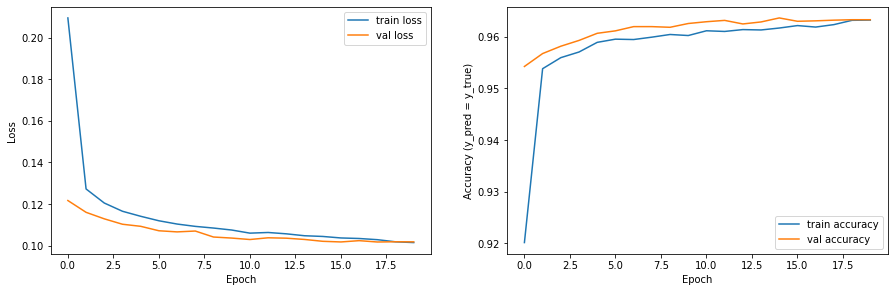

In [25]:
# plot loss vs epoch
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

# plot accuracy vs epoch
axes = plt.subplot(2, 2, 2)
axes.plot(history.history['accuracy'], label = 'train accuracy')
axes.plot(history.history['val_accuracy'], label = 'val accuracy')
axes.legend(loc = "lower right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Accuracy (y_pred = y_true)')

## Partition the test set into sig/bkg sets

In [26]:
# test set
test_sig_number = np.count_nonzero(Y_test)
test_bkg_number = np.count_nonzero(Y_test == 0)

X_test_sig = np.zeros((test_sig_number,X_test.shape[1]))
X_test_bkg = np.zeros((test_bkg_number,X_test.shape[1]))

j = 0
k = 0
for i in range(Y_test.shape[0]):
    if Y_test[i,0] == 1:
        X_test_sig[j,:] = X_test[i,:]
        j = j + 1
    else:
        X_test_bkg[k,:] = X_test[i,:]
        k = k + 1

# train+val set
train_val_sig_number = np.count_nonzero(Y_train_val)
train_val_bkg_number = np.count_nonzero(Y_train_val == 0)

X_train_val_sig = np.zeros((train_val_sig_number,X_train_val.shape[1]))
X_train_val_bkg = np.zeros((train_val_bkg_number,X_train_val.shape[1]))

j = 0
k = 0
for i in range(Y_train_val.shape[0]):
    if Y_train_val[i,0] == 1:
        X_train_val_sig[j,:] = X_train_val[i,:]
        j = j + 1
    else:
        X_train_val_bkg[k,:] = X_train_val[i,:]
        k = k + 1

## Test set performance plots

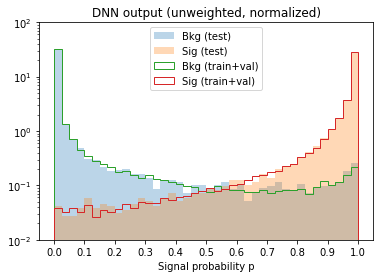

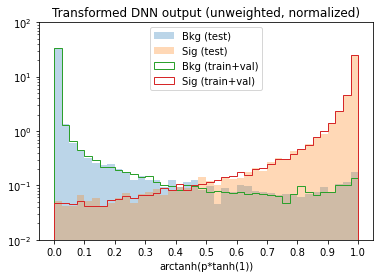

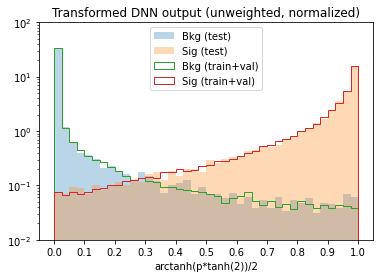

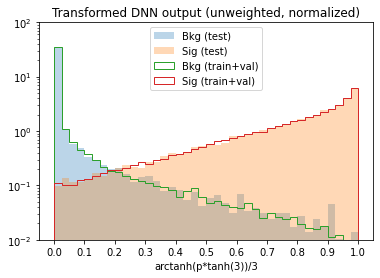

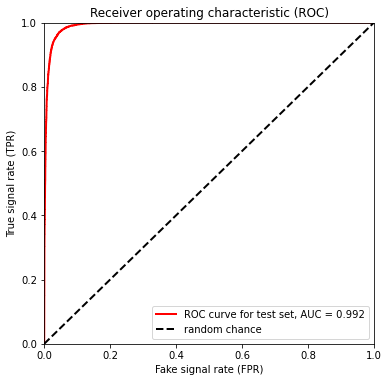

Test loss, test accuracy: [0.10397659189113828, 0.9614289402961731]


In [27]:
#pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 40, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 40, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(model.predict(X_test_sig), density = 1, range = (0.0, 1.0), bins = 40, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(model.predict(X_train_val_bkg), density = 1, range = (0.0, 1.0), bins = 40, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(model.predict(X_train_val_sig), density = 1, range = (0.0, 1.0), bins = 40, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('DNN output (unweighted, normalized)')
pyplot.xlabel('Signal probability p')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,1e2)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 40, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 40, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(1))')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,1e2)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 40, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 40, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(2))/2')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,1e2)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 40, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 40, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 40, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(3))/3')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,1e2)
pyplot.show()

# Plot ROC
plt.figure(figsize = (13,13))
Y_predict = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
axes = plt.subplot(2, 2, 1)
axes.plot(fpr, tpr, lw = 2, color = 'red', label = 'ROC curve for test set, AUC = %.3f' % (roc_auc))
axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
axes.set_xlabel('Fake signal rate (FPR)')
axes.set_ylabel('True signal rate (TPR)')
axes.set_title('Receiver operating characteristic (ROC)')
axes.legend(loc = "lower right")
plt.show()

results = model.evaluate(X_test, Y_test, verbose = 0, batch_size = 256)
print("Test loss, test accuracy:", results)

## Save trained model

In [28]:
joblib.dump(scaler, 'trained_models/mt1b_scaler.gz')
model.save('trained_models/mt1b_model')

## Load saved model

In [ ]:
savedscaler = joblib.load('trained_models/mt1b_scaler.gz')
savedmodel = keras.models.load_model('trained_models/mt1b_model')
savedmodel.summary()

# Write model prediction to root files

## Load all root files one by one

In [29]:
from root_numpy import array2root

########### 2018
infolder18 = 'root_raw/mt18_raw/'
outfolder18 = 'root_outputs/mt18_outputs/'

inpaths18 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3LNu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt12.root', 'ggH_bbtt20.root', 'ggH_bbtt30.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt50.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt12.root', 'vbf_bbtt20.root', 'vbf_bbtt30.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt50.root', 'vbf_bbtt60.root']

outpaths18 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3LNu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'gghbbtt12.root', 'gghbbtt20.root', 'gghbbtt30.root', 'gghbbtt40.root'\
         , 'gghbbtt50.root', 'gghbbtt60.root', 'ttHnonbb.root'\
         , 'vbfbbtt12.root', 'vbfbbtt20.root', 'vbfbbtt30.root', 'vbfbbtt40.root'\
         , 'vbfbbtt50.root', 'vbfbbtt60.root']

for i in range(len(inpaths18)):
    inpaths18[i] = infolder18 + inpaths18[i]
    outpaths18[i] = outfolder18 + outpaths18[i]

allfiles18 = []
for i in range(len(inpaths18)):
    allfiles18.append(ROOT.RDataFrame('mutau_tree', inpaths18[i]))


for i in range(len(allfiles18)):
    allfiles18[i] = allfiles18[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b1tau', m_b1tau)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

########### 2017
infolder17 = 'root_raw/mt17_raw/'
outfolder17 = 'root_outputs/mt17_outputs/'

inpaths17 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt12.root', 'ggH_bbtt20.root', 'ggH_bbtt30.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt50.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt12.root', 'vbf_bbtt20.root', 'vbf_bbtt30.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt50.root', 'vbf_bbtt60.root']

outpaths17 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'gghbbtt12.root', 'gghbbtt20.root', 'gghbbtt30.root', 'gghbbtt40.root'\
         , 'gghbbtt50.root', 'gghbbtt60.root', 'ttHnonbb.root'\
         , 'vbfbbtt12.root', 'vbfbbtt20.root', 'vbfbbtt30.root', 'vbfbbtt40.root'\
         , 'vbfbbtt50.root', 'vbfbbtt60.root']

for i in range(len(inpaths17)):
    inpaths17[i] = infolder17 + inpaths17[i]
    outpaths17[i] = outfolder17 + outpaths17[i]

allfiles17 = []
for i in range(len(inpaths17)):
    allfiles17.append(ROOT.RDataFrame('mutau_tree', inpaths17[i]))


for i in range(len(allfiles17)):
    allfiles17[i] = allfiles17[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b1tau', m_b1tau)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

########### 2016
infolder16 = 'root_raw/mt16_raw/'
outfolder16 = 'root_outputs/mt16_outputs/'

inpaths16 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TT.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt15.root', 'ggH_bbtt20.root', 'ggH_bbtt25.root', 'ggH_bbtt30.root', 'ggH_bbtt35.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt45.root', 'ggH_bbtt50.root', 'ggH_bbtt55.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt15.root', 'vbf_bbtt20.root', 'vbf_bbtt25.root', 'vbf_bbtt30.root', 'vbf_bbtt35.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt45.root', 'vbf_bbtt50.root', 'vbf_bbtt55.root', 'vbf_bbtt60.root']

outpaths16 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TT.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt15.root', 'ggH_bbtt20.root', 'ggH_bbtt25.root', 'ggH_bbtt30.root', 'ggH_bbtt35.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt45.root', 'ggH_bbtt50.root', 'ggH_bbtt55.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt15.root', 'vbf_bbtt20.root', 'vbf_bbtt25.root', 'vbf_bbtt30.root', 'vbf_bbtt35.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt45.root', 'vbf_bbtt50.root', 'vbf_bbtt55.root', 'vbf_bbtt60.root']

for i in range(len(inpaths16)):
    inpaths16[i] = infolder16 + inpaths16[i]
    outpaths16[i] = outfolder16 + outpaths16[i]

allfiles16 = []
for i in range(len(inpaths16)):
    allfiles16.append(ROOT.RDataFrame('mutau_tree', inpaths16[i]))


for i in range(len(allfiles16)):
    allfiles16[i] = allfiles16[i].Define('mymu', mymu)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('m_btt', m_btt)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b1tau', m_b1tau)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

## Data pre-processing

In [30]:
######### 2018
for i in range(len(allfiles18)):
    allfiles18[i] = pd.DataFrame(allfiles18[i].AsNumpy(feature_list))
    allfiles18[i] = allfiles18[i].values
    allfiles18[i] = scaler.transform(allfiles18[i])
    print(inpaths18[i])

root_raw/mt18_raw/DY.root
root_raw/mt18_raw/DY1.root
root_raw/mt18_raw/DY2.root
root_raw/mt18_raw/DY3.root
root_raw/mt18_raw/DY4.root
root_raw/mt18_raw/GGHTT.root
root_raw/mt18_raw/GGHWW.root
root_raw/mt18_raw/GGZHLLTT.root
root_raw/mt18_raw/GGZHNNTT.root
root_raw/mt18_raw/GGZHQQTT.root
root_raw/mt18_raw/GGZHWW.root
root_raw/mt18_raw/ST_tW_antitop.root
root_raw/mt18_raw/ST_tW_top.root
root_raw/mt18_raw/ST_t_antitop.root
root_raw/mt18_raw/ST_t_top.root
root_raw/mt18_raw/TTTo2L2Nu.root
root_raw/mt18_raw/TTToHadronic.root
root_raw/mt18_raw/TTToSemiLeptonic.root
root_raw/mt18_raw/VBFHTT.root
root_raw/mt18_raw/VBFHWW.root
root_raw/mt18_raw/VV2L2Nu.root
root_raw/mt18_raw/WZ2L2Q.root
root_raw/mt18_raw/WZ3LNu.root
root_raw/mt18_raw/WminusHTT.root
root_raw/mt18_raw/WminusHWW.root
root_raw/mt18_raw/WplusHTT.root
root_raw/mt18_raw/WplusHWW.root
root_raw/mt18_raw/ZHTT.root
root_raw/mt18_raw/ZHWW.root
root_raw/mt18_raw/ZZ2L2Q.root
root_raw/mt18_raw/ZZ4L.root
root_raw/mt18_raw/data_obs.root
root_raw

In [32]:
######### 2017
for i in range(len(allfiles17)):
    allfiles17[i] = pd.DataFrame(allfiles17[i].AsNumpy(feature_list))
    allfiles17[i] = allfiles17[i].values
    allfiles17[i] = scaler.transform(allfiles17[i])
    print(inpaths17[i])

root_raw/mt17_raw/DY.root
root_raw/mt17_raw/DY1.root
root_raw/mt17_raw/DY2.root
root_raw/mt17_raw/DY3.root
root_raw/mt17_raw/DY4.root
root_raw/mt17_raw/GGHTT.root
root_raw/mt17_raw/GGHWW.root
root_raw/mt17_raw/GGZHLLTT.root
root_raw/mt17_raw/GGZHNNTT.root
root_raw/mt17_raw/GGZHQQTT.root
root_raw/mt17_raw/GGZHWW.root
root_raw/mt17_raw/ST_tW_antitop.root
root_raw/mt17_raw/ST_tW_top.root
root_raw/mt17_raw/ST_t_antitop.root
root_raw/mt17_raw/ST_t_top.root
root_raw/mt17_raw/TTTo2L2Nu.root
root_raw/mt17_raw/TTToHadronic.root
root_raw/mt17_raw/TTToSemiLeptonic.root
root_raw/mt17_raw/VBFHTT.root
root_raw/mt17_raw/VBFHWW.root
root_raw/mt17_raw/VV2L2Nu.root
root_raw/mt17_raw/WZ2L2Q.root
root_raw/mt17_raw/WZ3L1Nu.root
root_raw/mt17_raw/WminusHTT.root
root_raw/mt17_raw/WminusHWW.root
root_raw/mt17_raw/WplusHTT.root
root_raw/mt17_raw/WplusHWW.root
root_raw/mt17_raw/ZHTT.root
root_raw/mt17_raw/ZHWW.root
root_raw/mt17_raw/ZZ2L2Q.root
root_raw/mt17_raw/ZZ4L.root
root_raw/mt17_raw/data_obs.root
root_ra

In [34]:
######### 2016
for i in range(len(allfiles16)):
    allfiles16[i] = pd.DataFrame(allfiles16[i].AsNumpy(feature_list))
    allfiles16[i] = allfiles16[i].values
    allfiles16[i] = scaler.transform(allfiles16[i])
    print(inpaths16[i])

root_raw/mt16_raw/DY.root
root_raw/mt16_raw/DY1.root
root_raw/mt16_raw/DY2.root
root_raw/mt16_raw/DY3.root
root_raw/mt16_raw/DY4.root
root_raw/mt16_raw/GGHTT.root
root_raw/mt16_raw/GGHWW.root
root_raw/mt16_raw/GGZHLLTT.root
root_raw/mt16_raw/GGZHNNTT.root
root_raw/mt16_raw/GGZHQQTT.root
root_raw/mt16_raw/GGZHWW.root
root_raw/mt16_raw/ST_tW_antitop.root
root_raw/mt16_raw/ST_tW_top.root
root_raw/mt16_raw/ST_t_antitop.root
root_raw/mt16_raw/ST_t_top.root
root_raw/mt16_raw/TT.root
root_raw/mt16_raw/VBFHTT.root
root_raw/mt16_raw/VBFHWW.root
root_raw/mt16_raw/VV2L2Nu.root
root_raw/mt16_raw/WZ2L2Q.root
root_raw/mt16_raw/WZ3L1Nu.root
root_raw/mt16_raw/WminusHTT.root
root_raw/mt16_raw/WminusHWW.root
root_raw/mt16_raw/WplusHTT.root
root_raw/mt16_raw/WplusHWW.root
root_raw/mt16_raw/ZHTT.root
root_raw/mt16_raw/ZHWW.root
root_raw/mt16_raw/ZZ2L2Q.root
root_raw/mt16_raw/ZZ4L.root
root_raw/mt16_raw/data_obs.root
root_raw/mt16_raw/embedded.root
root_raw/mt16_raw/ggH_bbtt15.root
root_raw/mt16_raw/ggH_bb

## Feed to NN and write outputs to root files

In [31]:
######### 2018
for i in range(len(allfiles18)):
    y_pred = model.predict(allfiles18[i])
    y_pred = np.array(y_pred, dtype = [('dnn_1b', np.float32)])
    array2root(y_pred, filename = outpaths18[i], treename = 'mutau_tree_dnn', mode = 'update')
    print(outpaths18[i])

root_outputs/mt18_outputs/DY.root
root_outputs/mt18_outputs/DY1.root
root_outputs/mt18_outputs/DY2.root
root_outputs/mt18_outputs/DY3.root
root_outputs/mt18_outputs/DY4.root
root_outputs/mt18_outputs/GGHTT.root
root_outputs/mt18_outputs/GGHWW.root
root_outputs/mt18_outputs/GGZHLLTT.root
root_outputs/mt18_outputs/GGZHNNTT.root
root_outputs/mt18_outputs/GGZHQQTT.root
root_outputs/mt18_outputs/GGZHWW.root
root_outputs/mt18_outputs/ST_tW_antitop.root
root_outputs/mt18_outputs/ST_tW_top.root
root_outputs/mt18_outputs/ST_t_antitop.root
root_outputs/mt18_outputs/ST_t_top.root
root_outputs/mt18_outputs/TTTo2L2Nu.root
root_outputs/mt18_outputs/TTToHadronic.root
root_outputs/mt18_outputs/TTToSemiLeptonic.root
root_outputs/mt18_outputs/VBFHTT.root
root_outputs/mt18_outputs/VBFHWW.root
root_outputs/mt18_outputs/VV2L2Nu.root
root_outputs/mt18_outputs/WZ2L2Q.root
root_outputs/mt18_outputs/WZ3LNu.root
root_outputs/mt18_outputs/WminusHTT.root
root_outputs/mt18_outputs/WminusHWW.root
root_outputs/mt18_

In [33]:
######### 2017
for i in range(len(allfiles17)):
    y_pred = model.predict(allfiles17[i])
    y_pred = np.array(y_pred, dtype = [('dnn_1b', np.float32)])
    array2root(y_pred, filename = outpaths17[i], treename = 'mutau_tree_dnn', mode = 'update')
    print(outpaths17[i])

root_outputs/mt17_outputs/DY.root
root_outputs/mt17_outputs/DY1.root
root_outputs/mt17_outputs/DY2.root
root_outputs/mt17_outputs/DY3.root
root_outputs/mt17_outputs/DY4.root
root_outputs/mt17_outputs/GGHTT.root
root_outputs/mt17_outputs/GGHWW.root
root_outputs/mt17_outputs/GGZHLLTT.root
root_outputs/mt17_outputs/GGZHNNTT.root
root_outputs/mt17_outputs/GGZHQQTT.root
root_outputs/mt17_outputs/GGZHWW.root
root_outputs/mt17_outputs/ST_tW_antitop.root
root_outputs/mt17_outputs/ST_tW_top.root
root_outputs/mt17_outputs/ST_t_antitop.root
root_outputs/mt17_outputs/ST_t_top.root
root_outputs/mt17_outputs/TTTo2L2Nu.root
root_outputs/mt17_outputs/TTToHadronic.root
root_outputs/mt17_outputs/TTToSemiLeptonic.root
root_outputs/mt17_outputs/VBFHTT.root
root_outputs/mt17_outputs/VBFHWW.root
root_outputs/mt17_outputs/VV2L2Nu.root
root_outputs/mt17_outputs/WZ2L2Q.root
root_outputs/mt17_outputs/WZ3L1Nu.root
root_outputs/mt17_outputs/WminusHTT.root
root_outputs/mt17_outputs/WminusHWW.root
root_outputs/mt17

In [35]:
######### 2016
for i in range(len(allfiles16)):
    y_pred = model.predict(allfiles16[i])
    y_pred = np.array(y_pred, dtype = [('dnn_1b', np.float32)])
    array2root(y_pred, filename = outpaths16[i], treename = 'mutau_tree_dnn', mode = 'update')
    print(outpaths16[i])

root_outputs/mt16_outputs/DY.root
root_outputs/mt16_outputs/DY1.root
root_outputs/mt16_outputs/DY2.root
root_outputs/mt16_outputs/DY3.root
root_outputs/mt16_outputs/DY4.root
root_outputs/mt16_outputs/GGHTT.root
root_outputs/mt16_outputs/GGHWW.root
root_outputs/mt16_outputs/GGZHLLTT.root
root_outputs/mt16_outputs/GGZHNNTT.root
root_outputs/mt16_outputs/GGZHQQTT.root
root_outputs/mt16_outputs/GGZHWW.root
root_outputs/mt16_outputs/ST_tW_antitop.root
root_outputs/mt16_outputs/ST_tW_top.root
root_outputs/mt16_outputs/ST_t_antitop.root
root_outputs/mt16_outputs/ST_t_top.root
root_outputs/mt16_outputs/TT.root
root_outputs/mt16_outputs/VBFHTT.root
root_outputs/mt16_outputs/VBFHWW.root
root_outputs/mt16_outputs/VV2L2Nu.root
root_outputs/mt16_outputs/WZ2L2Q.root
root_outputs/mt16_outputs/WZ3L1Nu.root
root_outputs/mt16_outputs/WminusHTT.root
root_outputs/mt16_outputs/WminusHWW.root
root_outputs/mt16_outputs/WplusHTT.root
root_outputs/mt16_outputs/WplusHWW.root
root_outputs/mt16_outputs/ZHTT.root
